In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyodbc


In [2]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def envoyer_mail_arret_machine(machine_name, start_time, hours_stopped, sender_email, sender_password, receiver_email):
    """
    Envoie un email pour signaler qu'une machine est arrêtée depuis X heures.
    """
    subject = f"🚨 Machine {machine_name} arrêtée depuis {hours_stopped}h"
    logo_url = "https://misfat.com.tn/wp-content/uploads/2020/10/misfsat-filtration-logo_1.png"
    
    html_body = f"""
    <html>
    <body style="font-family: Arial, sans-serif; background-color: #f4f6f8; padding: 20px;">
        <div style="background-color: white; padding: 30px; border-radius: 12px; max-width: 700px; margin: auto; border: 1px solid #ddd;">
            <div style="text-align: center;">
                <img src="{logo_url}" alt="Logo MISFAT" style="width: 200px;"/>
                <h2 style="color: #e60000;">🚨 Alerte Machine Arrêtée</h2>
            </div>
            <p style="font-size: 16px; color: #333;">
                Bonjour,<br><br>
                La machine <strong>{machine_name}</strong> est arrêtée depuis <strong>{hours_stopped} heures</strong>.<br><br>
                <strong>Début de l'arrêt :</strong> {start_time.strftime('%d/%m/%Y %H:%M')}<br><br>
                Merci de vérifier rapidement.<br><br>
                <em>(Ceci est un message automatique)</em>
            </p>
            <p style="color: #555; font-size: 12px; text-align: center;">
                © 2025 MISFAT Filtration
            </p>
        </div>
    </body>
    </html>
    """

    msg = MIMEMultipart("alternative")
    msg["From"] = sender_email
    msg["To"] = receiver_email
    msg["Subject"] = subject
    msg.attach(MIMEText(html_body, "html"))

    try:
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender_email, sender_password)
            server.send_message(msg)
            print(f"✅ Email envoyé pour {machine_name} arrêtée depuis {hours_stopped}h.")
    except Exception as e:
        print(f"❌ Erreur lors de l'envoi : {e}")


In [3]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_alert_email(anomalies, model_name, sender_email, receiver_email, password):
    """
    Envoie un email d'alerte formaté proprement avec logo, tableau d'anomalies, et modèle utilisé.
    """
    subject = f"🚨 Alerte : Anomalies détectées - {model_name}"

    # Nettoyage
    anomalies_display = anomalies.copy()
    anomalies_display.columns = [col.lower() for col in anomalies_display.columns]  # tout en minuscule

    # Déterminer les colonnes à afficher
    expected_cols = ['machine', 'date']
    if 'consommation' in anomalies_display.columns:
        expected_cols.append('consommation')
    elif 'valeur' in anomalies_display.columns:
        expected_cols.append('valeur')
    
    anomalies_display = anomalies_display[expected_cols]

    # Convertir anomalies en tableau HTML
    table_html = anomalies_display.to_html(index=False, justify='center', border=1)

    # Logo Misfat
    logo_url = "https://misfat.com.tn/wp-content/uploads/2020/10/misfsat-filtration-logo_1.png"

    # Corps HTML du mail
    body = f"""
    <html>
        <body style="font-family: Arial, sans-serif; background-color: #f4f6f8; padding: 20px;">
            <div style="background-color: white; padding: 30px; border-radius: 12px; border: 1px solid #ddd; max-width: 800px; margin: auto;">
                <div style="text-align: center; margin-bottom: 30px;">
                    <img src="{logo_url}" alt="Logo MISFAT" style="width: 200px;"/>
                    <h2 style="color: #e60000;">🚨 Alerte : Anomalies Détectées</h2>
                </div>
                <p style="font-size: 16px; color: #333;">
                    Bonjour,<br><br>
                    Nous avons détecté des anomalies dans les données de consommation. 
                    Merci de bien vouloir <strong>vérifier rapidement</strong> les équipements concernés ci-dessous.
                </p>
                <br>
                <p style="font-size: 16px;"><strong>Modèle utilisé :</strong> {model_name}</p>
                <p style="font-size: 16px;"><strong>Détails des anomalies :</strong></p>
                {table_html}
                <br><br>
                <p style="color: #555; font-size: 12px; text-align: center;">
                    Merci de votre réactivité.<br>
                    © 2025 MISFAT Filtration - Tous droits réservés
                </p>
            </div>
        </body>
    </html>
    """

    # Création du message email
    msg = MIMEMultipart("alternative")
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'html'))

    try:
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.send_message(msg)
            print("✅ Email d’alerte envoyé avec succès.")
    except Exception as e:
        print(f"❌ Erreur lors de l’envoi de l’email : {e}")


In [4]:
# Paramètres de connexion
server = r'DESKTOP-72EKKD8'  # Ajout du 'r' pour éviter les erreurs d'échappement
database = 'MISFAT3'
driver = '{ODBC Driver 17 for SQL Server}'

try:
    # Connexion à SQL Server avec plus de débogage
    conn = pyodbc.connect(
        f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;',
        timeout=10
    )
    print("✅ Connection successful")
except Exception as e:
    print("❌ Connection failed:", str(e))  # Affiche l'erreur exacte
    exit()  # Arrête le programme proprement

# Création du curseur
cursor = conn.cursor()

# Exécuter la requête SQL (corrigé)
try:
    cursor.execute("SELECT * FROM  [M3.csv]")  # Vérifie bien le nom de ta table
    rows = [list(row) for row in cursor.fetchall()]
    columns = ["Timestamp", "G19", "G26", "MISFAT 3 D18 ", "MISFAT 3 D02.01 M43","MISFAT 3 Eclairage 3-2 ","MISFAT 3 G10","MISFAT 3 G33 ","MISFAT 3 G39","MISFAT 3 H39","MISFAT 3 H46","MISFAT 3 H53","MISFAT 3 N11"]  # Assure-toi que ces noms correspondent à ta base
    df = pd.DataFrame(rows, columns=columns)
    print("✅ DataFrame created:")
    print(df.head())  # Affiche les 5 premières lignes
except Exception as e:
    print("❌ Erreur lors de l'exécution de la requête :", str(e))
    # Fermeture de la connexion
cursor.close()
conn.close()
print("🔒 Connection closed")

✅ Connection successful
✅ DataFrame created:
                  Timestamp     G19     G26 MISFAT 3 D18  MISFAT 3 D02.01 M43  \
0  2025-01-01 00:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   
1  2025-01-01 01:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   
2  2025-01-01 02:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   
3  2025-01-01 03:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   
4  2025-01-01 04:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   

  MISFAT 3 Eclairage 3-2  MISFAT 3 G10 MISFAT 3 G33  MISFAT 3 G39  \
0                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   
1                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   
2                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   
3                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   
4                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   

  MISFAT 3 H39 MISFAT 3 H46 MISFAT 3 H53 MISFAT 3 N11

In [5]:
import pandas as pd


# 2. Affichage initial pour vérifier le contenu
print("📌 Colonnes originales :", df.columns.tolist())
print("🔍 Aperçu brut des données :")
print(df.head(3))
# Supprime les espaces en trop et uniformise les noms
df.columns = df.columns.str.strip()
# 3. Nettoyage des noms de colonnes
#df.columns = [col.strip().replace(' ', '_') for col in df.columns]
print("✅ Colonnes nettoyées :", df.columns.tolist())
# Supprime les espaces en trop et uniformise les noms
df.columns = df.columns.str.strip()

# 4. Conversion de la colonne Timestamp en datetime
try:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    print("📅 Timestamp converti et utilisé comme index")
except Exception as e:
    print("❌ Erreur de conversion du Timestamp :", str(e))

# 5. Nettoyage des colonnes de consommation (remplace kWh, ;, etc.)
for col in df.columns:
    try:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace("kWh", "", regex=False)
            .str.replace(";", ",", regex=False)
            .str.replace(",", ".", regex=False)
            .astype(float)
        )
    except Exception as e:
        print(f"⚠ Erreur dans la colonne '{col}' :", str(e))

# 6. Affichage des valeurs manquantes
print("📉 Valeurs manquantes par colonne :")
print(df.isna().sum())

# 7. Option de traitement des valeurs manquantes
# --> Choisir dropna() ou interpolation
df = df.interpolate(method='time')  # Ou df = df.dropna()

# 8. Résumé final
print("✅ Données prêtes à être utilisées :")
print(df.info())
print(df.head(3))


📌 Colonnes originales : ['Timestamp', 'G19', 'G26', 'MISFAT 3 D18 ', 'MISFAT 3 D02.01 M43', 'MISFAT 3 Eclairage 3-2 ', 'MISFAT 3 G10', 'MISFAT 3 G33 ', 'MISFAT 3 G39', 'MISFAT 3 H39', 'MISFAT 3 H46', 'MISFAT 3 H53', 'MISFAT 3 N11']
🔍 Aperçu brut des données :
                  Timestamp     G19     G26 MISFAT 3 D18  MISFAT 3 D02.01 M43  \
0  2025-01-01 00:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   
1  2025-01-01 01:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   
2  2025-01-01 02:00:00 CEST  0,0kWh  0,0kWh        0,0kWh              0,0kWh   

  MISFAT 3 Eclairage 3-2  MISFAT 3 G10 MISFAT 3 G33  MISFAT 3 G39  \
0                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   
1                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   
2                  0,0kWh       0,0kWh        0,0kWh       0,0kWh   

  MISFAT 3 H39 MISFAT 3 H46 MISFAT 3 H53 MISFAT 3 N11  
0       0,0kWh       0,0kWh       0,0kWh       0,0kWh  
1       0,0kWh       0,0kW

C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3049853782.py:18: FutureWarning: Parsed string "2025-01-01 00:00:00 CEST" included an un-recognized timezone "CEST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


📅 Timestamp converti et utilisé comme index
📉 Valeurs manquantes par colonne :
G19                       0
G26                       0
MISFAT 3 D18              0
MISFAT 3 D02.01 M43       0
MISFAT 3 Eclairage 3-2    0
MISFAT 3 G10              0
MISFAT 3 G33              0
MISFAT 3 G39              0
MISFAT 3 H39              0
MISFAT 3 H46              0
MISFAT 3 H53              0
MISFAT 3 N11              0
dtype: int64
✅ Données prêtes à être utilisées :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2025-01-01 00:00:00 to 2025-04-22 12:00:00
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   G19                     2667 non-null   float64
 1   G26                     2667 non-null   float64
 2   MISFAT 3 D18            2667 non-null   float64
 3   MISFAT 3 D02.01 M43     2667 non-null   float64
 4   MISFAT 3 Eclairage 3-2  2667 non-null   float64
 5   MISFAT 3 G10     

In [6]:
df.head()

G19  G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
Timestamp                                                          
2025-01-01 00:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 01:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 02:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 03:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 04:00:00  0.0  0.0           0.0                  0.0   

                     MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  \
Timestamp                                                                 
2025-01-01 00:00:00                     0.0           0.0           0.0   
2025-01-01 01:00:00                     0.0           0.0           0.0   
2025-01-01 02:00:00                     0.0           0.0           0.0   
2025-01-01 03:00:00                     0.0           0.0           0.0   
2025-01-01 04:00:00                     0.0           0.0           0.0   

                     MISFAT 3 G39  MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  \
Timestamp                                                                     
2025-01-01 00:00:00           0.0           0.0           0.0           0.0   
2025-01-01 01:00:00           0.0           0.0           0.0           0.0   
2025-01-01 02:00:00           0.0           0.0           0.0           0.0   
2025-01-01 03:00:00           0.0           0.0           0.0           0.0   
2025-01-01 04:00:00           0.0           0.0           0.0           0.0   

                     MISFAT 3 N11  
Timestamp                          
2025-01-01 00:00:00           0.0  
2025-01-01 01:00:00           0.0  
2025-01-01 02:00:00           0.0  
2025-01-01 03:00:00           0.0  
2025-01-01 04:00:00           0.0

In [7]:
print(df.reset_index()['Timestamp'].head())


0   2025-01-01 00:00:00
1   2025-01-01 01:00:00
2   2025-01-01 02:00:00
3   2025-01-01 03:00:00
4   2025-01-01 04:00:00
Name: Timestamp, dtype: datetime64[ns]


In [8]:
import pandas as pd
import numpy as np

# Créer un masque : machine arrêtée si toutes les colonnes capteurs sont à 0.0
mask_machines_off = (df.iloc[:, 1:] == 0.0).all(axis=1)

# Séparer les données :
df_running = df[~mask_machines_off].copy()  # Machines en marche (important pour l'entraînement)

print(f"✅ Nombre total de lignes : {df.shape[0]}")
print(f"✅ Nombre de lignes avec machines allumées : {df_running.shape[0]}")
print(f"❗ Nombre de lignes ignorées (machines arrêtées) : {mask_machines_off.sum()}")


✅ Nombre total de lignes : 2667
✅ Nombre de lignes avec machines allumées : 2642
❗ Nombre de lignes ignorées (machines arrêtées) : 25


In [9]:
# Tester les colonnes qui sont entièrement à zéro
cols_all_zero = (df_running.iloc[:, 1:] == 0.0).all(axis=0)

# Afficher les colonnes concernées
cols_all_zero = cols_all_zero[cols_all_zero].index.tolist()

print(f"🚨 Colonnes totalement à zéro : {cols_all_zero}")


🚨 Colonnes totalement à zéro : ['MISFAT 3 Eclairage 3-2', 'MISFAT 3 H39']


In [10]:
# Scanner correctement : colonnes où toutes les valeurs sont nulles ou égales à 0.0
cols_all_zero = df_running.iloc[:, 1:].apply(lambda col: (col == 0.0).all(), axis=0)

# Liste des colonnes concernées
cols_all_zero = cols_all_zero[cols_all_zero].index.tolist()

print(f"🚨 Colonnes totalement à zéro : {cols_all_zero}")

# Si des colonnes sont concernées -> on les supprime
if cols_all_zero:
    df_running = df_running.drop(columns=cols_all_zero)
    print(f"✅ Colonnes supprimées : {cols_all_zero}")
else:
    print("✅ Aucune colonne totalement à zéro. Rien à supprimer.")


🚨 Colonnes totalement à zéro : ['MISFAT 3 Eclairage 3-2', 'MISFAT 3 H39']
✅ Colonnes supprimées : ['MISFAT 3 Eclairage 3-2', 'MISFAT 3 H39']


In [11]:
# Vérifier les lignes avec au moins une valeur manquante
missing_rows = df[df.isna().any(axis=1)]

if not missing_rows.empty:
    print("🔍 Lignes contenant des valeurs manquantes AVANT traitement :")
    display(missing_rows)
else:
    print("✅ Aucune ligne avec des valeurs manquantes détectée")

# Supprimer les lignes totalement vides
df = df.dropna(how='all')

# Interpolation linéaire temporelle pour remplir les valeurs manquantes internes
df = df.interpolate(method='linear', axis=0)

# Compléter ce qui resterait (début/fin) par la moyenne de chaque colonne
df = df.fillna(df.mean(numeric_only=True))

# ➕ Définir le DataFrame final nettoyé
df_cleaned = df.copy()

print("✅ Traitement terminé : lignes vides supprimées, NaN interpolés/comblés")
print("🧼 Aperçu du DataFrame nettoyé :")
display(df_cleaned.head())


✅ Aucune ligne avec des valeurs manquantes détectée
✅ Traitement terminé : lignes vides supprimées, NaN interpolés/comblés
🧼 Aperçu du DataFrame nettoyé :


G19  G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
Timestamp                                                          
2025-01-01 00:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 01:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 02:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 03:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 04:00:00  0.0  0.0           0.0                  0.0   

                     MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  \
Timestamp                                                                 
2025-01-01 00:00:00                     0.0           0.0           0.0   
2025-01-01 01:00:00                     0.0           0.0           0.0   
2025-01-01 02:00:00                     0.0           0.0           0.0   
2025-01-01 03:00:00                     0.0           0.0           0.0   
2025-01-01 04:00:00                     0.0           0.0           0.0   

                     MISFAT 3 G39  MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  \
Timestamp                                                                     
2025-01-01 00:00:00           0.0           0.0           0.0           0.0   
2025-01-01 01:00:00           0.0           0.0           0.0           0.0   
2025-01-01 02:00:00           0.0           0.0           0.0           0.0   
2025-01-01 03:00:00           0.0           0.0           0.0           0.0   
2025-01-01 04:00:00           0.0           0.0           0.0           0.0   

                     MISFAT 3 N11  
Timestamp                          
2025-01-01 00:00:00           0.0  
2025-01-01 01:00:00           0.0  
2025-01-01 02:00:00           0.0  
2025-01-01 03:00:00           0.0  
2025-01-01 04:00:00           0.0

In [12]:
outliers = pd.DataFrame(index=df.index)

for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Marque les valeurs aberrantes (True si outlier)
    outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

# Compte le nombre d’outliers par machine
outlier_counts = outliers.sum()
print("📊 Nombre d'outliers détectés par machine :")
print(outlier_counts)

# Affiche les lignes contenant au moins un outlier
outlier_rows = df[outliers.any(axis=1)]
print(f"🧨 Total de lignes contenant des outliers : {len(outlier_rows)}")
display(outlier_rows.head())


📊 Nombre d'outliers détectés par machine :
G19                         0
G26                         0
MISFAT 3 D18                0
MISFAT 3 D02.01 M43        40
MISFAT 3 Eclairage 3-2      0
MISFAT 3 G10                0
MISFAT 3 G33                0
MISFAT 3 G39                0
MISFAT 3 H39                0
MISFAT 3 H46                0
MISFAT 3 H53                0
MISFAT 3 N11              614
dtype: int64
🧨 Total de lignes contenant des outliers : 650


G19     G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
Timestamp                                                                    
2025-01-02 21:00:00    6.171875  47.250       35.3125            30.054688   
2025-01-03 21:00:00    1.187500  97.875       41.8750            31.437500   
2025-01-04 07:00:00  111.593750  97.250       33.7500             0.140625   
2025-01-04 08:00:00  105.890625  93.375       29.3750             0.132812   
2025-01-04 09:00:00  102.000000  85.000       28.9375             0.132812   

                     MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  \
Timestamp                                                                 
2025-01-02 21:00:00                     0.0      0.000000     56.296875   
2025-01-03 21:00:00                     0.0      0.000000      0.000000   
2025-01-04 07:00:00                     0.0      8.008301     58.265625   
2025-01-04 08:00:00                     0.0      7.822266     58.851562   
2025-01-04 09:00:00                     0.0      7.776367     49.476562   

                     MISFAT 3 G39  MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  \
Timestamp                                                                     
2025-01-02 21:00:00       1.43750           0.0     12.229492      9.457031   
2025-01-03 21:00:00      42.84375           0.0     11.687500      9.378906   
2025-01-04 07:00:00      41.31250           0.0     10.778320     13.404297   
2025-01-04 08:00:00      41.46875           0.0     12.220703     12.484375   
2025-01-04 09:00:00      41.34375           0.0     11.994141     13.347656   

                     MISFAT 3 N11  
Timestamp                          
2025-01-02 21:00:00       0.00000  
2025-01-03 21:00:00       0.00000  
2025-01-04 07:00:00       9.93750  
2025-01-04 08:00:00      13.62500  
2025-01-04 09:00:00      13.53125

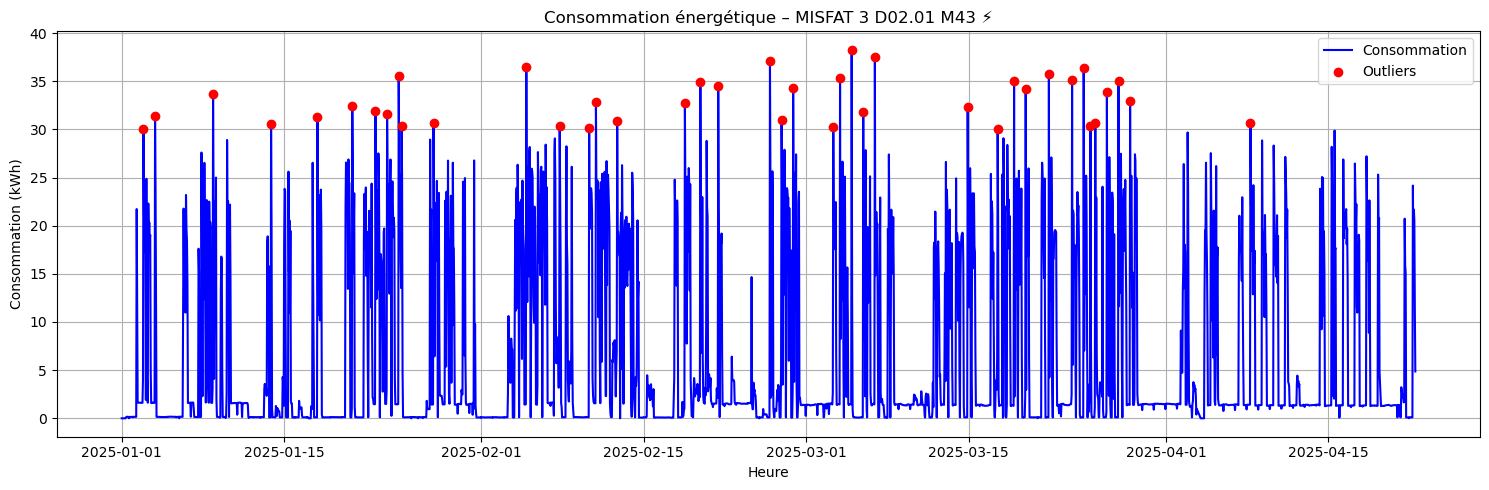

In [13]:
import matplotlib.pyplot as plt

# 🛠️ Choisis la machine que tu veux visualiser
machine = 'MISFAT 3 D02.01 M43'  # tu peux changer pour une autre colonne

plt.figure(figsize=(15, 5))
plt.plot(df.index, df[machine], label='Consommation', color='blue')

# Affiche les outliers en rouge
plt.scatter(
    df.index[outliers[machine]],
    df[machine][outliers[machine]],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title(f"Consommation énergétique – {machine} ⚡")
plt.xlabel("Heure")
plt.ylabel("Consommation (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
print(f"Outliers détectés pour {machine} : {outliers[machine].sum()}")


Outliers détectés pour MISFAT 3 D02.01 M43 : 40


In [15]:
# Identifier les colonnes numériques
num_cols = df.select_dtypes(include=["number"]).columns 
num_cols

Index(['G19', 'G26', 'MISFAT 3 D18', 'MISFAT 3 D02.01 M43',
       'MISFAT 3 Eclairage 3-2', 'MISFAT 3 G10', 'MISFAT 3 G33',
       'MISFAT 3 G39', 'MISFAT 3 H39', 'MISFAT 3 H46', 'MISFAT 3 H53',
       'MISFAT 3 N11'],
      dtype='object')

In [16]:
print("🧼 Aperçu du DataFrame nettoyé :")
display(df_cleaned.head()) 


🧼 Aperçu du DataFrame nettoyé :


G19  G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
Timestamp                                                          
2025-01-01 00:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 01:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 02:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 03:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 04:00:00  0.0  0.0           0.0                  0.0   

                     MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  \
Timestamp                                                                 
2025-01-01 00:00:00                     0.0           0.0           0.0   
2025-01-01 01:00:00                     0.0           0.0           0.0   
2025-01-01 02:00:00                     0.0           0.0           0.0   
2025-01-01 03:00:00                     0.0           0.0           0.0   
2025-01-01 04:00:00                     0.0           0.0           0.0   

                     MISFAT 3 G39  MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  \
Timestamp                                                                     
2025-01-01 00:00:00           0.0           0.0           0.0           0.0   
2025-01-01 01:00:00           0.0           0.0           0.0           0.0   
2025-01-01 02:00:00           0.0           0.0           0.0           0.0   
2025-01-01 03:00:00           0.0           0.0           0.0           0.0   
2025-01-01 04:00:00           0.0           0.0           0.0           0.0   

                     MISFAT 3 N11  
Timestamp                          
2025-01-01 00:00:00           0.0  
2025-01-01 01:00:00           0.0  
2025-01-01 02:00:00           0.0  
2025-01-01 03:00:00           0.0  
2025-01-01 04:00:00           0.0

In [17]:
df_cleaned['YearMonth'] = df_cleaned.index.to_period('M')

In [18]:
energy_columns = df_cleaned.columns.drop('YearMonth')


In [19]:
monthly_energy = df_cleaned.groupby('YearMonth')[energy_columns].sum()


<Figure size 1600x800 with 0 Axes>

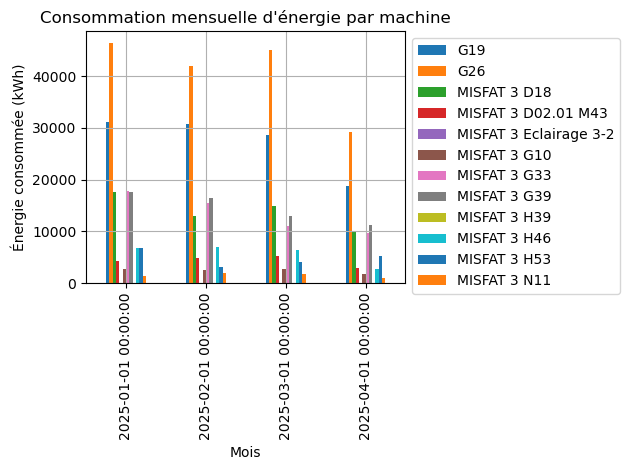

⚡ Énergie totale consommée par machine (en kWh) :

G26                       162436.375000
G19                       109158.109375
MISFAT 3 G39               58269.281250
MISFAT 3 D18               55514.125000
MISFAT 3 G33               53906.562500
MISFAT 3 H46               22633.100586
MISFAT 3 H53               19190.607910
MISFAT 3 D02.01 M43        17249.976562
MISFAT 3 G10                9723.359375
MISFAT 3 N11                6176.750000
MISFAT 3 Eclairage 3-2         0.000000
MISFAT 3 H39                   0.000000
dtype: float64


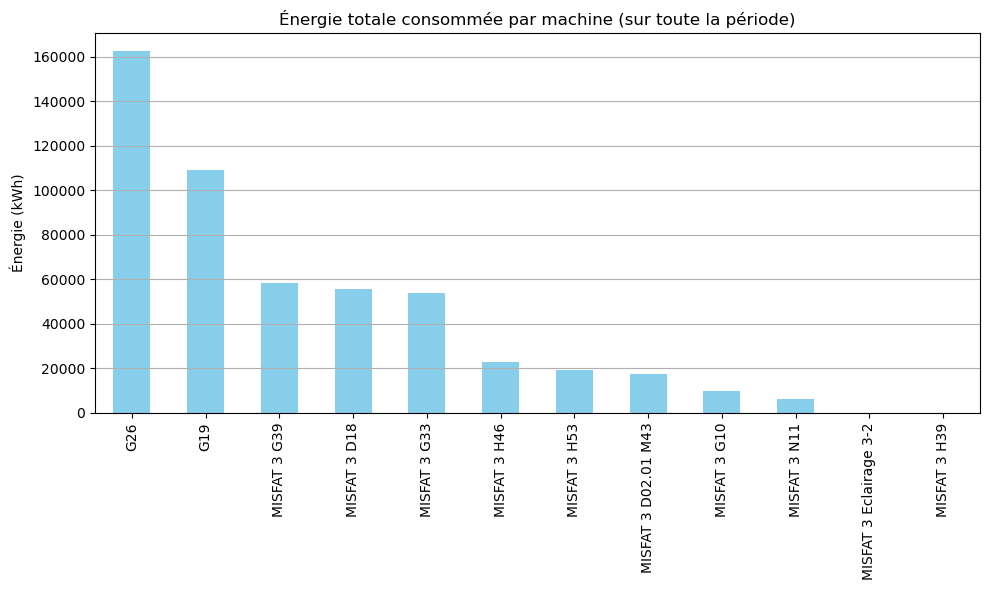

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Vérifier si l'index est bien datetime
if not pd.api.types.is_datetime64_any_dtype(df_cleaned.index):
    df_cleaned.index = pd.to_datetime(df_cleaned.index)

# 2. Créer la colonne 'YearMonth' pour grouper par mois
df_cleaned['YearMonth'] = df_cleaned.index.to_period('M')

# 3. Identifier les colonnes de machines (exclut juste YearMonth)
energy_columns = df_cleaned.columns.drop('YearMonth')

# 4. Grouper par mois et sommer les consommations
monthly_energy = df_cleaned.groupby('YearMonth')[energy_columns].sum()
monthly_energy.index = monthly_energy.index.to_timestamp()

# 5. Visualiser par mois et par machine (diagramme à barres groupées)
plt.figure(figsize=(16, 8))
monthly_energy.plot(kind='bar')
plt.title("Consommation mensuelle d'énergie par machine")
plt.xlabel("Mois")
plt.ylabel("Énergie consommée (kWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Calcul de la consommation totale sur toute la période
total_energy_kwh = df_cleaned[energy_columns].sum().sort_values(ascending=False)

# 7. Affichage des valeurs dans la console
print("⚡ Énergie totale consommée par machine (en kWh) :\n")
print(total_energy_kwh)

# 8. Visualisation en graphique (facultatif)
plt.figure(figsize=(10, 6))
total_energy_kwh.plot(kind='bar', color='skyblue')
plt.title("Énergie totale consommée par machine (sur toute la période)")
plt.ylabel("Énergie (kWh)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Bin 1: 0.00 à 3.76 => 136 occurrences
Bin 2: 3.76 à 7.52 => 97 occurrences
Bin 3: 7.52 à 11.28 => 271 occurrences
Bin 4: 11.28 à 15.03 => 179 occurrences
Bin 5: 15.03 à 18.79 => 51 occurrences
Bin 6: 18.79 à 22.55 => 17 occurrences
Bin 7: 22.55 à 26.31 => 12 occurrences
Bin 8: 26.31 à 30.07 => 13 occurrences
Bin 9: 30.07 à 33.83 => 29 occurrences
Bin 10: 33.83 à 37.58 => 42 occurrences
Bin 11: 37.58 à 41.34 => 45 occurrences
Bin 12: 41.34 à 45.10 => 85 occurrences
Bin 13: 45.10 à 48.86 => 64 occurrences
Bin 14: 48.86 à 52.62 => 39 occurrences
Bin 15: 52.62 à 56.38 => 30 occurrences
Bin 16: 56.38 à 60.13 => 39 occurrences
Bin 17: 60.13 à 63.89 => 29 occurrences
Bin 18: 63.89 à 67.65 => 33 occurrences
Bin 19: 67.65 à 71.41 => 43 occurrences
Bin 20: 71.41 à 75.17 => 45 occurrences
Bin 21: 75.17 à 78.92 => 57 occurrences
Bin 22: 78.92 à 82.68 => 74 occurrences
Bin 23: 82.68 à 86.44 => 74 occurrences
Bin 24: 86.44 à 90.20 => 110 occurrences
Bin 25: 90.20 à 93.96 => 296 occurrences
Bin 26: 9

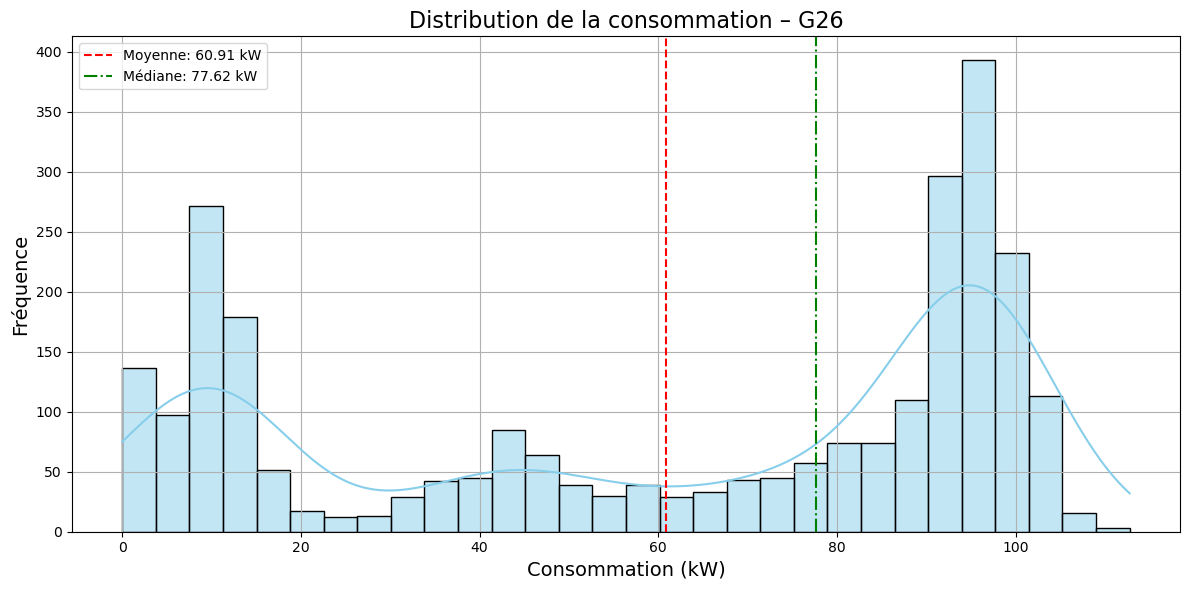

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 🔍 Machine à analyser
colonne = 'G26'

# Vérifie que la colonne existe bien
if colonne not in df_cleaned.columns:
    print(f"❌ La machine '{colonne}' n'existe pas dans df_cleaned.")
else:
    # Supprime les valeurs manquantes
    data = df_cleaned[colonne].dropna()

    # 🔢 Création de l'histogramme manuel
    counts, bin_edges = np.histogram(data, bins=30)

    # 🧾 Affiche les bords de chaque bin et le nombre d'occurrences
    for i in range(len(counts)):
        print(f"Bin {i+1}: {bin_edges[i]:.2f} à {bin_edges[i+1]:.2f} => {counts[i]} occurrences")

    # 📊 Affichage de la distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data, bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution de la consommation – {colonne}', fontsize=16)
    plt.xlabel('Consommation (kW)', fontsize=14)
    plt.ylabel('Fréquence', fontsize=14)
    plt.axvline(data.mean(), color='red', linestyle='--', label=f'Moyenne: {data.mean():.2f} kW')
    plt.axvline(data.median(), color='green', linestyle='-.', label=f'Médiane: {data.median():.2f} kW')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [22]:
# Extraire l'heure depuis l'index datetime
df_cleaned["heure"] = df_cleaned.index.hour

# Extraire le jour de la semaine (1 = Lundi, 7 = Dimanche)
df_cleaned["jour_semaine"] = df_cleaned.index.weekday + 1

# Afficher les premières lignes pour vérification
df_cleaned[["heure", "jour_semaine"]].head()


heure  jour_semaine
Timestamp                               
2025-01-01 00:00:00      0             3
2025-01-01 01:00:00      1             3
2025-01-01 02:00:00      2             3
2025-01-01 03:00:00      3             3
2025-01-01 04:00:00      4             3

In [23]:
df_cleaned.head()

G19  G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
Timestamp                                                          
2025-01-01 00:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 01:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 02:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 03:00:00  0.0  0.0           0.0                  0.0   
2025-01-01 04:00:00  0.0  0.0           0.0                  0.0   

                     MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  \
Timestamp                                                                 
2025-01-01 00:00:00                     0.0           0.0           0.0   
2025-01-01 01:00:00                     0.0           0.0           0.0   
2025-01-01 02:00:00                     0.0           0.0           0.0   
2025-01-01 03:00:00                     0.0           0.0           0.0   
2025-01-01 04:00:00                     0.0           0.0           0.0   

                     MISFAT 3 G39  MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  \
Timestamp                                                                     
2025-01-01 00:00:00           0.0           0.0           0.0           0.0   
2025-01-01 01:00:00           0.0           0.0           0.0           0.0   
2025-01-01 02:00:00           0.0           0.0           0.0           0.0   
2025-01-01 03:00:00           0.0           0.0           0.0           0.0   
2025-01-01 04:00:00           0.0           0.0           0.0           0.0   

                     MISFAT 3 N11 YearMonth  heure  jour_semaine  
Timestamp                                                         
2025-01-01 00:00:00           0.0   2025-01      0             3  
2025-01-01 01:00:00           0.0   2025-01      1             3  
2025-01-01 02:00:00           0.0   2025-01      2             3  
2025-01-01 03:00:00           0.0   2025-01      3             3  
2025-01-01 04:00:00           0.0   2025-01      4             3

In [24]:
# Extraire la date (jour uniquement) depuis l'index datetime
df_cleaned['jour_semaine'] = df_cleaned.index.date  # format YYYY-MM-DD
df_cleaned['heure'] = df_cleaned.index.hour         # heure (0 à 23)

# Sélectionner les colonnes de machines à analyser
colonnes_a_analyser = ['G19', 'G26', 'MISFAT 3 D18', 'MISFAT 3 D02.01 M43',
                       'MISFAT 3 Eclairage 3-2', 'MISFAT 3 G10', 'MISFAT 3 G33',
                       'MISFAT 3 G39', 'MISFAT 3 H39', 'MISFAT 3 H46',
                       'MISFAT 3 H53', 'MISFAT 3 N11']

# Grouper par jour (date) et calculer la médiane de consommation
mediane_par_jour = df_cleaned.groupby('jour_semaine')[colonnes_a_analyser].median()

# Afficher le résultat
mediane_par_jour


G19      G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
jour_semaine                                                           
2025-01-01      0.125000   0.3750       0.00000             0.093750   
2025-01-02     63.250000  82.1250      29.31250             1.617188   
2025-01-03    103.773438  93.5000      36.28125             4.796875   
2025-01-04     99.929688  84.0000      30.03125             0.140625   
2025-01-05      0.171875   8.7500       0.00000             0.156250   
...                  ...      ...           ...                  ...   
2025-04-18      4.468750  89.5625      28.56250             1.332031   
2025-04-19     25.781250  91.3750      26.62500             1.296875   
2025-04-20      3.187500   9.0000       0.00000             1.359375   
2025-04-21     89.312500  89.1250       0.00000             1.378906   
2025-04-22     12.406250  76.6250       0.00000             0.109375   

              MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  \
jour_semaine                                                       
2025-01-01                       0.0      0.000000      0.000000   
2025-01-02                       0.0      7.867432     54.525391   
2025-01-03                       0.0      7.779541     50.867188   
2025-01-04                       0.0      7.670654      5.394531   
2025-01-05                       0.0      0.000000      0.000000   
...                              ...           ...           ...   
2025-04-18                       0.0      7.178711      0.000000   
2025-04-19                       0.0      0.000000      0.000000   
2025-04-20                       0.0      0.000000      0.000000   
2025-04-21                       0.0      8.241699      0.000000   
2025-04-22                       0.0      0.000000      0.000000   

              MISFAT 3 G39  MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  \
jour_semaine                                                           
2025-01-01        0.000000           0.0      0.387207      2.700195   
2025-01-02       31.812500           0.0     11.356445     11.741211   
2025-01-03       38.875000           0.0     12.274902     10.947266   
2025-01-04       40.953125           0.0     11.625977     10.716797   
2025-01-05        0.000000           0.0      1.579102      6.080078   
...                    ...           ...           ...           ...   
2025-04-18       42.859375           0.0      0.000000     12.537598   
2025-04-19       41.937500           0.0      0.000000      9.874023   
2025-04-20        0.000000           0.0      0.000000      9.644531   
2025-04-21       39.984375           0.0      0.000000     11.490723   
2025-04-22       42.468750           0.0      0.000000     12.699219   

              MISFAT 3 N11  
jour_semaine                
2025-01-01        0.000000  
2025-01-02        0.000000  
2025-01-03        0.000000  
2025-01-04        3.171875  
2025-01-05        0.000000  
...                    ...  
2025-04-18        0.000000  
2025-04-19        0.000000  
2025-04-20        0.000000  
2025-04-21        0.000000  
2025-04-22        0.000000  

[112 rows x 12 columns]

In [25]:
# Ajouter une colonne "semaine" depuis l'index datetime
df_cleaned['semaine'] = df_cleaned.index.isocalendar().week

# Sélectionner les colonnes spécifiques à analyser
colonnes = ['G19', 'G26', 'MISFAT 3 D18', 'MISFAT 3 D02.01 M43', 'MISFAT 3 Eclairage 3-2',
            'MISFAT 3 G10', 'MISFAT 3 G33', 'MISFAT 3 G39', 'MISFAT 3 H39',
            'MISFAT 3 H46', 'MISFAT 3 H53', 'MISFAT 3 N11']

# Calculer la médiane hebdomadaire pour chaque machine
mediane_par_semaine = df_cleaned.groupby('semaine')[colonnes].median()

# Afficher les résultats
mediane_par_semaine


G19      G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
semaine                                                          
1         8.070312  38.5000      25.53125             0.156250   
2        29.828125  90.6250      30.96875             1.578125   
3        20.187500  88.0625      30.40625             0.117188   
4        15.914062  85.1250      29.84375             1.476562   
5        10.617188  43.8750      30.31250             1.414062   
6        11.546875  92.1250      32.09375             5.652344   
7        10.195312  41.9375      28.78125             3.375000   
8        62.062500  85.4375      23.21875             1.562500   
9        41.132812  91.5000       0.75000             1.429688   
10       42.734375  67.6875      28.31250             1.468750   
11       41.187500  89.3750      29.03125             1.433594   
12        8.156250  71.7500      26.71875             1.453125   
13        8.421875  89.3125      29.34375             1.550781   
14        8.750000  14.0000       0.00000             1.476562   
15        6.218750  70.3125      30.28125             1.375000   
16       28.031250  87.7500      27.75000             1.343750   
17       34.656250  81.8750       0.00000             1.375000   

         MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  MISFAT 3 G39  \
semaine                                                                     
1                           0.0      0.000000      0.000000      1.437500   
2                           0.0      2.618896      7.763672     37.906250   
3                           0.0      2.391602     20.845703     38.828125   
4                           0.0      6.894287     16.146484     39.984375   
5                           0.0      0.000000      0.000000      1.687500   
6                           0.0      0.000000     17.898438      1.500000   
7                           0.0      0.000000     31.273438     39.000000   
8                           0.0      1.545410      2.078125     37.875000   
9                           0.0      0.000000      1.156250     38.093750   
10                          0.0      2.142090      0.000000     35.156250   
11                          0.0      0.000977      0.000000     21.843750   
12                          0.0      0.000000      0.000000      1.546875   
13                          0.0      2.474121      0.000000      1.000000   
14                          0.0      0.000000      0.000000      0.000000   
15                          0.0      0.000977     12.417969     37.234375   
16                          0.0      0.000000      0.007812     38.343750   
17                          0.0      0.000000      0.000000     40.375000   

         MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  MISFAT 3 N11  
semaine                                                          
1                 0.0      9.958008      6.573242           0.0  
2                 0.0     10.940430     11.005859           0.0  
3                 0.0     11.910156     10.462891           0.0  
4                 0.0     11.839844      9.743164           0.0  
5                 0.0     10.468750      8.880859           0.0  
6                 0.0     12.192383     10.109375           0.0  
7                 0.0     12.646484      9.071289           0.0  
8                 0.0     13.061523      0.000000           0.0  
9                 0.0     12.957031      0.000000           0.0  
10                0.0     11.826172      0.000000           0.0  
11                0.0     10.699219      0.000000           0.0  
12                0.0     10.234375      9.337402           0.0  
13                0.0     10.216797      9.269531           0.0  
14                0.0      1.230469      9.195312           0.0  
15                0.0     10.919922     10.723633           0.0  
16                0.0      0.000000     11.798828           0.0  
17                0.0      0.000000     12.138672           0.0

In [26]:
# Ajouter une colonne "mois" à partir de l'index datetime
df_cleaned['mois'] = df_cleaned.index.month

# Sélectionner les colonnes à analyser
cols = ['G19', 'G26', 'MISFAT 3 D18', 'MISFAT 3 D02.01 M43', 'MISFAT 3 Eclairage 3-2',
        'MISFAT 3 G10', 'MISFAT 3 G33', 'MISFAT 3 G39', 'MISFAT 3 H39',
        'MISFAT 3 H46', 'MISFAT 3 H53', 'MISFAT 3 N11']

# Grouper par mois et calculer la médiane
mediane_par_mois = df_cleaned.groupby('mois')[cols].median()

# Afficher les résultats
mediane_par_mois


G19      G26  MISFAT 3 D18  MISFAT 3 D02.01 M43  \
mois                                                          
1     22.585938  78.8750      30.62500             1.093750   
2     33.703125  84.2500      27.75000             1.625000   
3      8.218750  75.9375      27.28125             1.468750   
4      9.656250  70.0000      28.00000             1.390625   

      MISFAT 3 Eclairage 3-2  MISFAT 3 G10  MISFAT 3 G33  MISFAT 3 G39  \
mois                                                                     
1                        0.0      0.000732      5.773438      37.18750   
2                        0.0      0.000000      4.945312      37.28125   
3                        0.0      0.000000      0.000000       7.46875   
4                        0.0      0.000000      0.000000      31.87500   

      MISFAT 3 H39  MISFAT 3 H46  MISFAT 3 H53  MISFAT 3 N11  
mois                                                          
1              0.0     11.266602      9.977539           0.0  
2              0.0     12.637695      5.203125           0.0  
3              0.0     10.515625      8.484863           0.0  
4              0.0      1.226562     10.981445           0.0

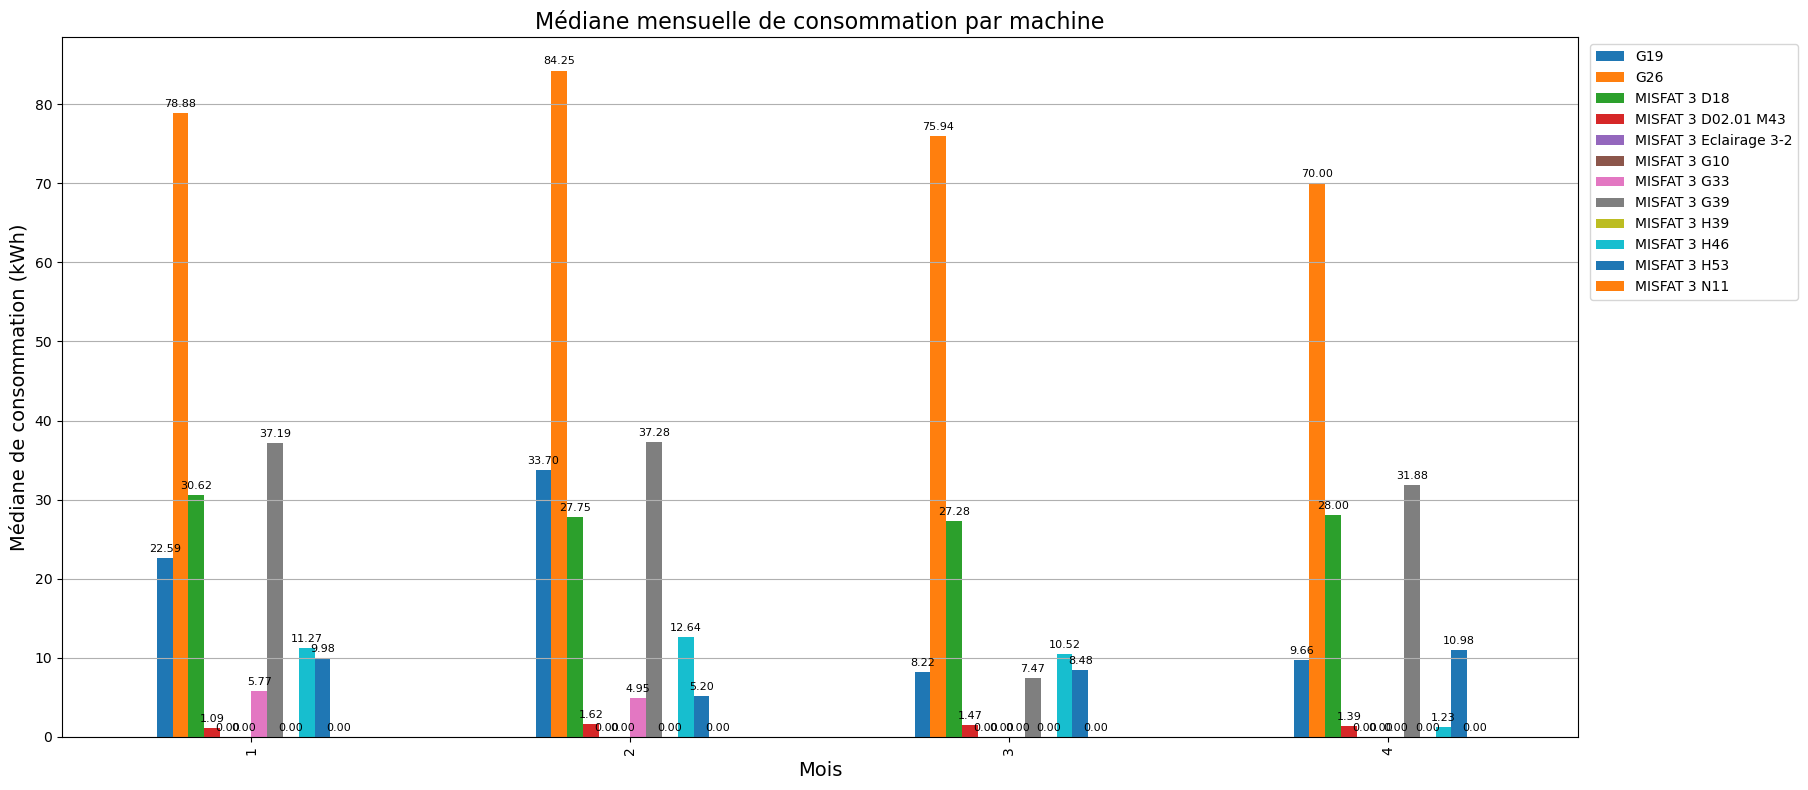

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 8))
bars = mediane_par_mois.plot(kind='bar', ax=ax)

plt.title("Médiane mensuelle de consommation par machine", fontsize=16)
plt.xlabel("Mois", fontsize=14)
plt.ylabel("Médiane de consommation (kWh)", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(axis='y')
plt.tight_layout()

# 🔢 Affichage des valeurs au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, label_type='edge', padding=3)

plt.show()


In [28]:
df_cleaned["jour_semaine"] = df_cleaned.index.weekday + 1
df_cleaned["jour_semaine"] = df_cleaned["jour_semaine"].astype(int)


In [29]:
# 🛠️ Paramètres
seuil_arret = 0.1
duree_min_arret = 2

# 📋 Liste des machines
machines = ['G19', 'G26', 'MISFAT 3 D18', 'MISFAT 3 D02.01 M43',
            'MISFAT 3 Eclairage 3-2', 'MISFAT 3 G10', 'MISFAT 3 G33',
            'MISFAT 3 G39', 'MISFAT 3 H39', 'MISFAT 3 H46',
            'MISFAT 3 H53', 'MISFAT 3 N11']

# 📦 DataFrame final
tous_arrets_anormaux = pd.DataFrame()

for machine in machines:
    print(f"🔍 Analyse de la machine : {machine}")

    arrets = df_cleaned[machine] <= seuil_arret
    arrets = arrets.astype(int)
    arrets_diff = arrets.diff().fillna(0)

    debut_arret = arrets_diff[arrets_diff == 1].index
    fin_arret = arrets_diff[arrets_diff == -1].index

    if arrets.iloc[0] == 1:
        debut_arret = debut_arret.insert(0, df_cleaned.index[0])
    if len(fin_arret) < len(debut_arret):
        fin_arret = fin_arret.insert(len(fin_arret), df_cleaned.index[-1])

    arrets_detectes = pd.DataFrame({
        'Début arrêt': debut_arret,
        'Fin arrêt': fin_arret
    })

    arrets_detectes['Durée arrêt (heures)'] = (arrets_detectes['Fin arrêt'] - arrets_detectes['Début arrêt']).dt.total_seconds() / 3600

    # 🚨 Correction ici : .copy()
    arrets_anormaux = arrets_detectes[arrets_detectes['Durée arrêt (heures)'] > duree_min_arret].copy()
    arrets_anormaux['Machine'] = machine

    tous_arrets_anormaux = pd.concat([tous_arrets_anormaux, arrets_anormaux], ignore_index=True)

# 🎯 Résultat
display(tous_arrets_anormaux[['Machine', 'Début arrêt', 'Fin arrêt', 'Durée arrêt (heures)']])


🔍 Analyse de la machine : G19
🔍 Analyse de la machine : G26
🔍 Analyse de la machine : MISFAT 3 D18
🔍 Analyse de la machine : MISFAT 3 D02.01 M43
🔍 Analyse de la machine : MISFAT 3 Eclairage 3-2
🔍 Analyse de la machine : MISFAT 3 G10
🔍 Analyse de la machine : MISFAT 3 G33
🔍 Analyse de la machine : MISFAT 3 G39
🔍 Analyse de la machine : MISFAT 3 H39
🔍 Analyse de la machine : MISFAT 3 H46
🔍 Analyse de la machine : MISFAT 3 H53
🔍 Analyse de la machine : MISFAT 3 N11


Machine         Début arrêt           Fin arrêt  \
0             G19 2025-01-01 00:00:00 2025-01-01 10:00:00   
1             G19 2025-01-17 03:00:00 2025-01-17 08:00:00   
2             G19 2025-04-04 00:00:00 2025-04-04 08:00:00   
3             G26 2025-01-01 00:00:00 2025-01-01 09:00:00   
4             G26 2025-01-17 03:00:00 2025-01-17 08:00:00   
..            ...                 ...                 ...   
429  MISFAT 3 N11 2025-04-16 14:00:00 2025-04-17 07:00:00   
430  MISFAT 3 N11 2025-04-17 14:00:00 2025-04-18 07:00:00   
431  MISFAT 3 N11 2025-04-18 14:00:00 2025-04-19 06:00:00   
432  MISFAT 3 N11 2025-04-19 14:00:00 2025-04-21 07:00:00   
433  MISFAT 3 N11 2025-04-21 17:00:00 2025-04-22 07:00:00   

     Durée arrêt (heures)  
0                    10.0  
1                     5.0  
2                     8.0  
3                     9.0  
4                     5.0  
..                    ...  
429                  17.0  
430                  17.0  
431                  16.0  
432                  41.0  
433                  14.0  

[434 rows x 4 columns]

In [30]:
import time
from datetime import datetime, timedelta

def surveiller_machines_automatique(df_arrets, sender_email, sender_password, receiver_email, frequence_verification_minutes=5):
    """
    Surveille en temps réel toutes les machines arrêtées et envoie un mail toutes les 2h d'arrêt prolongé.
    """
    deja_alerte = {}  # Pour garder en mémoire les heures déjà alertées par machine

    while True:
        now = datetime.now()

        for index, row in df_arrets.iterrows():
            machine_name = row['machine']
            start_time = row['start_time']
            end_time = row['end_time']

            # Si la machine est encore arrêtée à maintenant
            if start_time <= now <= end_time:
                heures_ecoulees = int((now - start_time).total_seconds() / 3600)

                # On alerte toutes les 2 heures (2h, 4h, 6h, etc.)
                if heures_ecoulees > 0 and heures_ecoulees % 2 == 0:
                    dernier_alerte = deja_alerte.get((machine_name, heures_ecoulees), False)

                    if not dernier_alerte:
                        envoyer_mail_arret_machine(
                            machine_name=machine_name,
                            start_time=start_time,
                            hours_stopped=heures_ecoulees,
                            sender_email=sender_email,
                            sender_password=sender_password,
                            receiver_email=receiver_email
                        )
                        deja_alerte[(machine_name, heures_ecoulees)] = True
        
        # Attendre avant la prochaine vérification
        time.sleep(frequence_verification_minutes * 60)


In [31]:
from datetime import datetime, timedelta

# Exemple de liste des arrêts de machines
machines_arrets = [
    {"machine": "G19", "start_time": datetime(2025, 1, 1, 0, 0, 0), "end_time": datetime(2025, 1, 1, 10, 0, 0)},
    {"machine": "G26", "start_time": datetime(2025, 1, 1, 2, 0, 0), "end_time": datetime(2025, 1, 1, 7, 0, 0)},
    {"machine": " MISFAT 3 D18", "start_time": datetime(2025, 1, 1, 5, 0, 0), "end_time": datetime(2025, 1, 1, 12, 0, 0)}
]

# Paramètres d'envoi
sender_email = "mahamokrani7@gmail.com"
sender_password = "sdcrojblkjvrkazt"
receiver_email = "mahamokrani7@gmail.com"

# Fonction pour surveiller toutes les machines et envoyer les mails
def surveiller_toutes_les_machines(machines_arrets, sender_email, sender_password, receiver_email):
    for machine_info in machines_arrets:
        machine_name = machine_info["machine"]
        start_time = machine_info["start_time"]
        end_time = machine_info["end_time"]

        current_time = start_time + timedelta(hours=2)
        while current_time <= end_time:
            hours_stopped = int((current_time - start_time).total_seconds() / 3600)
            if hours_stopped % 2 == 0:  # Seulement toutes les 2h
                envoyer_mail_arret_machine(
                    machine_name=machine_name,
                    start_time=start_time,
                    hours_stopped=hours_stopped,
                    sender_email=sender_email,
                    sender_password=sender_password,
                    receiver_email=receiver_email
                )
            current_time += timedelta(hours=2)

# 🛎 Lancement de la surveillance
surveiller_toutes_les_machines(machines_arrets, sender_email, sender_password, receiver_email)


✅ Email envoyé pour G19 arrêtée depuis 2h.
✅ Email envoyé pour G19 arrêtée depuis 4h.
✅ Email envoyé pour G19 arrêtée depuis 6h.
✅ Email envoyé pour G19 arrêtée depuis 8h.
✅ Email envoyé pour G19 arrêtée depuis 10h.
✅ Email envoyé pour G26 arrêtée depuis 2h.
✅ Email envoyé pour G26 arrêtée depuis 4h.
✅ Email envoyé pour  MISFAT 3 D18 arrêtée depuis 2h.
✅ Email envoyé pour  MISFAT 3 D18 arrêtée depuis 4h.
✅ Email envoyé pour  MISFAT 3 D18 arrêtée depuis 6h.


modeles avec test_overfetting


🔧 Traitement de la machine : G19


22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing


✅ G19 | MAE_test: 303.75 | RMSE: 396.62 | Overfitting: Non


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


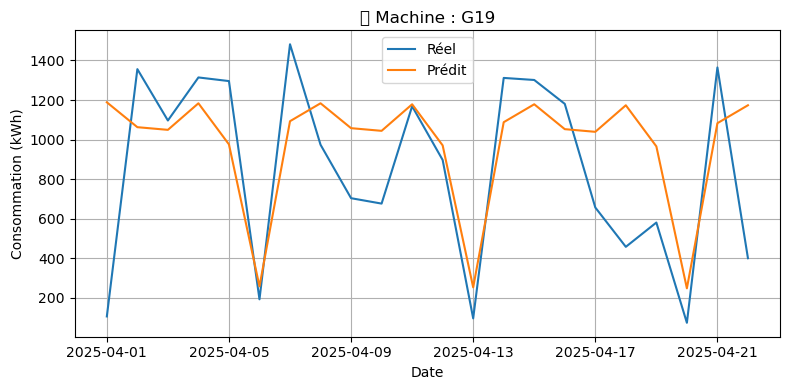


🔧 Traitement de la machine : G26


22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:23 - cmdstanpy - INFO - Chain [1] done processing


✅ G26 | MAE_test: 359.70 | RMSE: 531.33 | Overfitting: Non


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


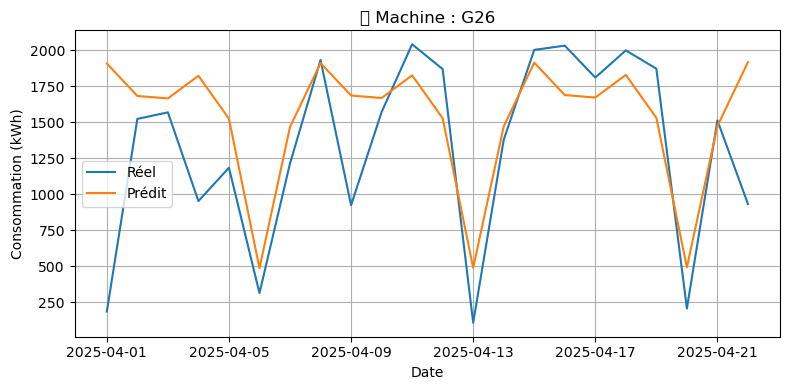


🔧 Traitement de la machine : MISFAT 3 D18


22:12:37 - cmdstanpy - INFO - Chain [1] start processing
22:12:37 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 D18 | MAE_test: 156.29 | RMSE: 202.44 | Overfitting: Oui


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


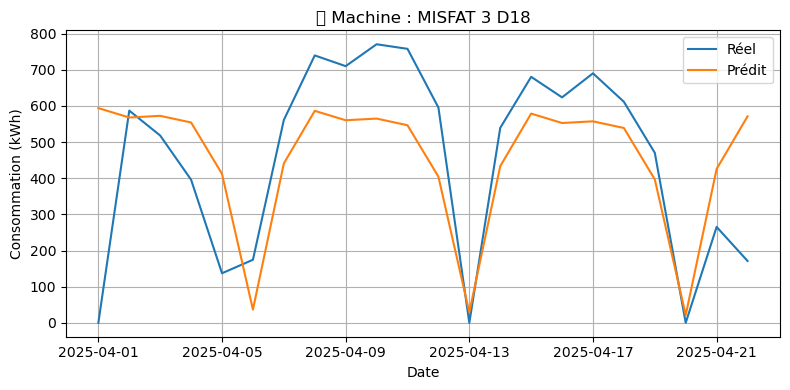


🔧 Traitement de la machine : MISFAT 3 D02.01 M43


22:12:51 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 D02.01 M43 | MAE_test: 65.76 | RMSE: 87.01 | Overfitting: Non


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


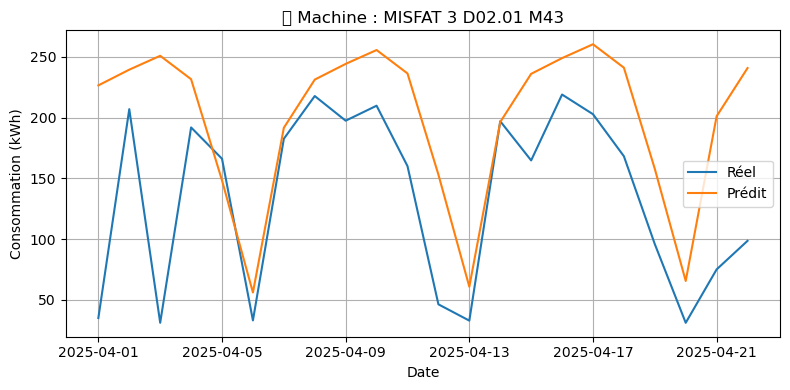


🔧 Traitement de la machine : MISFAT 3 Eclairage 3-2
✅ MISFAT 3 Eclairage 3-2 | MAE_test: 0.00 | RMSE: 0.00 | Overfitting: Non


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


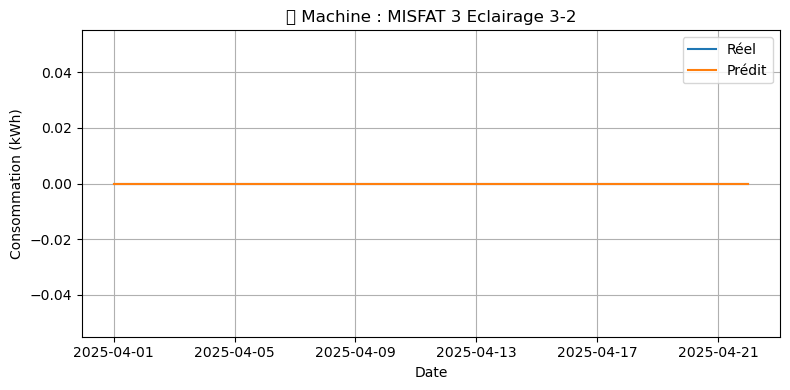


🔧 Traitement de la machine : MISFAT 3 G10


22:13:17 - cmdstanpy - INFO - Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 G10 | MAE_test: 36.71 | RMSE: 48.22 | Overfitting: Oui


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


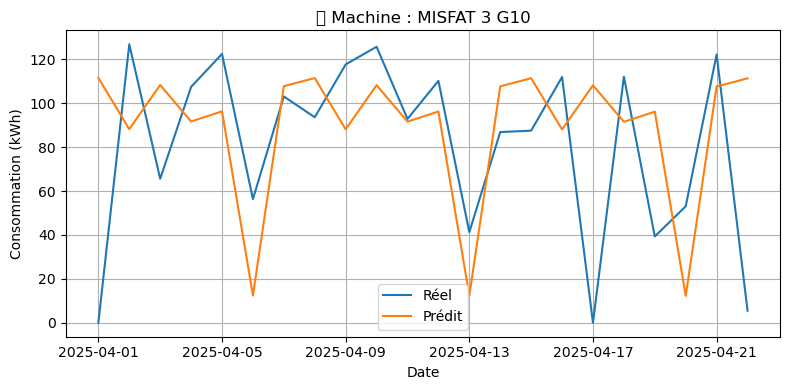


🔧 Traitement de la machine : MISFAT 3 G33


22:13:30 - cmdstanpy - INFO - Chain [1] start processing
22:13:31 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 G33 | MAE_test: 221.99 | RMSE: 312.87 | Overfitting: Non


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


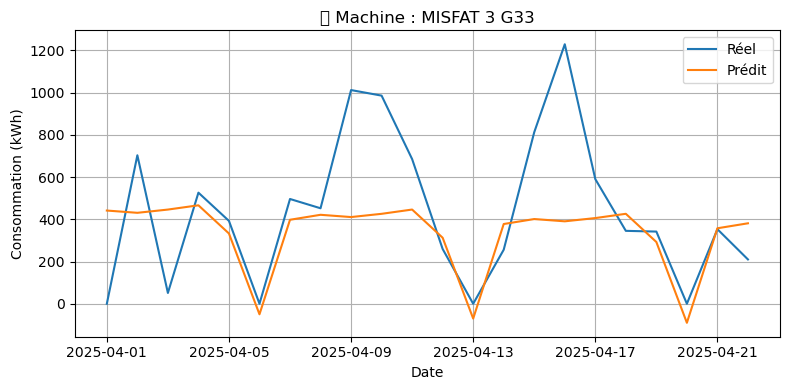


🔧 Traitement de la machine : MISFAT 3 G39


22:13:42 - cmdstanpy - INFO - Chain [1] start processing
22:13:43 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 G39 | MAE_test: 233.67 | RMSE: 287.49 | Overfitting: Oui


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


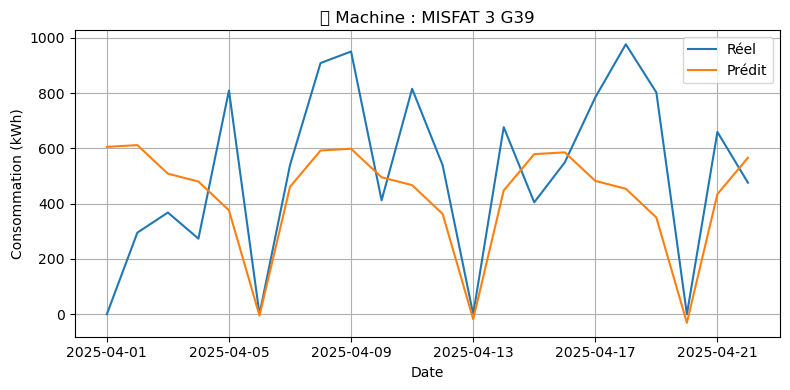


🔧 Traitement de la machine : MISFAT 3 H39
✅ MISFAT 3 H39 | MAE_test: 0.00 | RMSE: 0.00 | Overfitting: Non


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


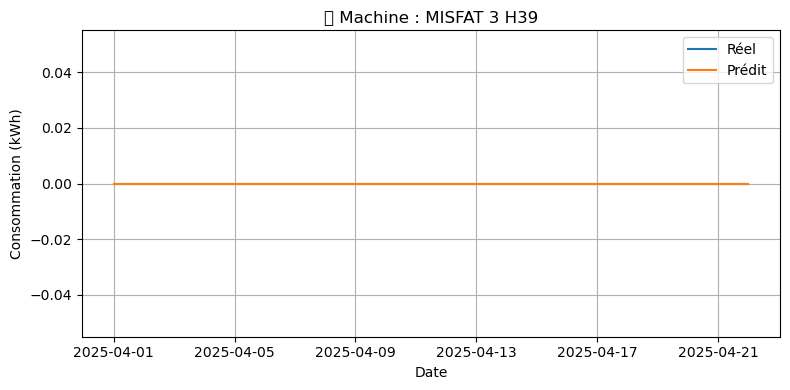


🔧 Traitement de la machine : MISFAT 3 H46


22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:08 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 H46 | MAE_test: 110.65 | RMSE: 148.75 | Overfitting: Oui


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


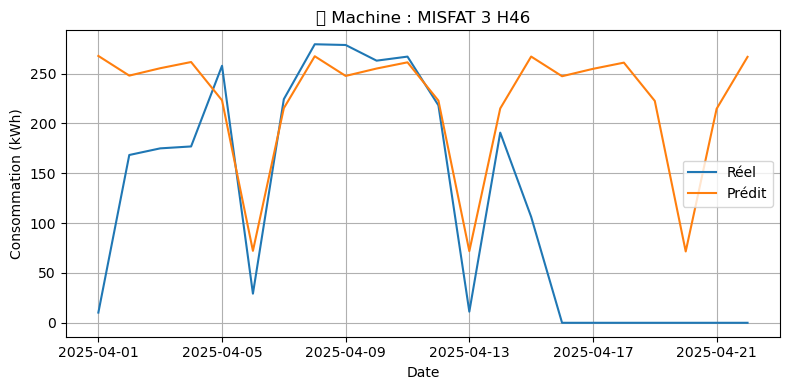


🔧 Traitement de la machine : MISFAT 3 H53


22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 H53 | MAE_test: 155.40 | RMSE: 163.68 | Overfitting: Oui


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


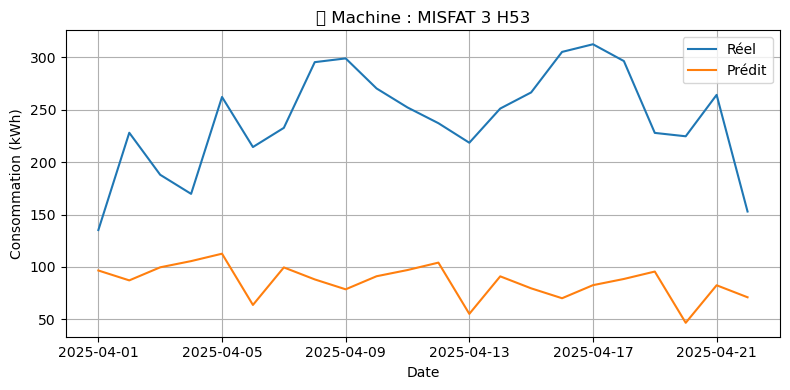


🔧 Traitement de la machine : MISFAT 3 N11


22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing


✅ MISFAT 3 N11 | MAE_test: 29.78 | RMSE: 36.39 | Overfitting: Non


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\1990774783.py:108: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


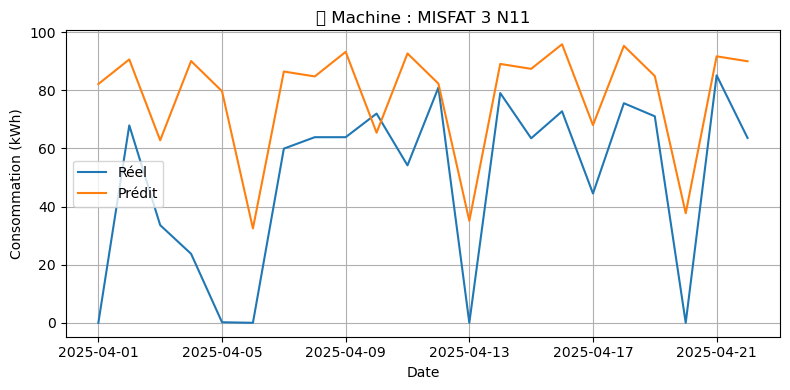


📊 Scores par machine :
                   Machine    MAE_test   RMSE_test       MSE_test   MAE_train  \
0                      G19  303.745100  396.621908  157308.937675  319.389461   
1                      G26  359.696795  531.331672  282313.345289  398.315201   
2             MISFAT 3 D18  156.288598  202.436803   40980.659187  128.141126   
3      MISFAT 3 D02.01 M43   65.757075   87.013872    7571.413853   93.037164   
4   MISFAT 3 Eclairage 3-2    0.000000    0.000000       0.000000    0.000000   
5             MISFAT 3 G10   36.706666   48.217569    2324.933951   27.922433   
6             MISFAT 3 G33  221.986528  312.867093   97885.817631  209.645697   
7             MISFAT 3 G39  233.665091  287.486806   82648.663848  185.879759   
8             MISFAT 3 H39    0.000000    0.000000       0.000000    0.000000   
9             MISFAT 3 H46  110.651150  148.745944   22125.355844   48.985147   
10            MISFAT 3 H53  155.401425  163.682971   26792.115087  113.498326   
11  

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Paramètres
mode_decoupage = "date"
date_split = '2025-04-01'

all_results = []
scores = []

for machine in df.columns:
    try:
        print(f"\n🔧 Traitement de la machine : {machine}")
        
        # 1. Préparation des données
        df_machine = df[[machine]].copy().resample('D').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna()

        if len(df_machine) < 15:
            print(f"⚠️ Machine {machine} ignorée (pas assez de données)")
            continue

        df_machine['ds'] = df_machine.index

        # 2. Split train/test
        if mode_decoupage == "date":
            train = df_machine[df_machine['ds'] < date_split]
            test = df_machine[df_machine['ds'] >= date_split]
        else:
            split_index = int(len(df_machine) * 0.8)
            train = df_machine.iloc[:split_index]
            test = df_machine.iloc[split_index:]

        if len(test) < 2 or len(train) < 10:
            print(f"⚠️ Machine {machine} ignorée (fenêtre train/test insuffisante)")
            continue

        # 3. Entraînement
        model = Prophet(daily_seasonality=True)
        model.fit(train[['ds', 'y']])

        # 4. Prédiction
        future = model.make_future_dataframe(periods=len(test), freq='D', include_history=False)
        forecast = model.predict(future)

        # 5. Résultats prédiction
        y_true = test['y'].values
        y_pred = forecast['yhat'].values
        dates = test['ds'].values

        df_result = pd.DataFrame({
            'Timestamp': dates,
            'Jour': test['ds'].dt.day_name(),
            'Machine': machine,
            'Consommation_réelle_(kWh)': y_true,
            'Consommation_prédite_jour_suivant_(kWh)': y_pred
        })
        all_results.append(df_result)

        # 6. Validation croisée
        try:
            df_cv = cross_validation(model, initial='30 days', period='7 days', horizon='7 days', parallel="processes")
            df_perf = performance_metrics(df_cv)
            mae_train = df_perf['mae'].mean()
        except Exception as e_cv:
            print(f"⚠️ Échec validation croisée pour {machine} : {e_cv}")
            mae_train = np.nan

        # 7. Scores test
        mae_test = mean_absolute_error(y_true, y_pred)
        mse_test = mean_squared_error(y_true, y_pred)
        rmse_test = np.sqrt(mse_test)
        r2 = r2_score(y_true, y_pred)

        # 8. Détection d'overfitting
        if not np.isnan(mae_train):
            overfitting = "Oui" if mae_test > mae_train * 1.2 else "Non"
        else:
            overfitting = "Inconnu"

        scores.append({
            'Machine': machine,
            'MAE_test': mae_test,
            'MSE_test': mse_test,
            'RMSE_test': rmse_test,
            'MAE_train': mae_train,
            'R2_test': r2,
            'Overfitting': overfitting
        })

        # 9. Affichage
        print(f"✅ {machine} | MAE_test: {mae_test:.2f} | RMSE: {rmse_test:.2f} | Overfitting: {overfitting}")

        # 10. Courbes
        plt.figure(figsize=(8, 4))
        plt.plot(dates, y_true, label='Réel')
        plt.plot(dates, y_pred, label='Prédit')
        plt.title(f"🔌 Machine : {machine}")
        plt.xlabel("Date")
        plt.ylabel("Consommation (kWh)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} : {e}")

# Résumé global
if all_results and scores:
    df_previsions = pd.concat(all_results, ignore_index=True)
    df_scores = pd.DataFrame(scores)

    # Affichage scores par machine
    print("\n📊 Scores par machine :")
    colonnes_a_afficher = ['Machine', 'MAE_test', 'RMSE_test', 'MSE_test', 'MAE_train', 'R2_test', 'Overfitting']
    print(df_scores[colonnes_a_afficher])

    print("\n🔍 Exemple de prévisions :")
    print(df_previsions.head())

    # Scores globaux
    y_true_global = df_previsions['Consommation_réelle_(kWh)']
    y_pred_global = df_previsions['Consommation_prédite_jour_suivant_(kWh)']

    mae_global_pr = mean_absolute_error(y_true_global, y_pred_global)
    mse_global_pr = mean_squared_error(y_true_global, y_pred_global)
    rmse_global_pr = np.sqrt(mse_global_pr)
    r2_global_pr = r2_score(y_true_global, y_pred_global)

    mae_train_global = df_scores['MAE_train'].mean(skipna=True)
    overfitting_global = "Oui" if mae_global_pr > mae_train_global * 1.2 else "Non"

    print("\n🌍 Scores globaux du modèle Prophet :")
    print(f"🔸 MAE global test       : {mae_global_pr:.2f} kWh")
    print(f"🔸 RMSE global test      : {rmse_global_pr:.2f} kWh")
    print(f"🔸 MSE global test       : {mse_global_pr:.2f} kWh")
    print(f"🔸 MAE global train      : {mae_train_global:.2f} kWh")
    print(f"🔸 R² global             : {r2_global_pr:.3f}")
    print(f"🔍 Overfitting global    : {overfitting_global}")

else:
    print("⚠️ Aucun score ou résultat à afficher.")


In [37]:
df_previsions.head()

Timestamp       Jour Machine  Consommation_réelle_(kWh)  \
0 2025-04-01    Tuesday     G19                  106.71875   
1 2025-04-02  Wednesday     G19                 1355.93750   
2 2025-04-03   Thursday     G19                 1096.56250   
3 2025-04-04     Friday     G19                 1314.03125   
4 2025-04-05   Saturday     G19                 1295.65625   

   Consommation_prédite_jour_suivant_(kWh)  
0                              1188.503137  
1                              1062.778869  
2                              1049.301425  
3                              1183.431066  
4                               975.794919


🔧 Machine : G19


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


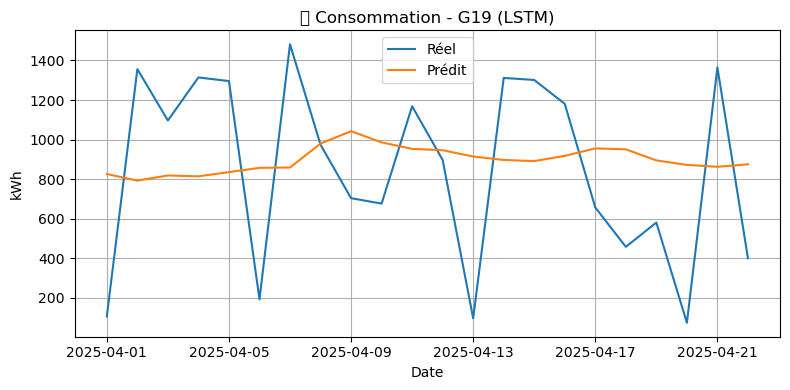

✅ MAE_train: 336.67 | MAE_test: 432.16 | Overfitting: Oui

🔧 Machine : G26


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


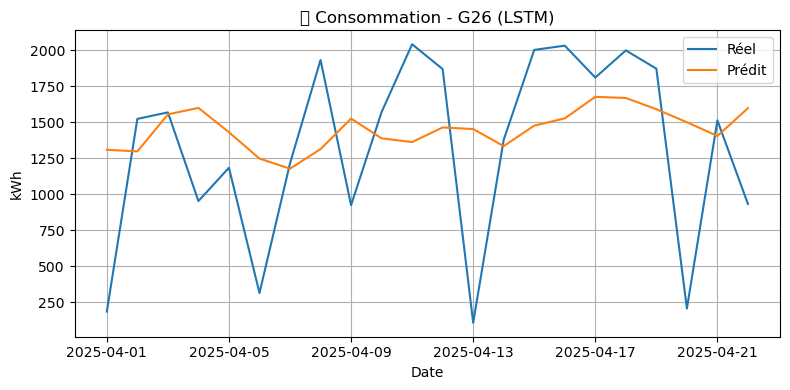

✅ MAE_train: 461.67 | MAE_test: 497.26 | Overfitting: Non

🔧 Machine : MISFAT 3 D18


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


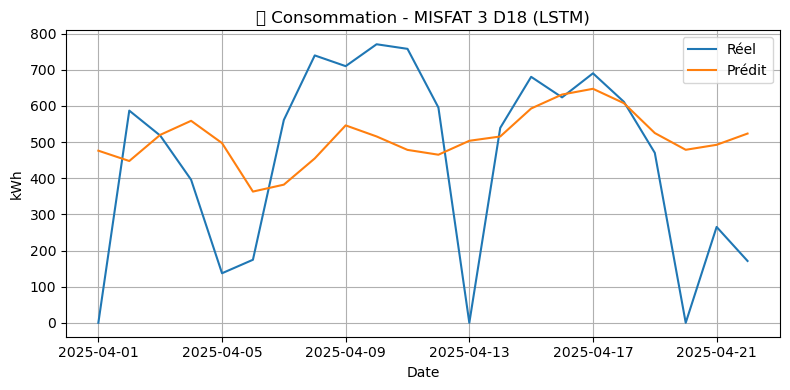

✅ MAE_train: 150.52 | MAE_test: 200.21 | Overfitting: Oui

🔧 Machine : MISFAT 3 D02.01 M43


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


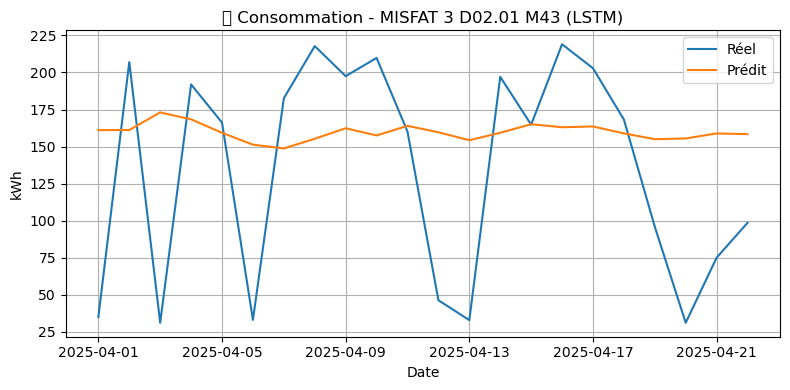

✅ MAE_train: 96.20 | MAE_test: 61.54 | Overfitting: Non

🔧 Machine : MISFAT 3 Eclairage 3-2


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


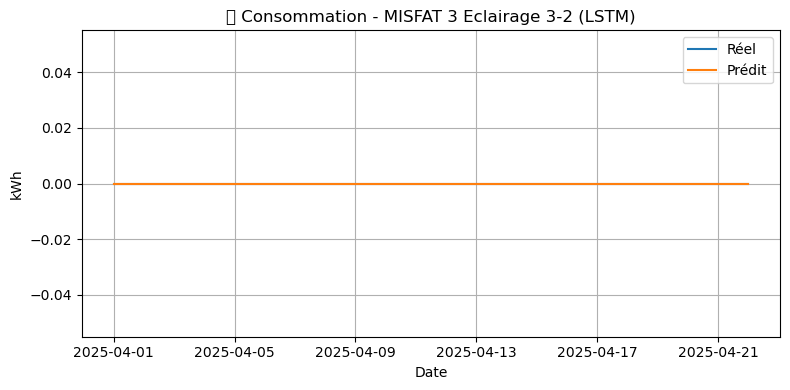

C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ MAE_train: 0.00 | MAE_test: 0.00 | Overfitting: Non

🔧 Machine : MISFAT 3 G10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


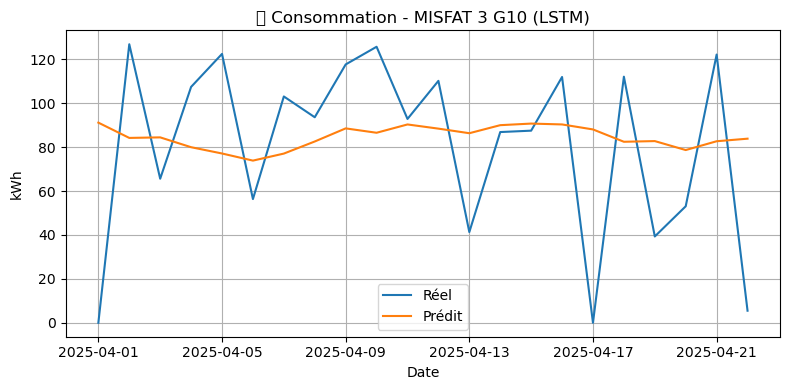

✅ MAE_train: 36.06 | MAE_test: 34.09 | Overfitting: Non

🔧 Machine : MISFAT 3 G33


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


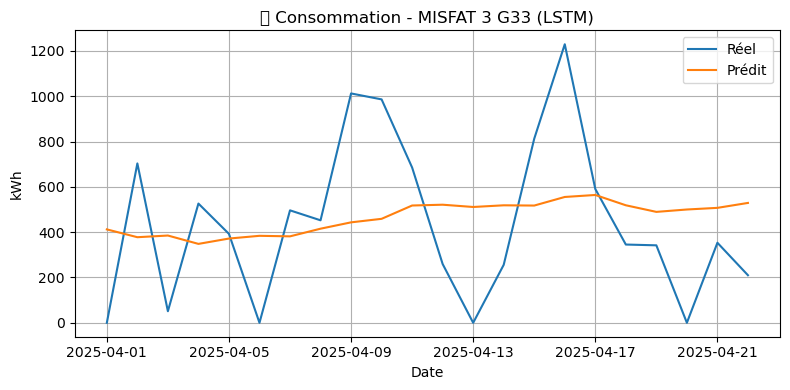

✅ MAE_train: 224.76 | MAE_test: 290.64 | Overfitting: Oui

🔧 Machine : MISFAT 3 G39


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


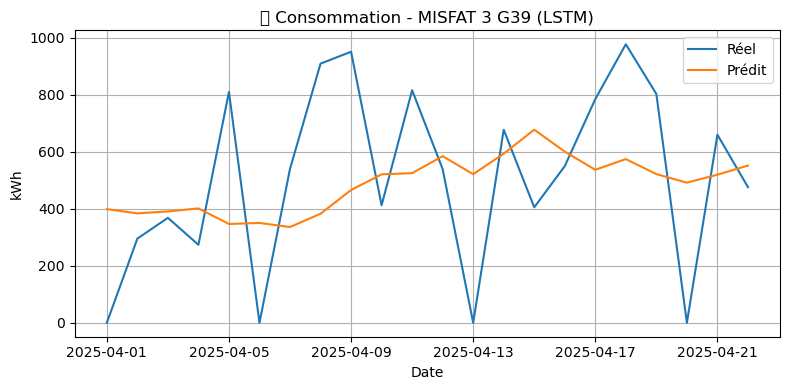

✅ MAE_train: 206.26 | MAE_test: 257.91 | Overfitting: Oui

🔧 Machine : MISFAT 3 H39


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


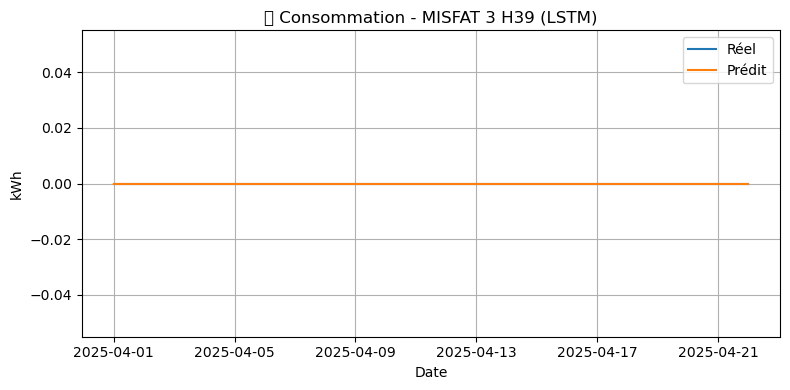

✅ MAE_train: 0.00 | MAE_test: 0.00 | Overfitting: Non

🔧 Machine : MISFAT 3 H46


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


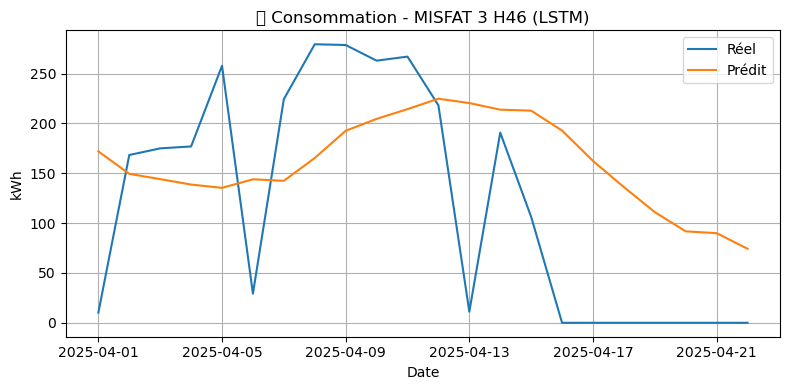

✅ MAE_train: 58.36 | MAE_test: 94.70 | Overfitting: Oui

🔧 Machine : MISFAT 3 H53


C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


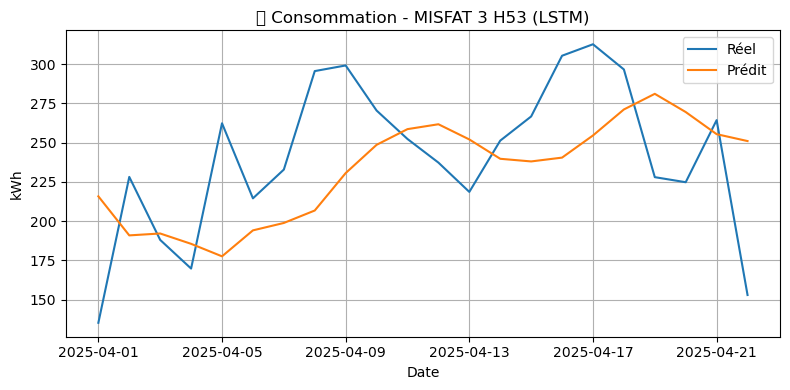

C:\Users\ameni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ MAE_train: 36.17 | MAE_test: 41.51 | Overfitting: Non

🔧 Machine : MISFAT 3 N11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 


C:\Users\ameni\AppData\Local\Temp\ipykernel_20648\3812932279.py:112: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ameni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128268 (\N{ELECTRIC PLUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


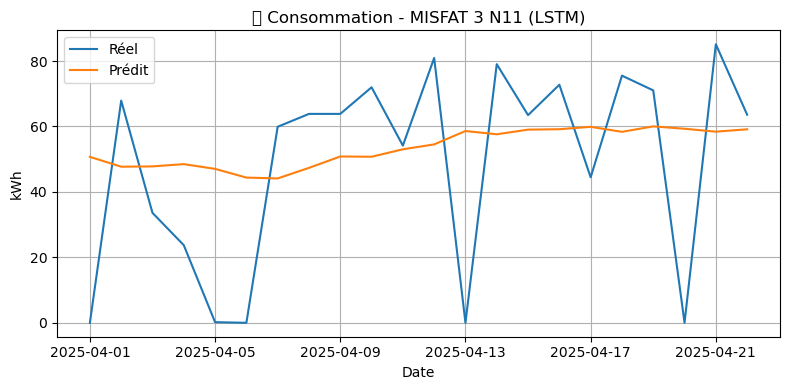

✅ MAE_train: 39.74 | MAE_test: 23.97 | Overfitting: Non

🌍 Scores globaux (LSTM) :
🔸 MAE global test   : 161.17
🔸 MAE global train  : 137.20
🔸 RMSE global       : 277.98
🔸 R² global         : 0.6546
🔍 Overfitting global : Non

📈 Scores par machine (LSTM) :
               Machine  MAE_train   MAE_test  RMSE_test        R2 Overfitting
                   G19 336.672431 432.156991 480.560662 -0.079327         Oui
                   G26 461.671129 497.258700 630.145739  0.013119         Non
          MISFAT 3 D18 150.523225 200.205249 253.154542  0.045537         Oui
   MISFAT 3 D02.01 M43  96.195651  61.535325  75.356666 -0.108335         Non
MISFAT 3 Eclairage 3-2   0.000000   0.000000   0.000000  1.000000         Non
          MISFAT 3 G10  36.056520  34.090898  41.904915 -0.045834         Non
          MISFAT 3 G33 224.756836 290.644670 342.369988  0.016891         Oui
          MISFAT 3 G39 206.258657 257.914318 308.616540  0.025743         Oui
          MISFAT 3 H39   0.000000   0.000

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Paramètres
lookback = 7
mode_decoupage = "date"
date_split = '2025-04-01'

all_results = []
scores = []

for machine in df.columns:
    try:
        print(f"\n🔧 Machine : {machine}")

        # 1. Données journalières
        df_machine = df[[machine]].copy().resample('D').sum().dropna()
        df_machine.columns = ['y']
        df_machine['ds'] = df_machine.index

        if len(df_machine) < lookback + 2:
            print(f"⚠️ Machine ignorée (pas assez de données)")
            continue

        # 2. Normalisation
        scaler = MinMaxScaler()
        df_machine['y_scaled'] = scaler.fit_transform(df_machine[['y']])

        # 3. Séquences
        def create_sequences(data, lookback):
            X, y, dates = [], [], []
            for i in range(lookback, len(data)):
                X.append(data[i - lookback:i])
                y.append(data[i])
                dates.append(df_machine['ds'].iloc[i])
            return np.array(X), np.array(y), np.array(dates)

        X, y, pred_dates = create_sequences(df_machine['y_scaled'].values, lookback)

        # 4. Split
        if mode_decoupage == "date":
            split_index = np.searchsorted(pred_dates, np.datetime64(date_split))
        else:
            split_index = int(0.8 * len(X))

        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]
        dates_test = pred_dates[split_index:]

        if len(X_train) < 5 or len(X_test) < 2:
            print("⚠️ Machine ignorée (pas assez de séquences)")
            continue

        # 5. LSTM
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(lookback, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # 6. Prédictions
        y_pred_scaled = model.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred_scaled)
        y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

        # 7. Train predictions (pour MAE_train)
        y_train_pred_scaled = model.predict(X_train)
        y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
        y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))

        # 8. Résultats
        df_result = pd.DataFrame({
            'Timestamp': dates_test,
            'Jour': pd.Series(dates_test).dt.day_name(),
            'Machine': machine,
            'Consommation_réelle_(kWh)': y_true.flatten(),
            'Consommation_prédite_jour_suivant_(kWh)': y_pred.flatten()
        })
        all_results.append(df_result)

        # 9. Scores
        mae_test = mean_absolute_error(y_true, y_pred)
        mae_train = mean_absolute_error(y_train_true, y_train_pred)
        rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        overfitting = "Oui" if mae_test > mae_train * 1.2 else "Non"

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'RMSE_test': rmse_test,
            'R2': r2,
            'Overfitting': overfitting
        })

        # 10. Visualisation
        plt.figure(figsize=(8, 4))
        plt.plot(dates_test, y_true, label='Réel')
        plt.plot(dates_test, y_pred, label='Prédit')
        plt.title(f"🔌 Consommation - {machine} (LSTM)")
        plt.xlabel("Date")
        plt.ylabel("kWh")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"✅ MAE_train: {mae_train:.2f} | MAE_test: {mae_test:.2f} | Overfitting: {overfitting}")

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} :", str(e))

# Résultats globaux
if all_results:
    df_previsions_lstm = pd.concat(all_results, ignore_index=True)
    df_scores_lstm = pd.DataFrame(scores)

    # Scores globaux
    try:
        y_true_global = df_previsions_lstm['Consommation_réelle_(kWh)']
        y_pred_global = df_previsions_lstm['Consommation_prédite_jour_suivant_(kWh)']

        mae_global_lstm = mean_absolute_error(y_true_global, y_pred_global)
        mse_global_lstm = mean_squared_error(y_true_global, y_pred_global)
        rmse_global_lstm = np.sqrt(mse_global_lstm)
        r2_global_lstm = r2_score(y_true_global, y_pred_global)

        mae_train_moyen_lstm = df_scores_lstm['MAE_train'].mean()
        mae_test_moyen_lstm = df_scores_lstm['MAE_test'].mean()
        overfitting_global = "Oui" if mae_test_moyen_lstm > mae_train_moyen_lstm * 1.2 else "Non"

        print("\n🌍 Scores globaux (LSTM) :")
        print(f"🔸 MAE global test   : {mae_global_lstm:.2f}")
        print(f"🔸 MAE global train  : {mae_train_moyen_lstm:.2f}")
        print(f"🔸 RMSE global       : {rmse_global_lstm:.2f}")
        print(f"🔸 R² global         : {r2_global_lstm:.4f}")
        print(f"🔍 Overfitting global : {overfitting_global}")

    except Exception as e:
        print("❌ Erreur calcul score global :", str(e))

    print("\n📈 Scores par machine (LSTM) :")
    print(df_scores_lstm[['Machine', 'MAE_train', 'MAE_test', 'RMSE_test', 'R2', 'Overfitting']].to_string(index=False))

    print("\n🔍 Exemple de prévisions :")
    print(df_previsions_lstm.head())
else:
    print("⚠️ Aucun résultat à afficher.")


In [39]:
df_previsions_lstm.head()

Timestamp       Jour Machine  Consommation_réelle_(kWh)  \
0 2025-04-01    Tuesday     G19                  106.71875   
1 2025-04-02  Wednesday     G19                 1355.93750   
2 2025-04-03   Thursday     G19                 1096.56250   
3 2025-04-04     Friday     G19                 1314.03125   
4 2025-04-05   Saturday     G19                 1295.65625   

   Consommation_prédite_jour_suivant_(kWh)  
0                               826.169373  
1                               792.925781  
2                               818.822510  
3                               814.468201  
4                               835.823120

✅ G19 | MAE test: 406.69 | RMSE: 476.96 | R²: -0.157 | Overfitting: False


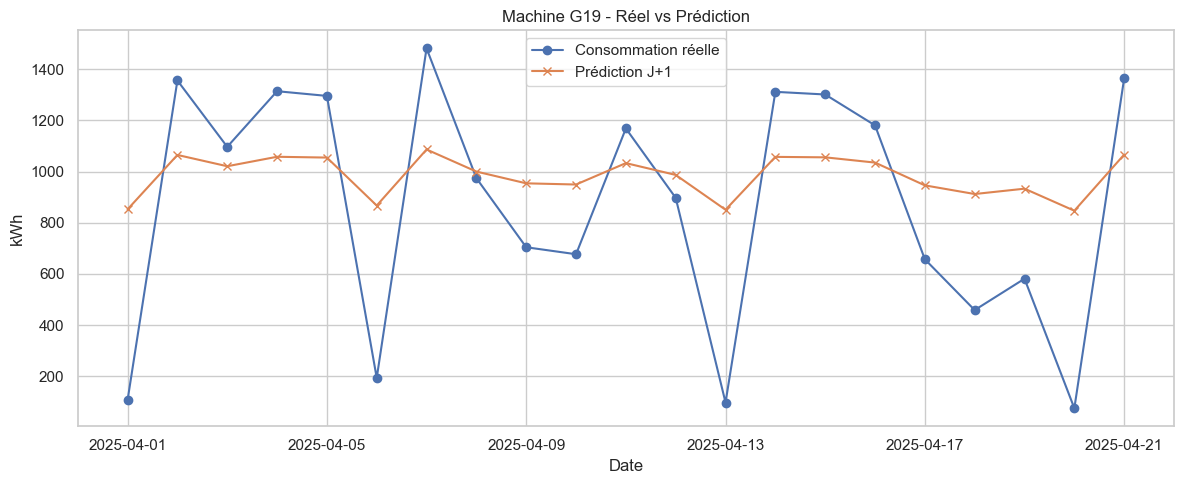

✅ G26 | MAE test: 504.23 | RMSE: 631.97 | R²: -0.119 | Overfitting: False


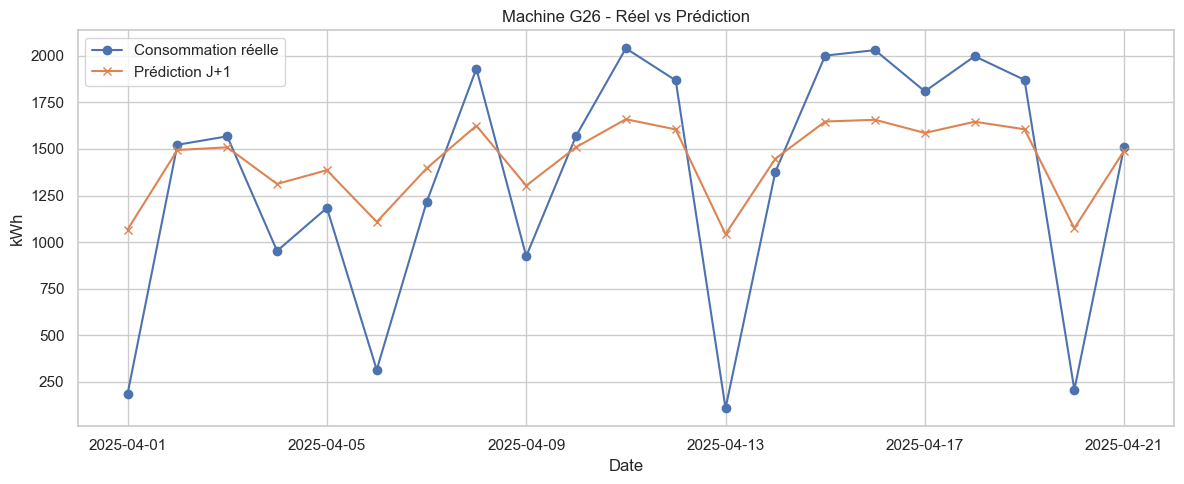

✅ MISFAT 3 D18 | MAE test: 181.07 | RMSE: 227.07 | R²: 0.141 | Overfitting: False


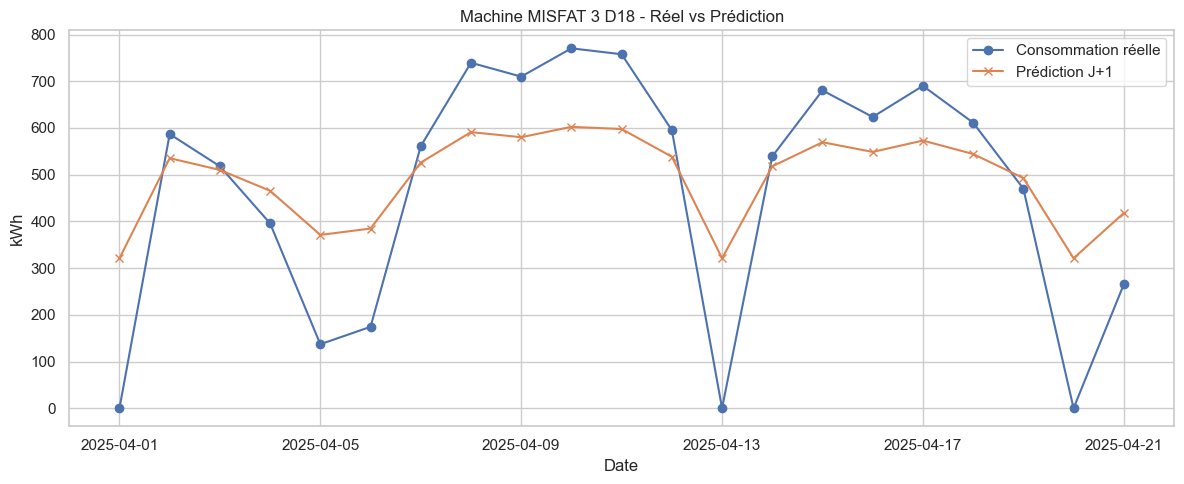

✅ MISFAT 3 D02.01 M43 | MAE test: 59.46 | RMSE: 71.90 | R²: -0.061 | Overfitting: False


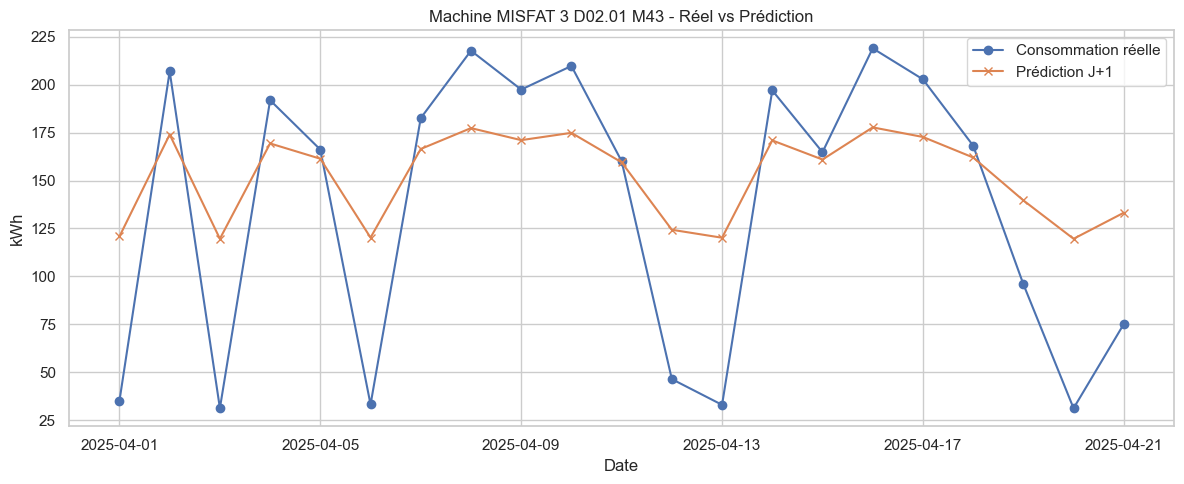

✅ MISFAT 3 Eclairage 3-2 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


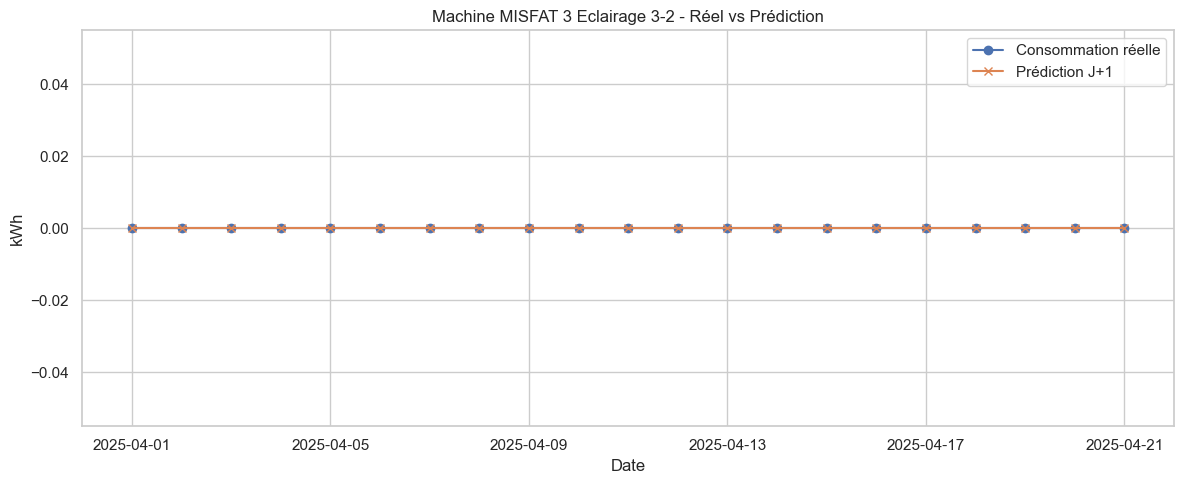

✅ MISFAT 3 G10 | MAE test: 31.01 | RMSE: 38.39 | R²: -0.029 | Overfitting: False


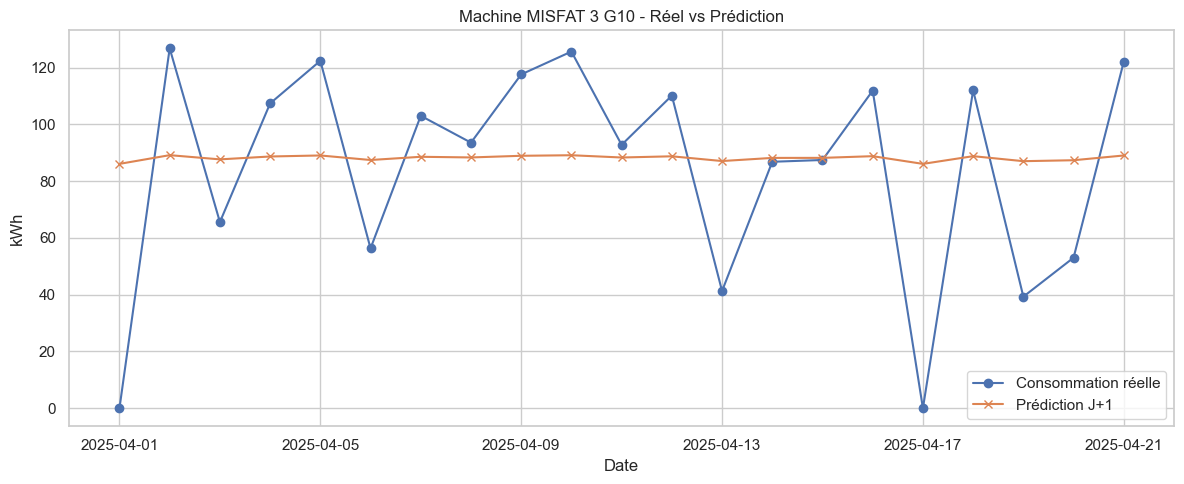

✅ MISFAT 3 G33 | MAE test: 268.36 | RMSE: 326.75 | R²: 0.073 | Overfitting: False


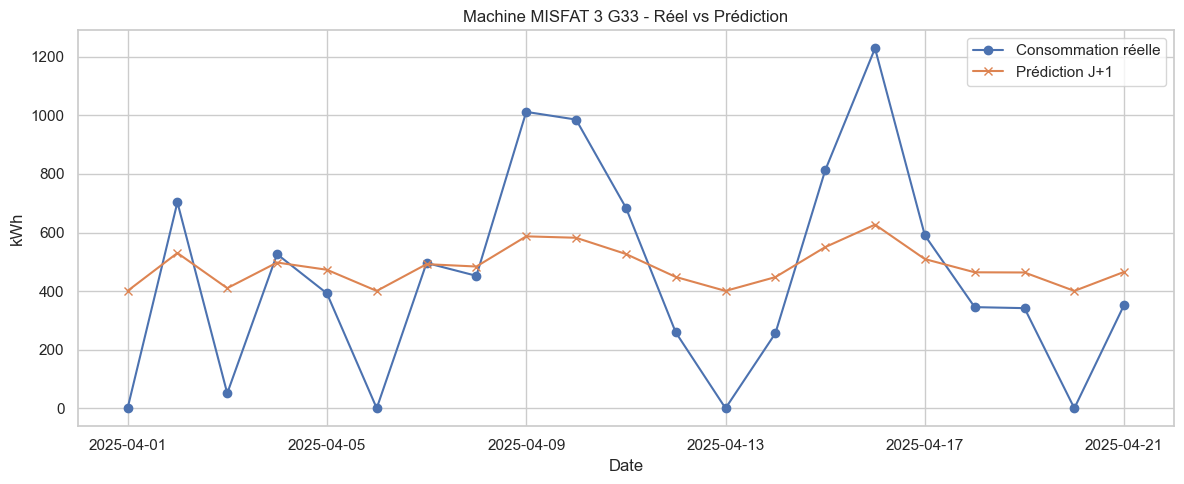

✅ MISFAT 3 G39 | MAE test: 272.55 | RMSE: 319.84 | R²: -0.144 | Overfitting: False


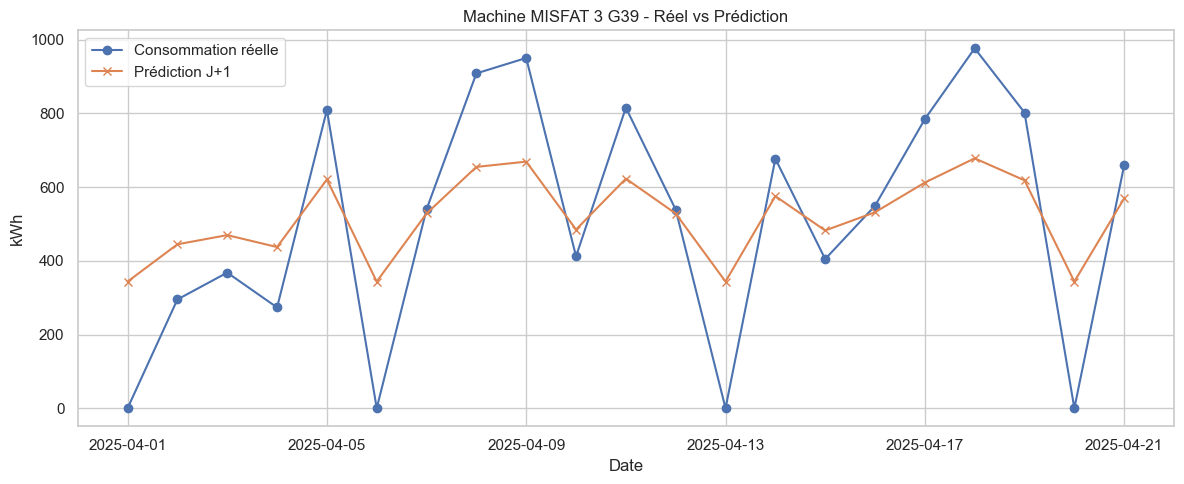

✅ MISFAT 3 H39 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


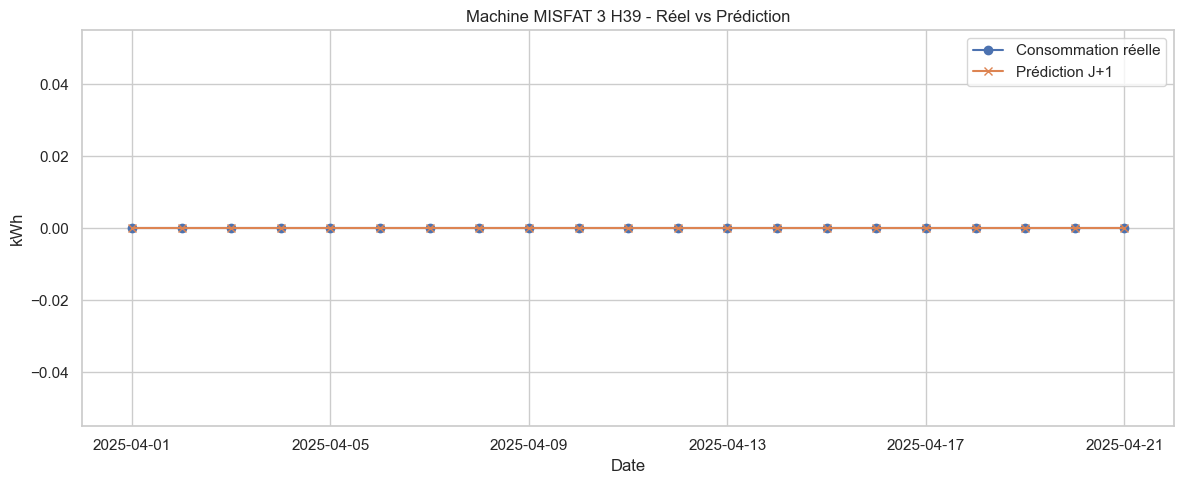

✅ MISFAT 3 H46 | MAE test: 95.22 | RMSE: 116.09 | R²: -0.064 | Overfitting: True


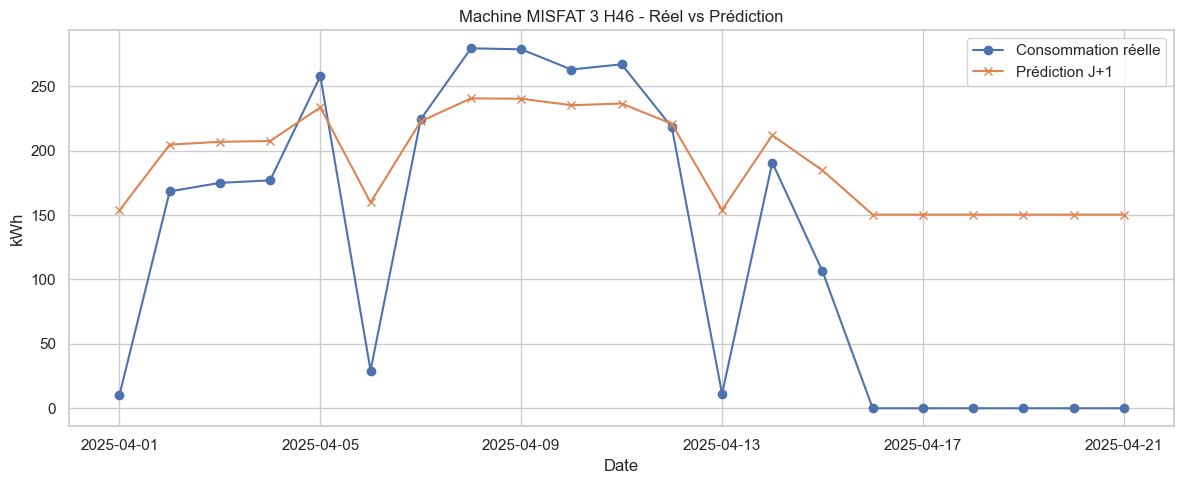

✅ MISFAT 3 H53 | MAE test: 36.15 | RMSE: 46.85 | R²: -0.200 | Overfitting: True


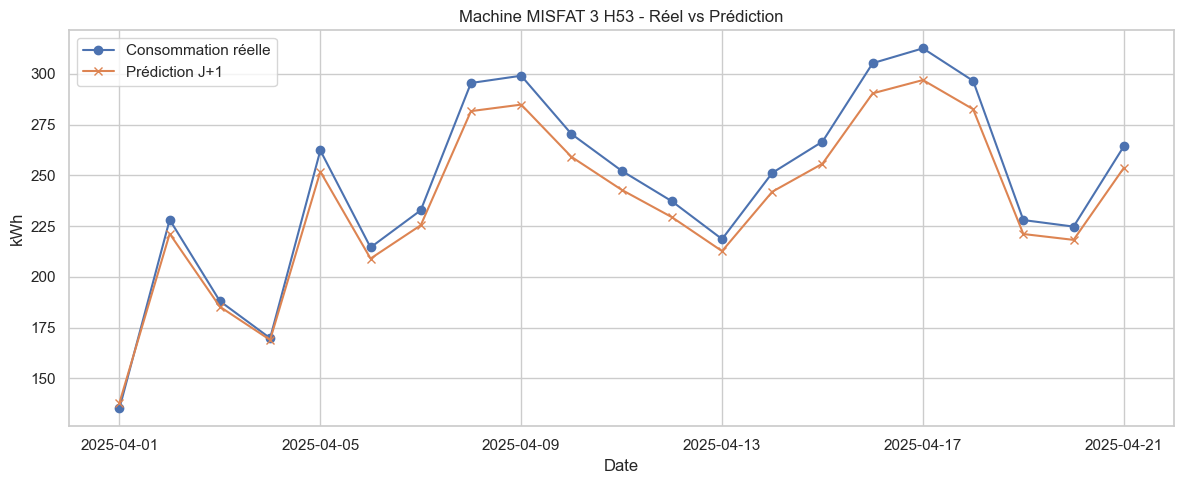

✅ MISFAT 3 N11 | MAE test: 23.48 | RMSE: 29.41 | R²: -0.053 | Overfitting: False


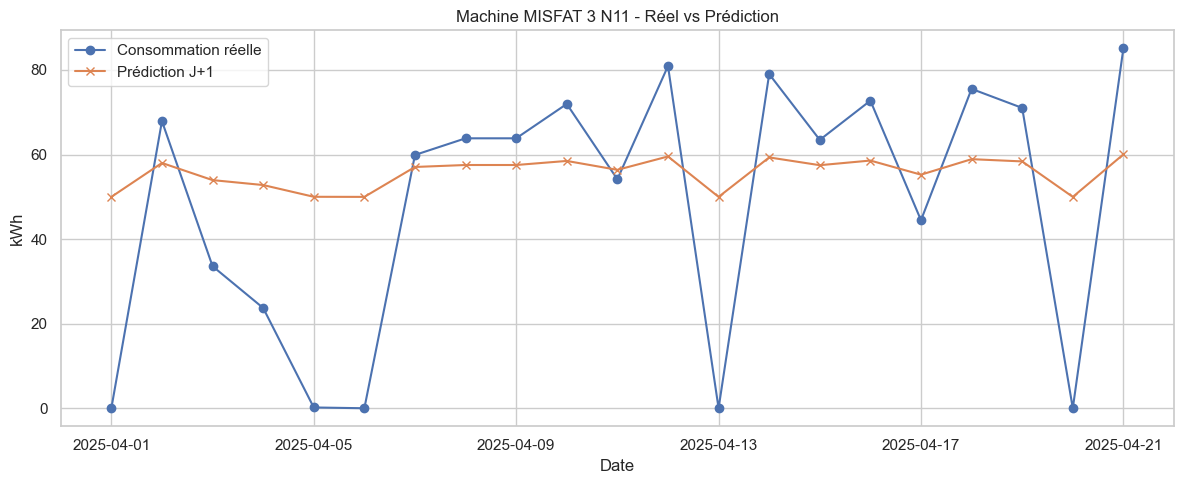


🌍 Scores globaux (régression linéaire) :
🔸 MAE  : 118.01
🔸 MSE  : 44120.37
🔸 RMSE : 210.05
🔸 R²   : 0.8082
🔍 Overfitting global ? Non (MAE train moy: 144.44, test moy: 156.52)

📈 Scores par machine :
                   Machine   MAE_train    MAE_test            MSE        RMSE  \
0                      G19  350.504145  406.686448  227493.893225  476.963199   
1                      G26  476.328947  504.229367  399389.903188  631.973024   
2             MISFAT 3 D18  177.388999  181.072319   51558.948144  227.065955   
3      MISFAT 3 D02.01 M43   94.641272   59.462230    5169.028716   71.895958   
4   MISFAT 3 Eclairage 3-2    0.000000    0.000000       0.000000    0.000000   
5             MISFAT 3 G10   37.043957   31.011950    1473.784707   38.389904   
6             MISFAT 3 G33  237.508588  268.364528  106763.400182  326.746691   
7             MISFAT 3 G39  230.307906  272.547050  102296.169496  319.837724   
8             MISFAT 3 H39    0.000000    0.000000       0.000000    0

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration graphique
sns.set(style="whitegrid")

# Résultats stockés ici
all_results = []
scores = []

for machine in df.columns:
    try:
        # 1. Agrégation journalière
        df_machine = df[[machine]].copy().resample('D').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna().reset_index()

        # 2. Génération de y_next (consommation J+1)
        df_machine['y_next'] = df_machine['y'].shift(-1)
        df_machine = df_machine.dropna()

        # 3. Séparation train/test
        train = df_machine[df_machine['Timestamp'] < '2025-04-01'].copy()
        test = df_machine[df_machine['Timestamp'] >= '2025-04-01'].copy()


        if len(train) < 2 or len(test) < 2:
            print(f"⚠️ Machine {machine} ignorée (jeu de données trop petit)")
            continue

        # 4. Entraînement
        model = LinearRegression()
        model.fit(train[['y']], train['y_next'])

        # 5. Prédiction
        train['y_pred_train'] = model.predict(train[['y']])
        test['y_pred'] = model.predict(test[['y']])

        # 6. Évaluation
        mae_train = mean_absolute_error(train['y_next'], train['y_pred_train'])
        mae_test = mean_absolute_error(test['y_next'], test['y_pred'])
        rmse = np.sqrt(mean_squared_error(test['y_next'], test['y_pred']))
        r2 = r2_score(test['y_next'], test['y_pred'])
        mse = mean_squared_error(test['y_next'], test['y_pred'])

        # 7. Détection overfitting
        overfitting = mae_test > 1.2 * mae_train

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Overfitting': overfitting
        })

        print(f"✅ {machine} | MAE test: {mae_test:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f} | Overfitting: {overfitting}")

        # 8. Préparation résultats
        result = pd.DataFrame({
            'Timestamp': test['Timestamp'],
            'Jour': test['Timestamp'].dt.day_name(),
            'Machine': machine,
            'Consommation_réelle_(kWh)': test['y'],
            'Consommation_prédite_jour_suivant_(kWh)': test['y_pred']
        })
        all_results.append(result)

        # 9. Visualisation
        plt.figure(figsize=(12, 5))
        plt.plot(result['Timestamp'], result['Consommation_réelle_(kWh)'], label='Consommation réelle', marker='o')
        plt.plot(result['Timestamp'], result['Consommation_prédite_jour_suivant_(kWh)'], label='Prédiction J+1', marker='x')
        plt.title(f'Machine {machine} - Réel vs Prédiction')
        plt.xlabel('Date')
        plt.ylabel('kWh')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} :", str(e))

# 10. Fusion des résultats
df_previsions = pd.concat(all_results, ignore_index=True)
df_scores = pd.DataFrame(scores)

# 11. Scores globaux
try:
    df_eval_global = df_previsions.dropna()
    y_true_global = df_eval_global['Consommation_réelle_(kWh)']
    y_pred_global = df_eval_global['Consommation_prédite_jour_suivant_(kWh)']

    mae_global_lr = mean_absolute_error(y_true_global, y_pred_global)
    mse_global_lr = mean_squared_error(y_true_global, y_pred_global)
    rmse_global_lr = np.sqrt(mse_global_lr)
    r2_global_lr = r2_score(y_true_global, y_pred_global)

    print("\n🌍 Scores globaux (régression linéaire) :")
    print(f"🔸 MAE  : {mae_global_lr:.2f}")
    print(f"🔸 MSE  : {mse_global_lr:.2f}")
    print(f"🔸 RMSE : {rmse_global_lr:.2f}")
    print(f"🔸 R²   : {r2_global_lr:.4f}")

    # Détection overfitting global
    mae_train_moy = df_scores['MAE_train'].mean()
    mae_test_moy = df_scores['MAE_test'].mean()
    overfitting_global = mae_test_moy > 1.2 * mae_train_moy
    print(f"🔍 Overfitting global ? {'Oui' if overfitting_global else 'Non'} (MAE train moy: {mae_train_moy:.2f}, test moy: {mae_test_moy:.2f})")

except Exception as e:
    print("❌ Erreur score global :", str(e))

# 12. Résumés
print("\n📈 Scores par machine :")
print(df_scores)

print("\n🔍 Exemple de prévisions :")
print(df_previsions.head())


In [43]:
df_previsions.head()

Timestamp       Jour Machine  Consommation_réelle_(kWh)  \
0 2025-04-01    Tuesday     G19                  106.71875   
1 2025-04-02  Wednesday     G19                 1355.93750   
2 2025-04-03   Thursday     G19                 1096.56250   
3 2025-04-04     Friday     G19                 1314.03125   
4 2025-04-05   Saturday     G19                 1295.65625   

   Consommation_prédite_jour_suivant_(kWh)  
0                               852.272989  
1                              1064.847066  
2                              1020.710360  
3                              1057.716064  
4                              1054.589270

✅ G19 | MAE test: 387.00 | RMSE: 494.53 | R²: -0.244 | Overfitting: True


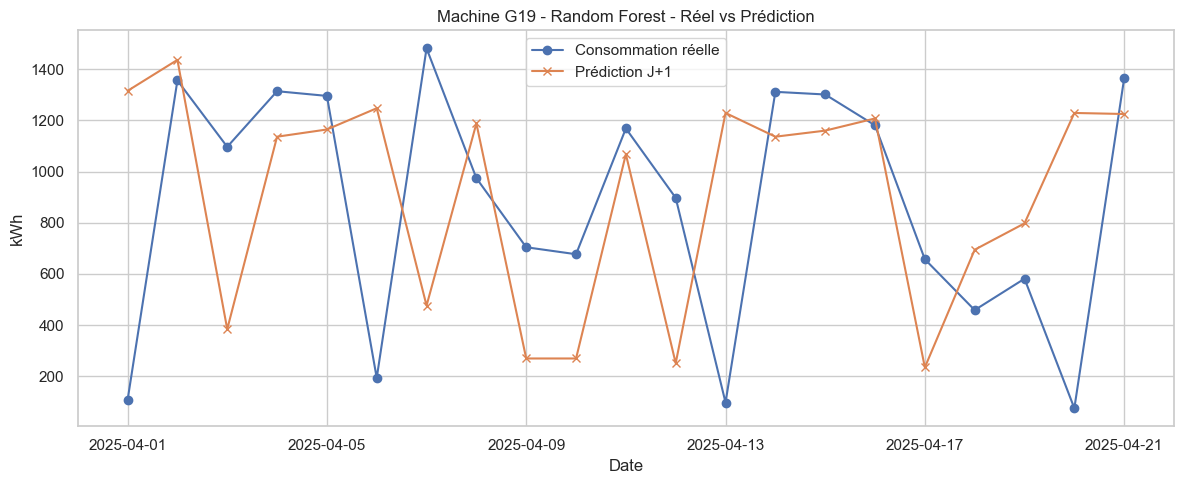

✅ G26 | MAE test: 317.56 | RMSE: 409.11 | R²: 0.531 | Overfitting: True


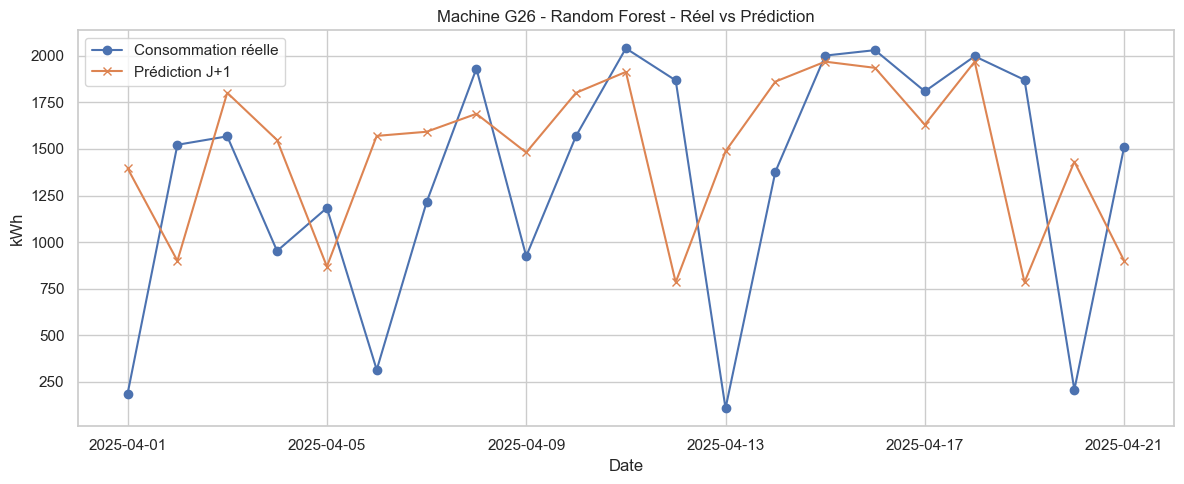

✅ MISFAT 3 D18 | MAE test: 167.75 | RMSE: 208.32 | R²: 0.277 | Overfitting: True


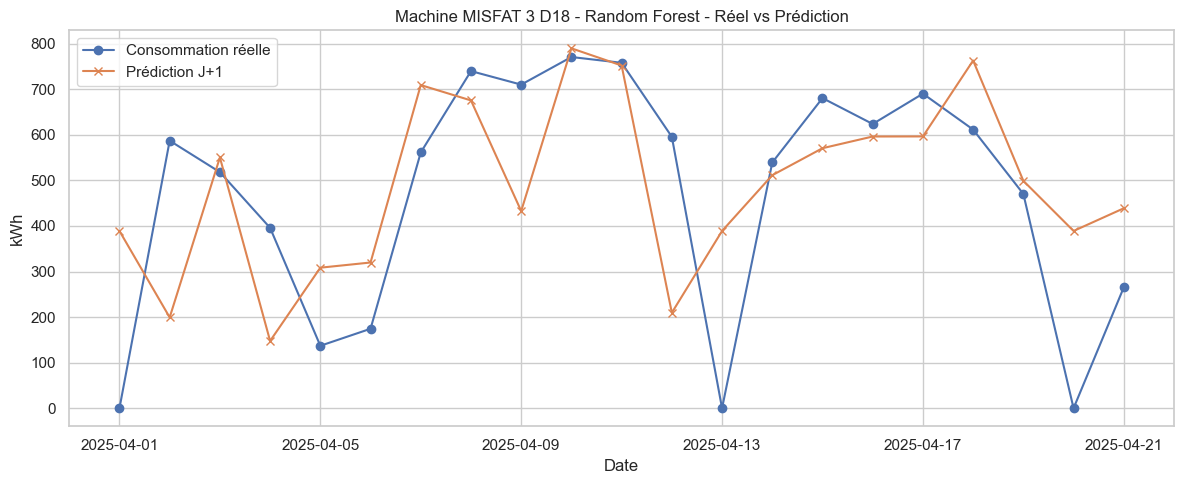

✅ MISFAT 3 D02.01 M43 | MAE test: 108.86 | RMSE: 127.99 | R²: -2.362 | Overfitting: True


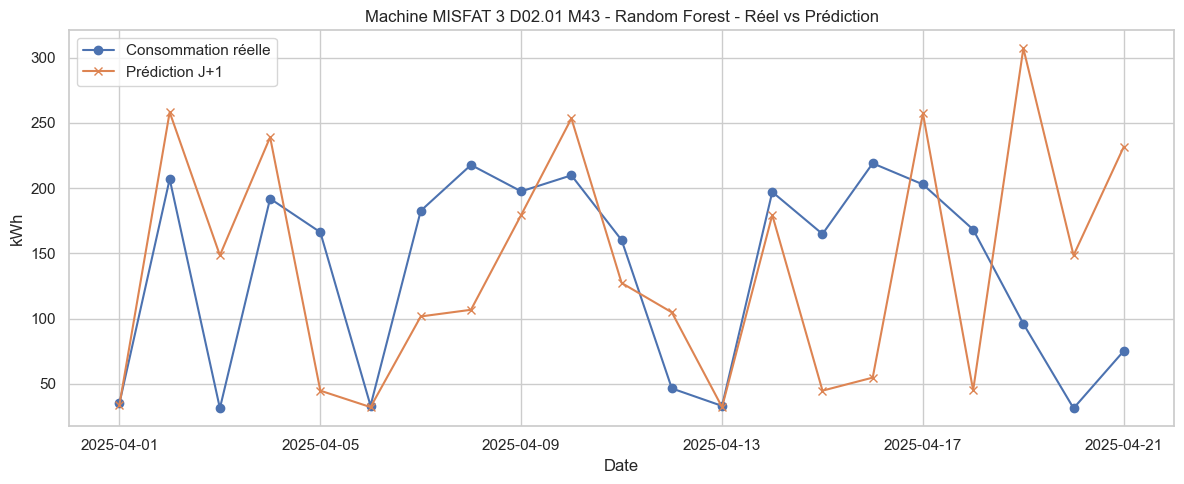

✅ MISFAT 3 Eclairage 3-2 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


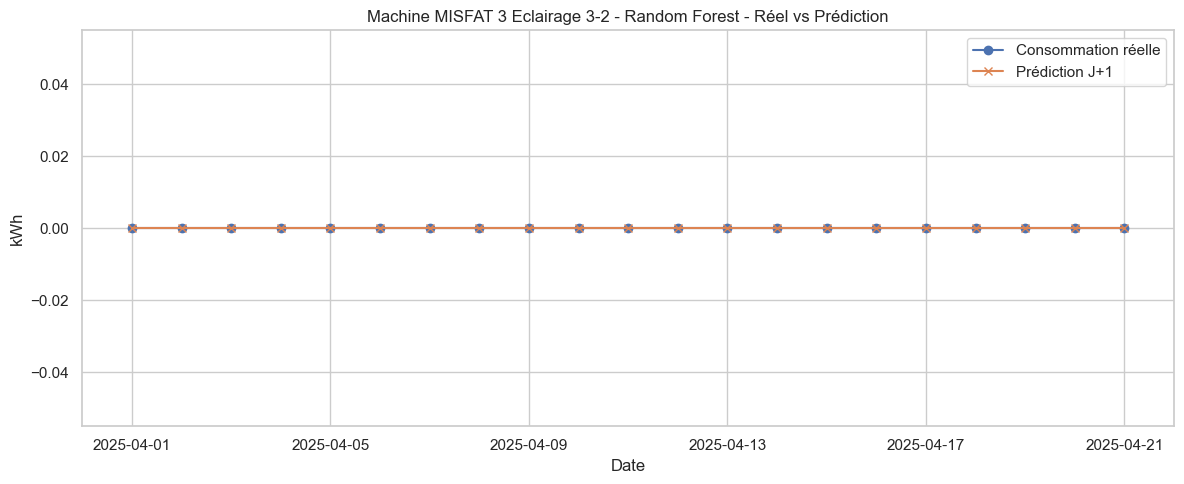

✅ MISFAT 3 G10 | MAE test: 37.66 | RMSE: 45.55 | R²: -0.449 | Overfitting: True


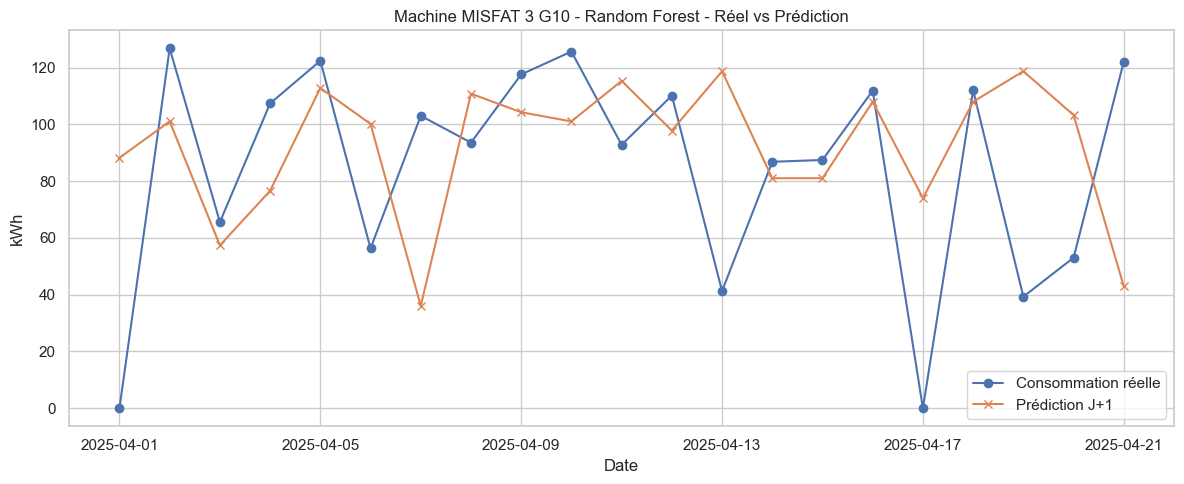

✅ MISFAT 3 G33 | MAE test: 265.40 | RMSE: 376.64 | R²: -0.231 | Overfitting: True


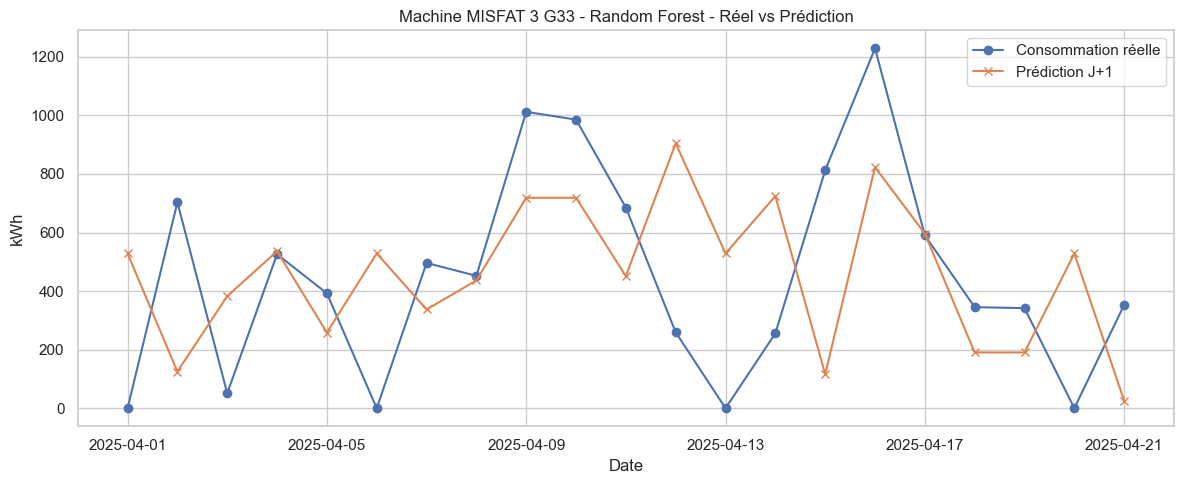

✅ MISFAT 3 G39 | MAE test: 281.11 | RMSE: 351.14 | R²: -0.379 | Overfitting: True


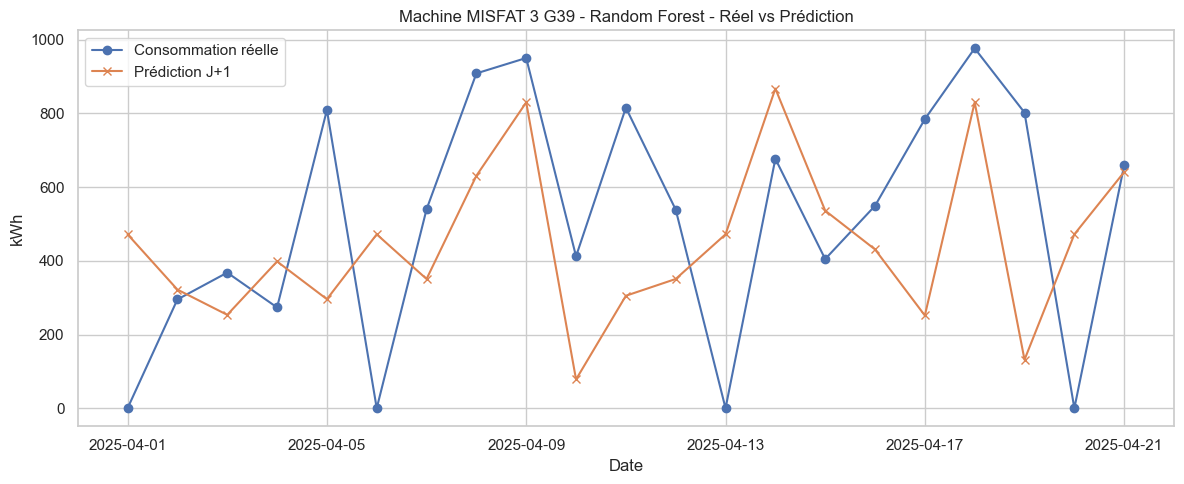

✅ MISFAT 3 H39 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


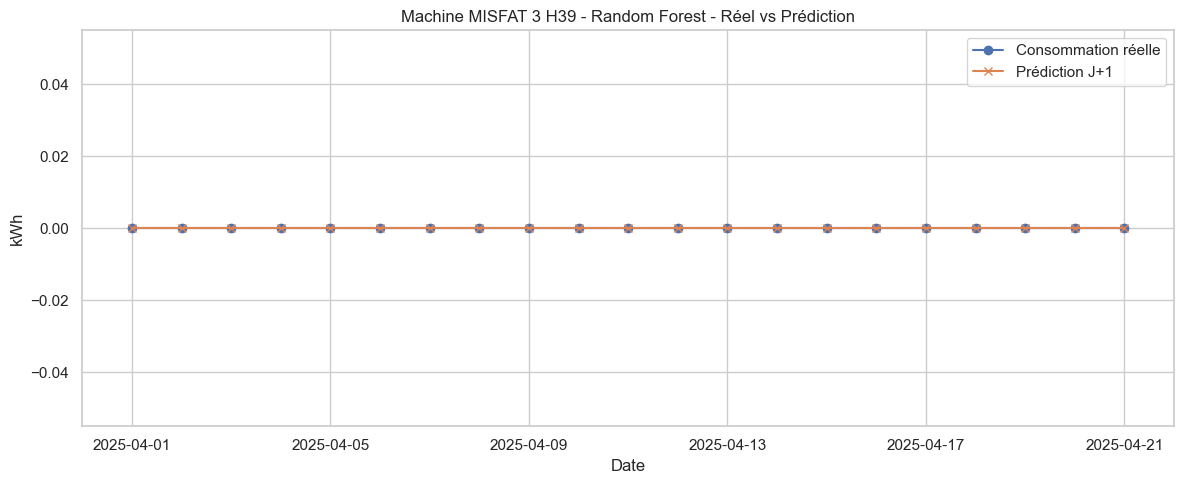

✅ MISFAT 3 H46 | MAE test: 95.09 | RMSE: 118.38 | R²: -0.106 | Overfitting: True


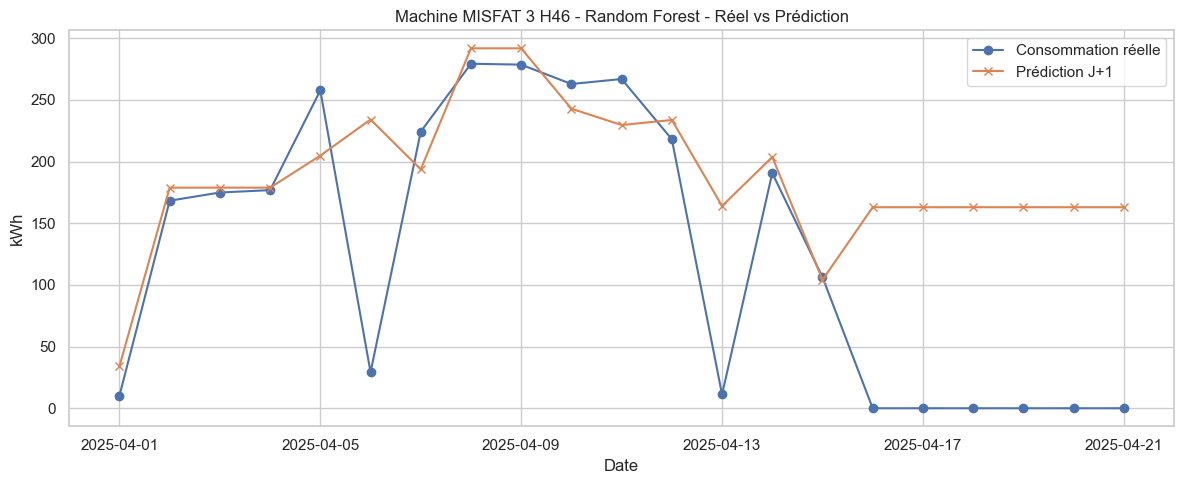

✅ MISFAT 3 H53 | MAE test: 60.14 | RMSE: 79.00 | R²: -2.414 | Overfitting: True


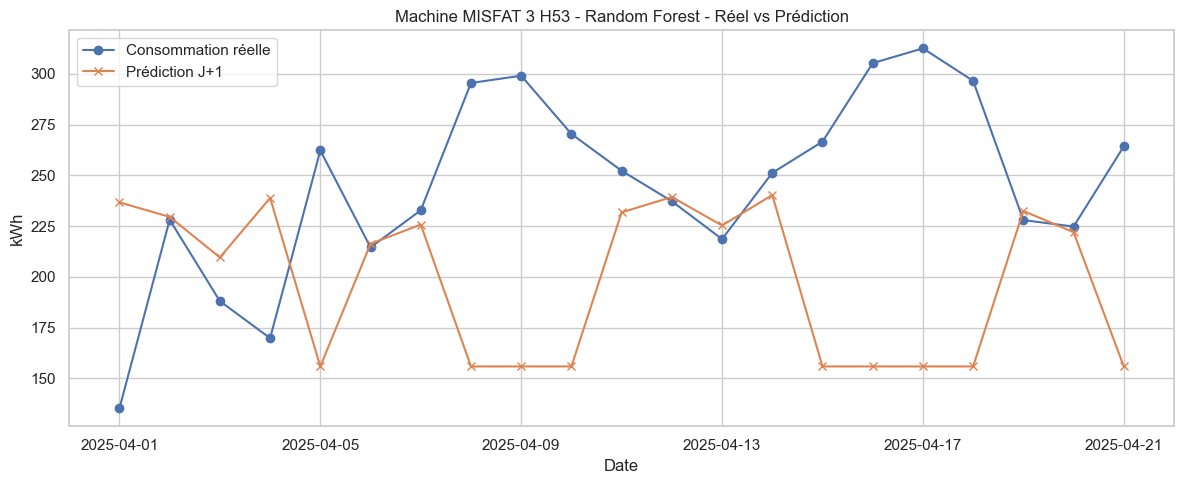

✅ MISFAT 3 N11 | MAE test: 34.68 | RMSE: 40.56 | R²: -1.002 | Overfitting: True


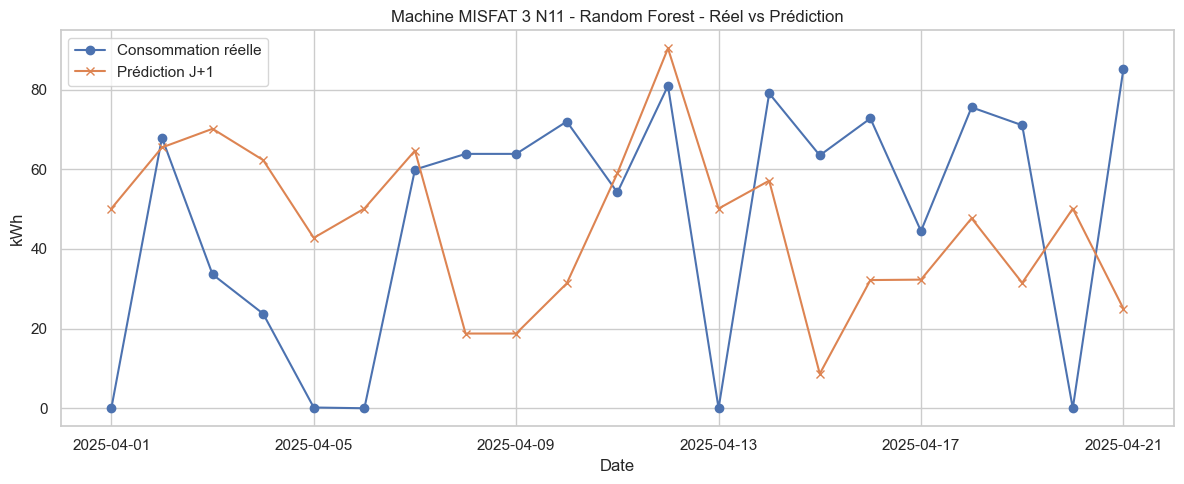


🌍 Scores globaux (Random Forest) :
🔸 MAE  : 177.25
🔸 MSE  : 104784.05
🔸 RMSE : 323.70
🔸 R²   : 0.5445
🔍 Overfitting global ? Oui (MAE train moy: 62.99, test moy: 146.27)

📈 Scores par machine :
                   Machine   MAE_train    MAE_test            MSE        RMSE  \
0                      G19  139.890224  386.995848  244562.328001  494.532434   
1                      G26  187.718788  317.560714  167374.110555  409.113811   
2             MISFAT 3 D18   94.185645  167.749517   43397.649844  208.321026   
3      MISFAT 3 D02.01 M43   35.496096  108.860606   16382.186827  127.992917   
4   MISFAT 3 Eclairage 3-2    0.000000    0.000000       0.000000    0.000000   
5             MISFAT 3 G10   18.640886   37.660351    2074.763459   45.549571   
6             MISFAT 3 G33  120.777715  265.400793  141856.587472  376.638537   
7             MISFAT 3 G39   97.445641  281.108304  123300.723629  351.142028   
8             MISFAT 3 H39    0.000000    0.000000       0.000000    0.00000

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration graphique
sns.set(style="whitegrid")

# Résultats stockés ici
all_results = []
scores = []

for machine in df.columns:
    try:
        # 1. Agrégation journalière
        df_machine = df[[machine]].copy().resample('D').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna().reset_index()

        # 2. Génération de y_next (consommation J+1)
        df_machine['y_next'] = df_machine['y'].shift(-1)
        df_machine = df_machine.dropna()

        # 3. Séparation train/test
        train = df_machine[df_machine['Timestamp'] < '2025-04-01'].copy()
        test = df_machine[df_machine['Timestamp'] >= '2025-04-01'].copy()

        if len(train) < 2 or len(test) < 2:
            print(f"⚠️ Machine {machine} ignorée (jeu de données trop petit)")
            continue

        # 4. Entraînement modèle Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(train[['y']], train['y_next'])

        # 5. Prédiction
        train['y_pred_train'] = model.predict(train[['y']])
        test['y_pred'] = model.predict(test[['y']])

        # 6. Évaluation
        mae_train = mean_absolute_error(train['y_next'], train['y_pred_train'])
        mae_test = mean_absolute_error(test['y_next'], test['y_pred'])
        rmse = np.sqrt(mean_squared_error(test['y_next'], test['y_pred']))
        mse = mean_squared_error(test['y_next'], test['y_pred'])
        r2 = r2_score(test['y_next'], test['y_pred'])

        # 7. Détection overfitting
        overfitting = mae_test > 1.2 * mae_train

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Overfitting': overfitting
        })

        print(f"✅ {machine} | MAE test: {mae_test:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f} | Overfitting: {overfitting}")

        # 8. Résultats prévisions
        result = pd.DataFrame({
            'Timestamp': test['Timestamp'],
            'Jour': test['Timestamp'].dt.day_name(),
            'Machine': machine,
            'Consommation_réelle_(kWh)': test['y'],
            'Consommation_prédite_jour_suivant_(kWh)': test['y_pred']
        })
        all_results.append(result)

        # 9. Visualisation
        plt.figure(figsize=(12, 5))
        plt.plot(result['Timestamp'], result['Consommation_réelle_(kWh)'], label='Consommation réelle', marker='o')
        plt.plot(result['Timestamp'], result['Consommation_prédite_jour_suivant_(kWh)'], label='Prédiction J+1', marker='x')
        plt.title(f'Machine {machine} - Random Forest - Réel vs Prédiction')
        plt.xlabel('Date')
        plt.ylabel('kWh')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} :", str(e))

# 10. Fusion des résultats
df_previsions = pd.concat(all_results, ignore_index=True)
df_scores = pd.DataFrame(scores)

# 11. Scores globaux
try:
    df_eval_global = df_previsions.dropna()
    y_true_global = df_eval_global['Consommation_réelle_(kWh)']
    y_pred_global = df_eval_global['Consommation_prédite_jour_suivant_(kWh)']

    mae_global_rf = mean_absolute_error(y_true_global, y_pred_global)
    mse_global_rf = mean_squared_error(y_true_global, y_pred_global)
    rmse_global_rf = np.sqrt(mse_global_rf)
    r2_global_rf = r2_score(y_true_global, y_pred_global)

    print("\n🌍 Scores globaux (Random Forest) :")
    print(f"🔸 MAE  : {mae_global_rf:.2f}")
    print(f"🔸 MSE  : {mse_global_rf:.2f}")
    print(f"🔸 RMSE : {rmse_global_rf:.2f}")
    print(f"🔸 R²   : {r2_global_rf:.4f}")

    # Détection overfitting global
    mae_train_moy = df_scores['MAE_train'].mean()
    mae_test_moy = df_scores['MAE_test'].mean()
    overfitting_global = mae_test_moy > 1.2 * mae_train_moy
    print(f"🔍 Overfitting global ? {'Oui' if overfitting_global else 'Non'} (MAE train moy: {mae_train_moy:.2f}, test moy: {mae_test_moy:.2f})")

except Exception as e:
    print("❌ Erreur score global :", str(e))

# 12. Résumés
print("\n📈 Scores par machine :")
print(df_scores)

print("\n🔍 Exemple de prévisions :")
print(df_previsions.head())


In [46]:
df_previsions_lstm.head()

Timestamp       Jour Machine  Consommation_réelle_(kWh)  \
0 2025-04-01    Tuesday     G19                  106.71875   
1 2025-04-02  Wednesday     G19                 1355.93750   
2 2025-04-03   Thursday     G19                 1096.56250   
3 2025-04-04     Friday     G19                 1314.03125   
4 2025-04-05   Saturday     G19                 1295.65625   

   Consommation_prédite_jour_suivant_(kWh)  
0                               826.169373  
1                               792.925781  
2                               818.822510  
3                               814.468201  
4                               835.823120

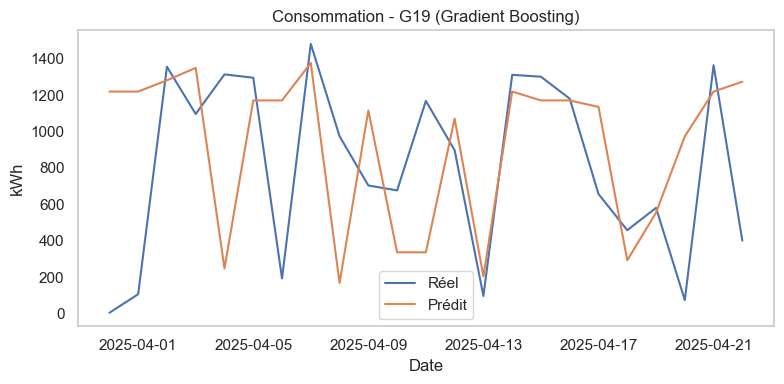

✅ G19 | MAE test: 452.96 | RMSE: 605.93 | R²: -0.567 | Overfitting: True


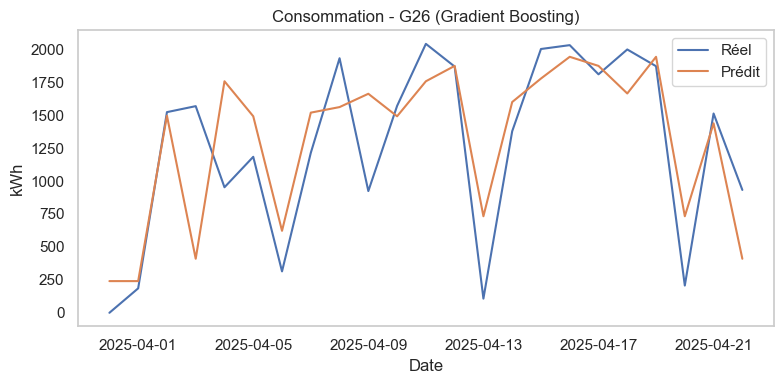

✅ G26 | MAE test: 323.15 | RMSE: 431.06 | R²: 0.594 | Overfitting: True


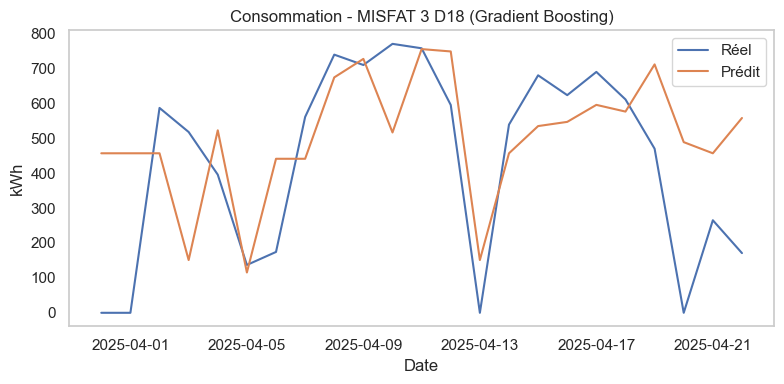

✅ MISFAT 3 D18 | MAE test: 188.38 | RMSE: 239.10 | R²: 0.215 | Overfitting: True


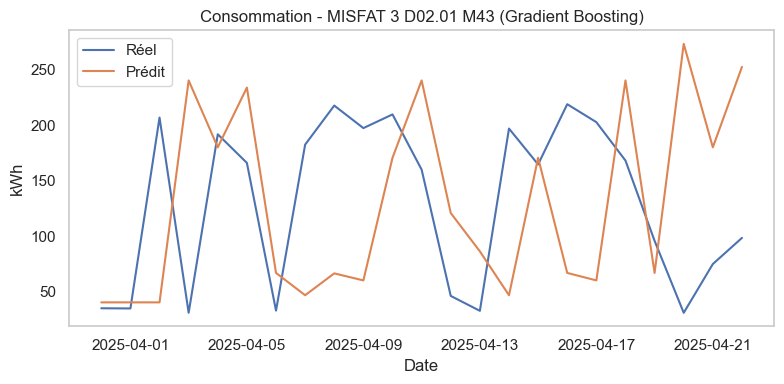

✅ MISFAT 3 D02.01 M43 | MAE test: 96.68 | RMSE: 117.79 | R²: -1.612 | Overfitting: True


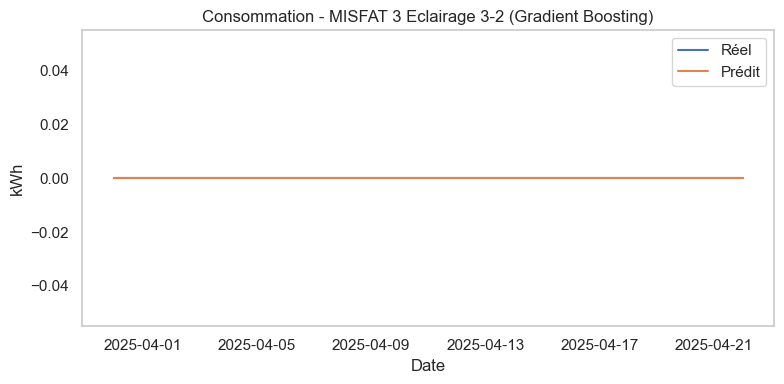

✅ MISFAT 3 Eclairage 3-2 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


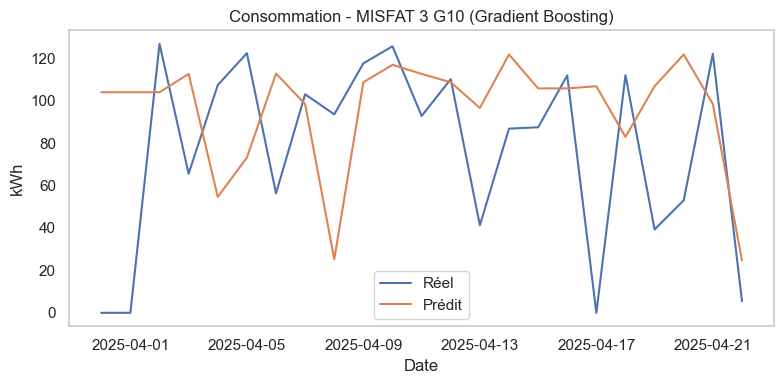

✅ MISFAT 3 G10 | MAE test: 42.53 | RMSE: 53.22 | R²: -0.508 | Overfitting: True


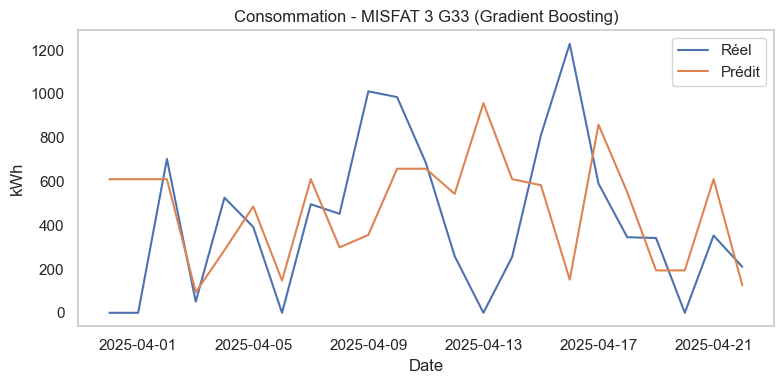

✅ MISFAT 3 G33 | MAE test: 312.17 | RMSE: 417.37 | R²: -0.426 | Overfitting: True


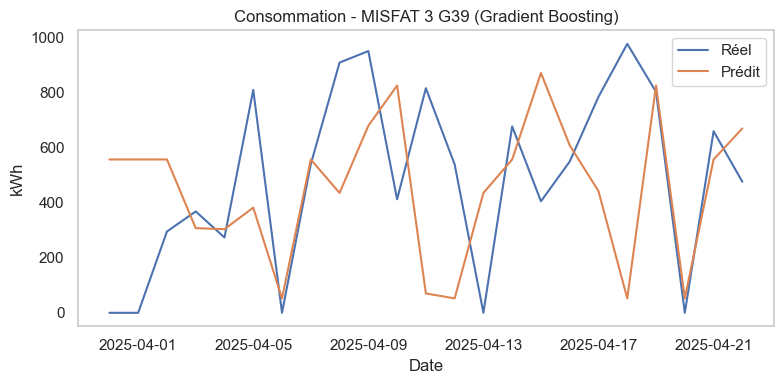

✅ MISFAT 3 G39 | MAE test: 307.34 | RMSE: 394.78 | R²: -0.493 | Overfitting: True


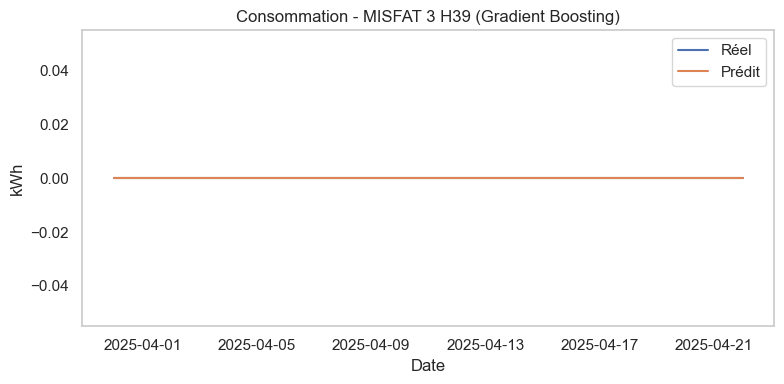

✅ MISFAT 3 H39 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


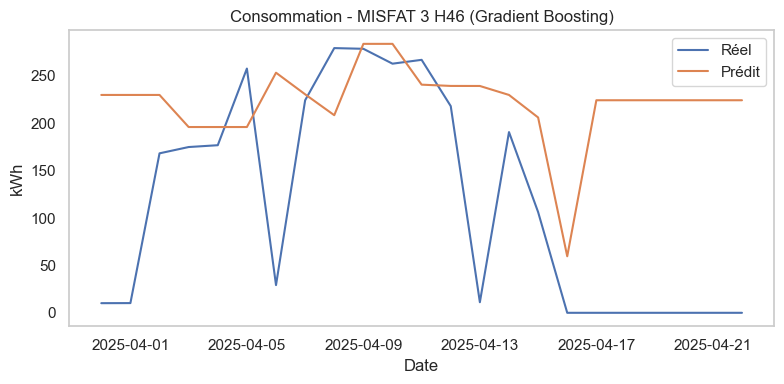

✅ MISFAT 3 H46 | MAE test: 119.61 | RMSE: 151.95 | R²: -0.828 | Overfitting: True


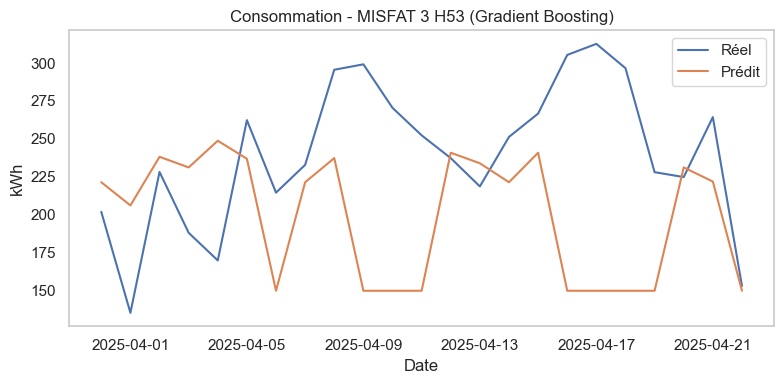

✅ MISFAT 3 H53 | MAE test: 61.93 | RMSE: 81.11 | R²: -1.931 | Overfitting: True


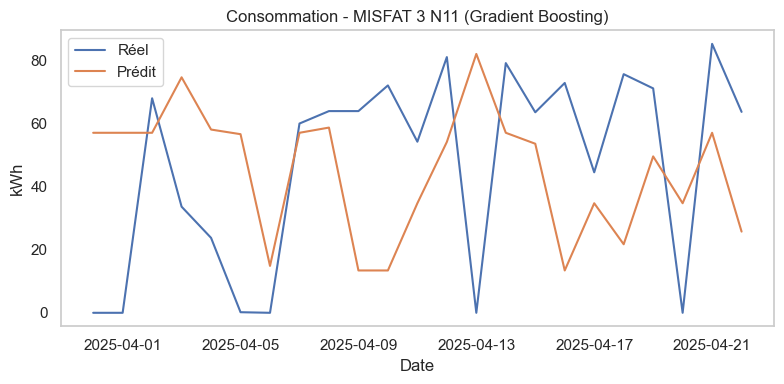

✅ MISFAT 3 N11 | MAE test: 34.52 | RMSE: 40.48 | R²: -0.710 | Overfitting: True

📊 Scores par machine :
               Machine  MAE_train   MAE_test           MSE       RMSE        R2  Overfitting
                   G19 107.215445 452.961410 367146.455436 605.926114 -0.566656         True
                   G26 156.438438 323.147669 185813.374734 431.060755  0.594063         True
          MISFAT 3 D18  66.698418 188.375899  57167.135880 239.096499  0.214897         True
   MISFAT 3 D02.01 M43  35.586055  96.678519  13874.530024 117.790195 -1.611760         True
MISFAT 3 Eclairage 3-2   0.000000   0.000000      0.000000   0.000000  1.000000        False
          MISFAT 3 G10  12.184749  42.528956   2832.571476  53.221908 -0.507760         True
          MISFAT 3 G33  89.801656 312.173471 174196.291743 417.368293 -0.426257         True
          MISFAT 3 G39  76.864858 307.339519 155853.379030 394.782698 -0.493397         True
          MISFAT 3 H39   0.000000   0.000000      0.000000 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# 1. Initialisation
machines = df.columns
all_results = []
scores = []

# 2. Boucle sur chaque machine
for machine in machines:
    try:
        # Agrégation journalière
        df_machine = df[[machine]].copy().resample('D').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna()

        # Skip si trop peu de données
        if len(df_machine) < 10:
            print(f"⚠️ Machine {machine} ignorée (pas assez de données)")
            continue

        df_machine['Jour'] = df_machine.index.strftime('%A')

        # Normalisation
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(df_machine[['y']])

        # Séquences
        X, y = [], []
        for i in range(len(data_scaled) - 1):
            X.append(data_scaled[i])
            y.append(data_scaled[i + 1])
        X, y = np.array(X), np.array(y)

        # Train/test split
        split_index = int(len(X) * 0.8)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        # Modèle
        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        model.fit(X_train, y_train.ravel())

        # Prédictions test
        y_pred_scaled = model.predict(X_test).reshape(-1, 1)
        y_pred = scaler.inverse_transform(y_pred_scaled)
        y_true = scaler.inverse_transform(y_test)

        # Prédictions train
        y_train_pred_scaled = model.predict(X_train).reshape(-1, 1)
        y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
        y_train_true = scaler.inverse_transform(y_train)

        # Dates
        dates = df_machine.index[1:][split_index:]

        # Résultats
        df_result = pd.DataFrame({
            'Timestamp': dates,
            'Jour': dates.strftime('%A'),
            'Machine': machine,
            'Consommation réelle (kWh)': y_true.flatten(),
            'Consommation prédite jour suivant (kWh)': y_pred.flatten()
        })
        all_results.append(df_result)

        # Évaluation
        mae_train = mean_absolute_error(y_train_true, y_train_pred)
        mae_test = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Overfitting
        overfitting = mae_test > 1.2 * mae_train

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Overfitting': overfitting
        })

        # Visualisation
        plt.figure(figsize=(8, 4))
        plt.plot(dates, y_true.flatten(), label='Réel')
        plt.plot(dates, y_pred.flatten(), label='Prédit')
        plt.title(f"Consommation - {machine} (Gradient Boosting)")
        plt.xlabel("Date")
        plt.ylabel("kWh")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        print(f"✅ {machine} | MAE test: {mae_test:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f} | Overfitting: {overfitting}")

    except Exception as e:
        print(f"❌ Erreur machine {machine} :", str(e))

# 3. Fusion des résultats
if all_results:
    df_previsions_gb = pd.concat(all_results, ignore_index=True)
    df_scores_gb = pd.DataFrame(scores)

    print("\n📊 Scores par machine :")
    print(df_scores_gb.to_string(index=False))

    # Score global
    try:
        global_rmse_gb = np.sqrt(mean_squared_error(
            df_previsions_gb['Consommation réelle (kWh)'],
            df_previsions_gb['Consommation prédite jour suivant (kWh)']
        ))
        global_mse_gb = mean_squared_error(
            df_previsions_gb['Consommation réelle (kWh)'],
            df_previsions_gb['Consommation prédite jour suivant (kWh)']
        )
        global_mae_gb = mean_absolute_error(
            df_previsions_gb['Consommation réelle (kWh)'],
            df_previsions_gb['Consommation prédite jour suivant (kWh)']
        )
        global_r2_gb = r2_score(
            df_previsions_gb['Consommation réelle (kWh)'],
            df_previsions_gb['Consommation prédite jour suivant (kWh)']
        )

        print("\n📈 Scores globaux (Gradient Boosting) :")
        print(f"RMSE : {global_rmse_gb:.2f} kWh")
        print(f"MSE  : {global_mse_gb:.2f} kWh")
        print(f"MAE  : {global_mae_gb:.2f} kWh")
        print(f"R2   : {global_r2_gb:.4f}")

        # Overfitting global
        mae_train_moy = df_scores_gb['MAE_train'].mean()
        mae_test_moy = df_scores_gb['MAE_test'].mean()
        overfitting_global = mae_test_moy > 1.2 * mae_train_moy
        print(f"\n🔍 Overfitting global ? {'Oui' if overfitting_global else 'Non'} "
              f"(MAE train moy: {mae_train_moy:.2f}, test moy: {mae_test_moy:.2f})")

    except Exception as e:
        print("❌ Erreur score global :", str(e))
else:
    print("⚠️ Aucun résultat à afficher (Gradient Boosting)")


In [49]:
df_previsions_lstm.head()

Timestamp       Jour Machine  Consommation_réelle_(kWh)  \
0 2025-04-01    Tuesday     G19                  106.71875   
1 2025-04-02  Wednesday     G19                 1355.93750   
2 2025-04-03   Thursday     G19                 1096.56250   
3 2025-04-04     Friday     G19                 1314.03125   
4 2025-04-05   Saturday     G19                 1295.65625   

   Consommation_prédite_jour_suivant_(kWh)  
0                               826.169373  
1                               792.925781  
2                               818.822510  
3                               814.468201  
4                               835.823120

In [50]:
import pandas as pd

# ⚠️ Remplace ces valeurs par les scores réels de tes modèles
scores_globaux = pd.DataFrame({
    'Modèle': ['Random Forest', 'Gradient Boosting', 'Prophet', 'LSTM', 'LinearRegression'],
    'MAE': [mae_global_rf, global_mae_gb, mae_global_pr, mae_global_lstm, mae_global_lr],
    'RMSE': [rmse_global_rf, global_rmse_gb, rmse_global_pr, rmse_global_lstm, rmse_global_lr],
    'R2': [r2_global_rf, global_r2_gb, r2_global_pr, r2_global_lstm, r2_global_lr]
})

# Mise en forme pour les couleurs
def highlight_best(s):
    if s.name in ['MAE', 'RMSE']:
        is_best = s == s.min()
    elif s.name == 'R2':
        is_best = s == s.max()
    else:
        is_best = [False] * len(s)
    return ['background-color: lightgreen' if v else '' for v in is_best]

# Tableau stylisé
styled_scores = scores_globaux.set_index('Modèle').style.format("{:.2f}").apply(highlight_best)

# Affichage (notebook Jupyter)
styled_scores


✅ G19 | MAE test: 1517.06 | RMSE: 2470.82 | R²: -0.688 | Overfitting: True


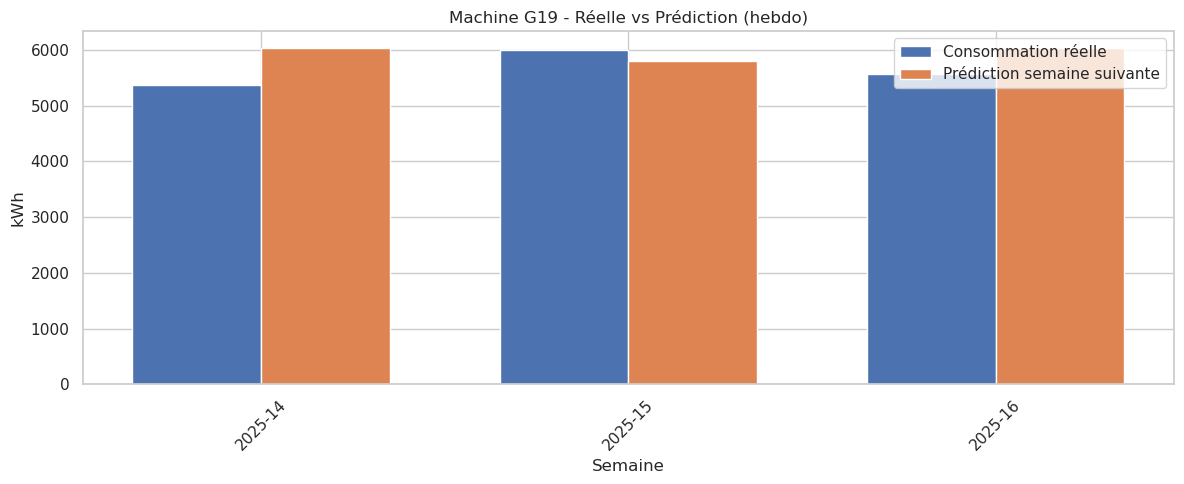

✅ G26 | MAE test: 3121.58 | RMSE: 3416.96 | R²: 0.210 | Overfitting: True


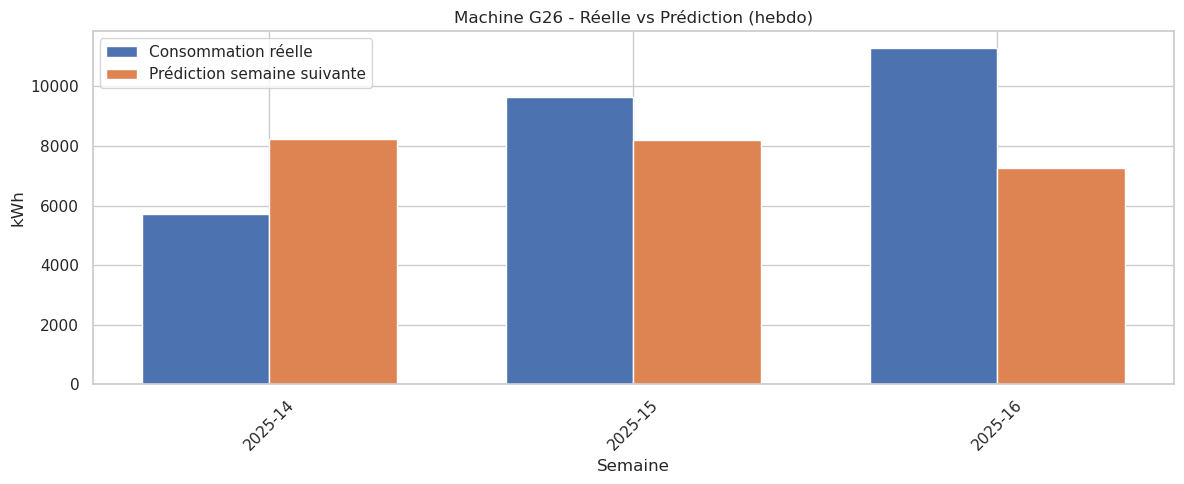

✅ MISFAT 3 D18 | MAE test: 1618.43 | RMSE: 1647.68 | R²: -0.016 | Overfitting: True


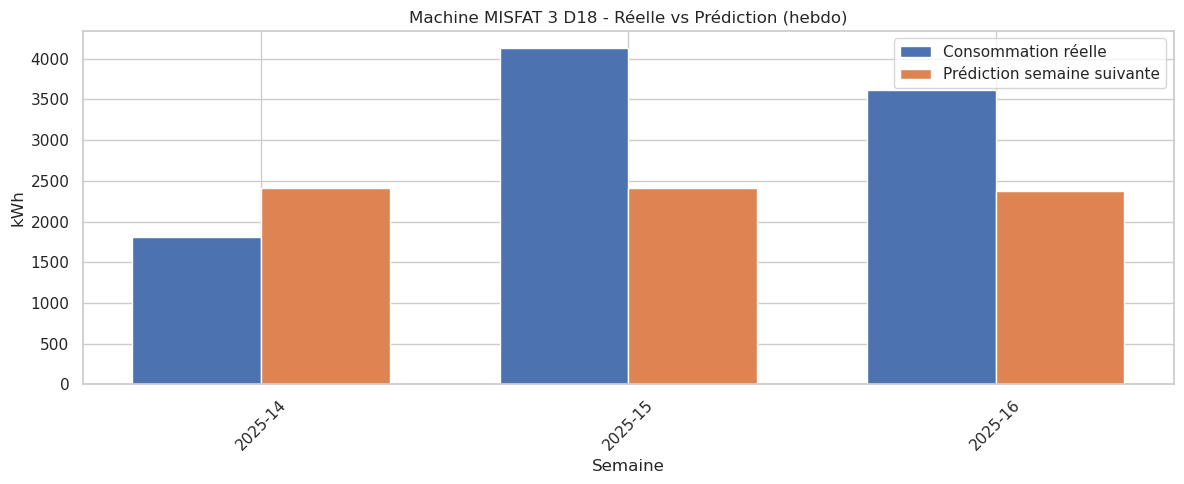

✅ MISFAT 3 D02.01 M43 | MAE test: 369.39 | RMSE: 494.55 | R²: -0.390 | Overfitting: True


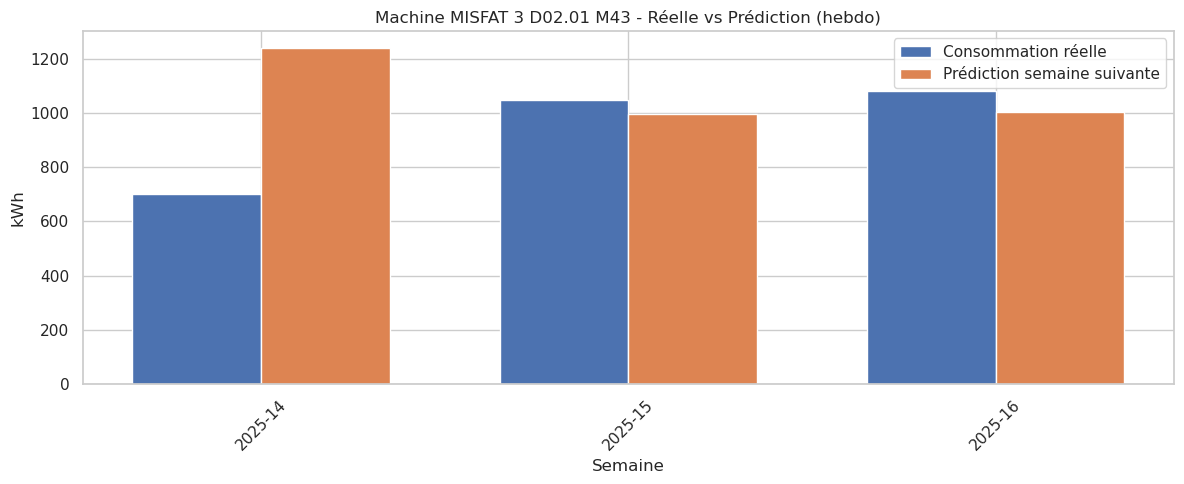

✅ MISFAT 3 Eclairage 3-2 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


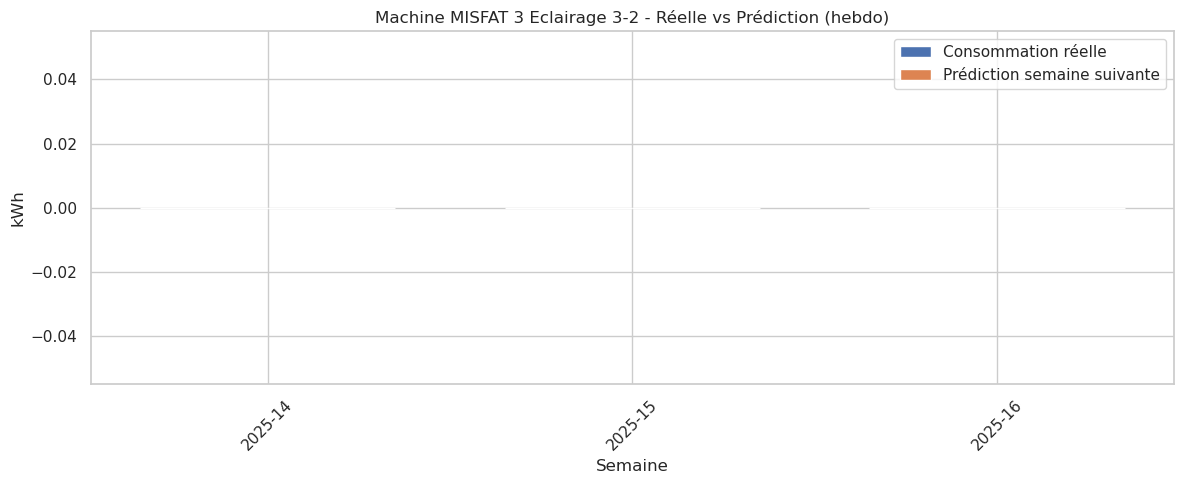

✅ MISFAT 3 G10 | MAE test: 203.49 | RMSE: 260.76 | R²: -0.277 | Overfitting: True


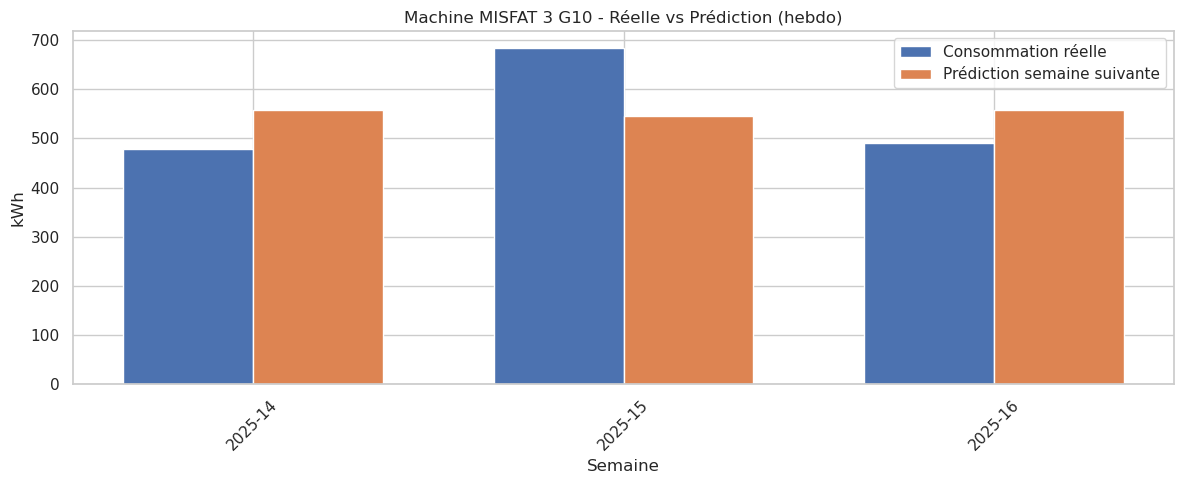

✅ MISFAT 3 G33 | MAE test: 1553.84 | RMSE: 1556.89 | R²: -0.077 | Overfitting: True


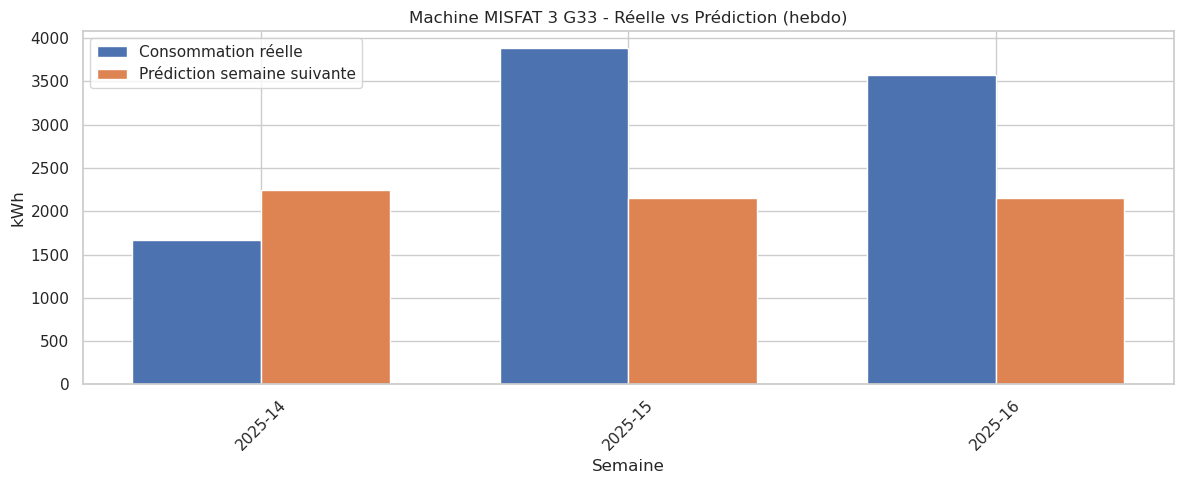

✅ MISFAT 3 G39 | MAE test: 1738.95 | RMSE: 1761.23 | R²: -0.507 | Overfitting: True


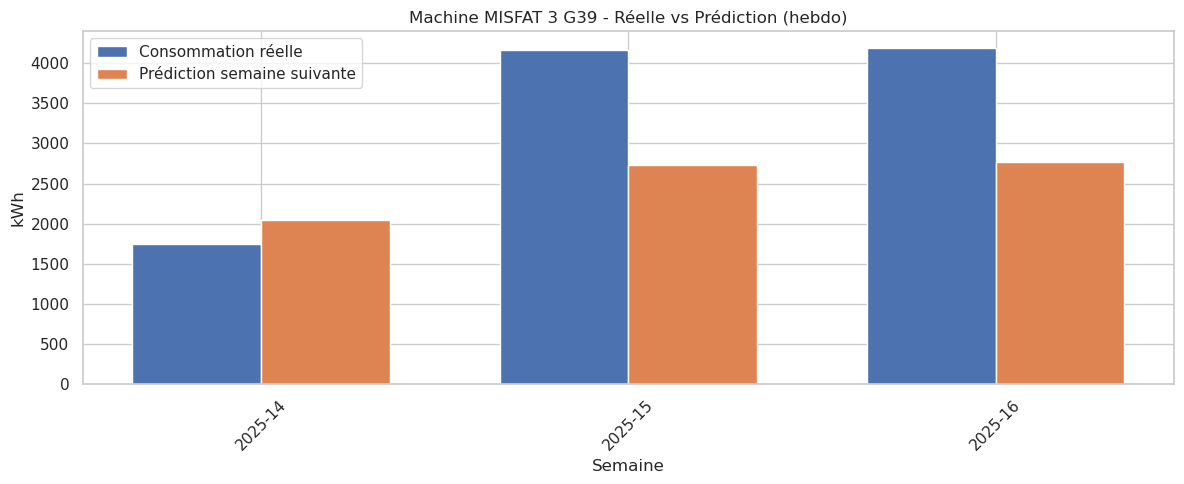

✅ MISFAT 3 H39 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


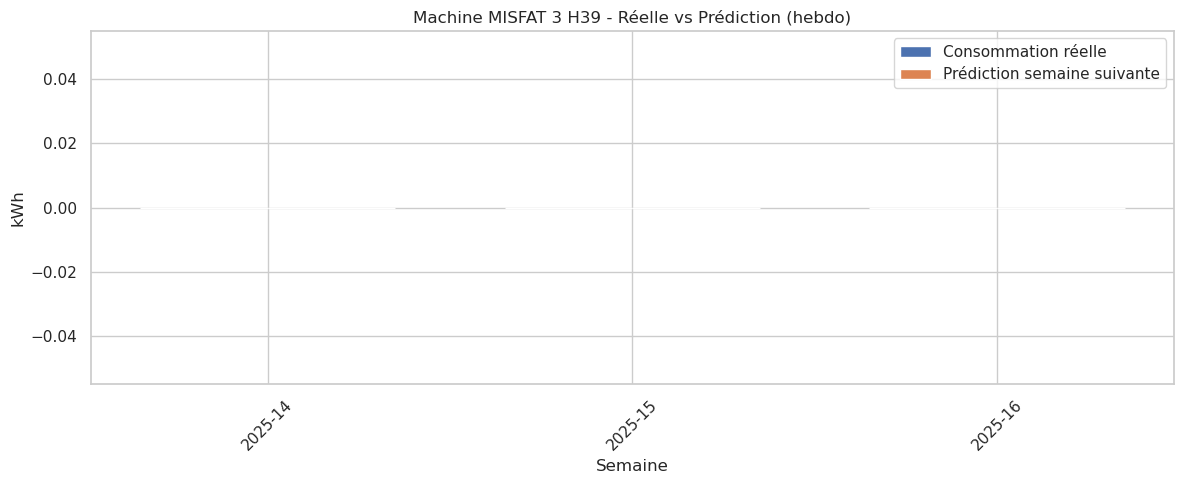

✅ MISFAT 3 H46 | MAE test: 768.49 | RMSE: 797.63 | R²: -0.427 | Overfitting: True


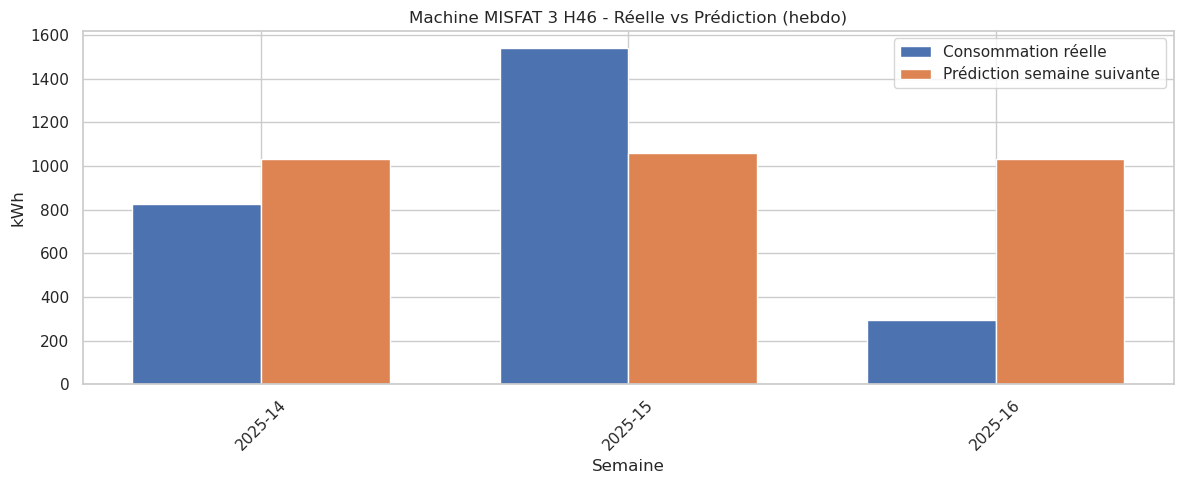

✅ MISFAT 3 H53 | MAE test: 641.57 | RMSE: 687.68 | R²: -0.041 | Overfitting: True


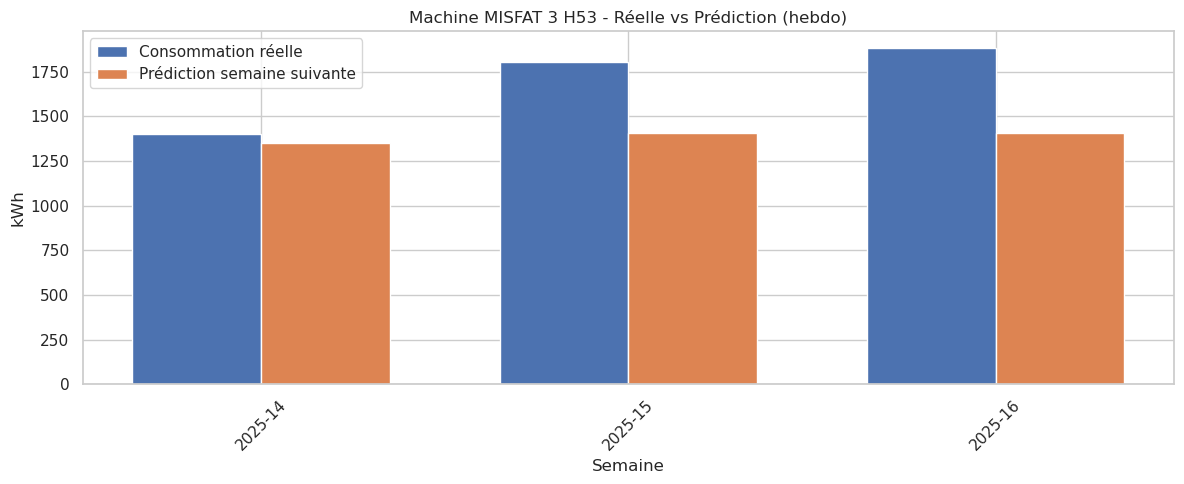

✅ MISFAT 3 N11 | MAE test: 129.27 | RMSE: 129.84 | R²: -0.195 | Overfitting: True


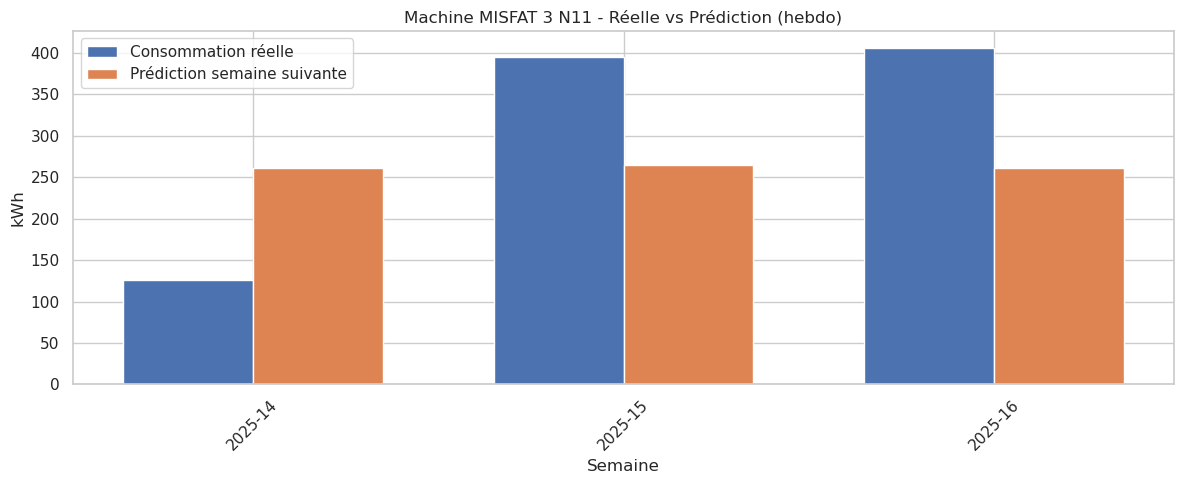


🌍 Scores globaux (Random Forest) :
🔸 MAE  : 652.43
🔸 RMSE : 1070.98
🔸 R²   : 0.8436
🔍 Overfitting global ? Oui (MAE train moy: 179.28, test moy: 971.84)

📈 Scores par machine :
                   Machine   MAE_train     MAE_test         RMSE        R2  \
0                      G19  418.669087  1517.058750  2470.822839 -0.688166   
1                      G26  576.154904  3121.578333  3416.959265  0.210120   
2             MISFAT 3 D18  196.941971  1618.428125  1647.683502 -0.015809   
3      MISFAT 3 D02.01 M43  142.551653   369.386276   494.551326 -0.390197   
4   MISFAT 3 Eclairage 3-2    0.000000     0.000000     0.000000  1.000000   
5             MISFAT 3 G10   28.637189   203.486701   260.760738 -0.277373   
6             MISFAT 3 G33  237.461238  1553.844505  1556.892636 -0.077493   
7             MISFAT 3 G39  274.928894  1738.947292  1761.234964 -0.506514   
8             MISFAT 3 H39    0.000000     0.000000     0.000000  1.000000   
9             MISFAT 3 H46   61.334491   7

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration graphique
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'  # Police compatible emoji de base (évite les warnings)

all_results = []
scores = []

for machine in df.columns:
    try:
        # 1. Agrégation hebdomadaire
        df_machine = df[[machine]].copy().resample('W').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna().reset_index()
        df_machine['Machine'] = machine

        # 2. Ajout des features temporelles
        df_machine['semaine'] = df_machine['Timestamp'].dt.isocalendar().week
        df_machine['mois'] = df_machine['Timestamp'].dt.month
        df_machine['année'] = df_machine['Timestamp'].dt.year

        # 3. Génération y_next (valeur cible)
        df_machine['y_next'] = df_machine['y'].shift(-1)
        df_machine = df_machine.dropna()

        # 4. Séparation train / test
        train = df_machine[df_machine['Timestamp'] < '2025-04-01']
        test = df_machine[df_machine['Timestamp'] >= '2025-04-01']

        if len(train) < 2 or len(test) < 2:
            print(f"⚠️ Machine {machine} ignorée (jeu de données trop petit)")
            continue

        # 5. Entraînement modèle
        features = ['y', 'semaine', 'mois', 'année']
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(train[features], train['y_next'])

        # 6. Prédictions
        test = test.copy()
        test.loc[:, 'y_pred'] = model.predict(test[features])

        # 7. Évaluation
        mae_train = mean_absolute_error(train['y_next'], model.predict(train[features]))
        mae_test = mean_absolute_error(test['y_next'], test['y_pred'])
        rmse = np.sqrt(mean_squared_error(test['y_next'], test['y_pred']))
        r2 = r2_score(test['y_next'], test['y_pred'])
        overfitting = mae_test > 1.2 * mae_train

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'RMSE': rmse,
            'R2': r2,
            'Overfitting': overfitting
        })

        print(f"✅ {machine} | MAE test: {mae_test:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f} | Overfitting: {overfitting}")

        # 8. Construction du DataFrame résultat formaté
        test['Semaine'] = test['Timestamp'].dt.strftime('%Y-%U')
        test['Semaine_suivante'] = (test['Timestamp'] + pd.Timedelta(weeks=1)).dt.strftime('%Y-%U')

        result = pd.DataFrame({
            'Timestamp': test['Timestamp'],
            'Semaine': test['Semaine'],
            'Machine': machine,
            'Consommation réelle (kWh)': test['y'],
            'Semaine suivante': test['Semaine_suivante'],
            'Consommation prédite semaine prochaine (kWh)': test['y_pred']
        })

        all_results.append(result)

        # 9. Visualisation en barres
        plt.figure(figsize=(12, 5))
        x = np.arange(len(result['Semaine']))
        width = 0.35

        plt.bar(x - width/2, result['Consommation réelle (kWh)'], width, label='Consommation réelle')
        plt.bar(x + width/2, result['Consommation prédite semaine prochaine (kWh)'], width, label='Prédiction semaine suivante')

        plt.title(f'Machine {machine} - Réelle vs Prédiction (hebdo)')
        plt.xlabel('Semaine')
        plt.ylabel('kWh')
        plt.xticks(x, result['Semaine'], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} :", str(e))

# 10. Fusion de tous les résultats
df_previsions = pd.concat(all_results, ignore_index=True)
df_scores = pd.DataFrame(scores)

# 11. Évaluation globale
try:
    df_eval_global = df_previsions.dropna()
    y_true_global = df_eval_global['Consommation réelle (kWh)']
    y_pred_global = df_eval_global['Consommation prédite semaine prochaine (kWh)']

    mae_global = mean_absolute_error(y_true_global, y_pred_global)
    rmse_global = np.sqrt(mean_squared_error(y_true_global, y_pred_global))
    r2_global = r2_score(y_true_global, y_pred_global)

    print("\n🌍 Scores globaux (Random Forest) :")
    print(f"🔸 MAE  : {mae_global:.2f}")
    print(f"🔸 RMSE : {rmse_global:.2f}")
    print(f"🔸 R²   : {r2_global:.4f}")

    mae_train_moy = df_scores['MAE_train'].mean()
    mae_test_moy = df_scores['MAE_test'].mean()
    overfitting_global = mae_test_moy > 1.2 * mae_train_moy
    print(f"🔍 Overfitting global ? {'Oui' if overfitting_global else 'Non'} (MAE train moy: {mae_train_moy:.2f}, test moy: {mae_test_moy:.2f})")

except Exception as e:
    print("❌ Erreur score global :", str(e))

# 12. Résumés
print("\n📈 Scores par machine :")
print(df_scores)

print("\n🔍 Exemple de prévisions :")
print(df_previsions.head())


In [59]:
df_previsions.head()

Timestamp  Semaine Machine  Consommation réelle (kWh) Semaine suivante  \
0 2025-04-06  2025-14     G19                 5366.84375          2025-15   
1 2025-04-13  2025-15     G19                 5999.09375          2025-16   
2 2025-04-20  2025-16     G19                 5564.40625          2025-17   
3 2025-04-06  2025-14     G26                 5726.50000          2025-15   
4 2025-04-13  2025-15     G26                 9655.37500          2025-16   

   Consommation prédite semaine prochaine (kWh)  
0                                   6886.286549  
1                                   6616.633550  
2                                   6154.806854  
3                                  11987.820908  
4                                  10330.835962

✅ G19 | MAE test: 397.06 | RMSE: 469.29 | R²: -0.120 | Overfitting: True


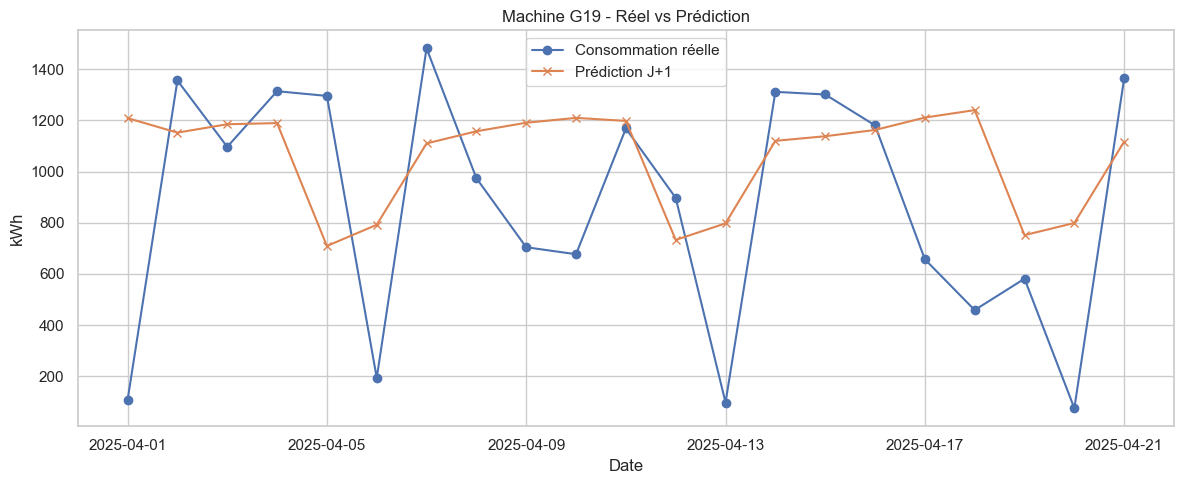

✅ G26 | MAE test: 413.60 | RMSE: 502.05 | R²: 0.294 | Overfitting: False


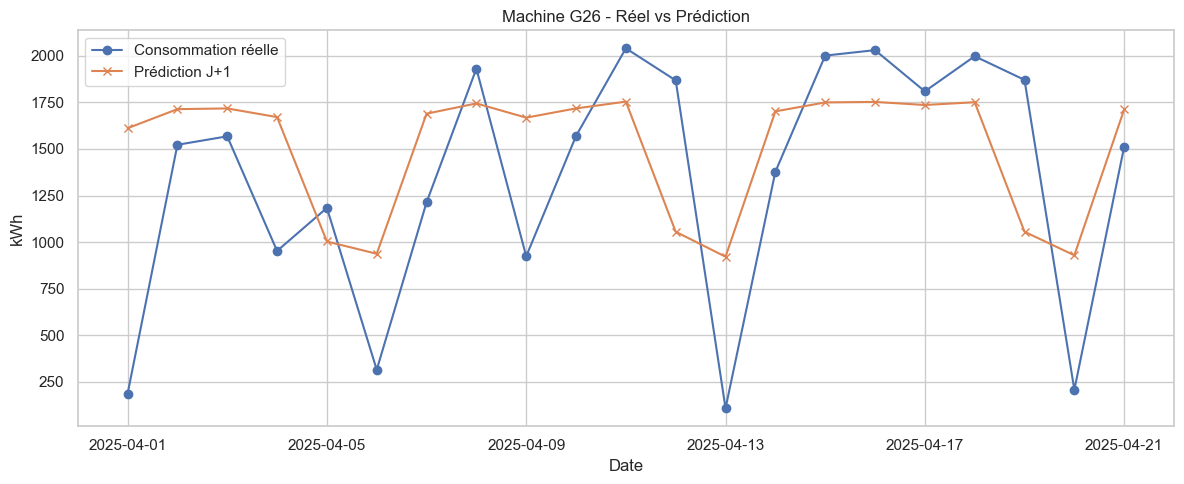

✅ MISFAT 3 D18 | MAE test: 187.85 | RMSE: 217.06 | R²: 0.215 | Overfitting: False


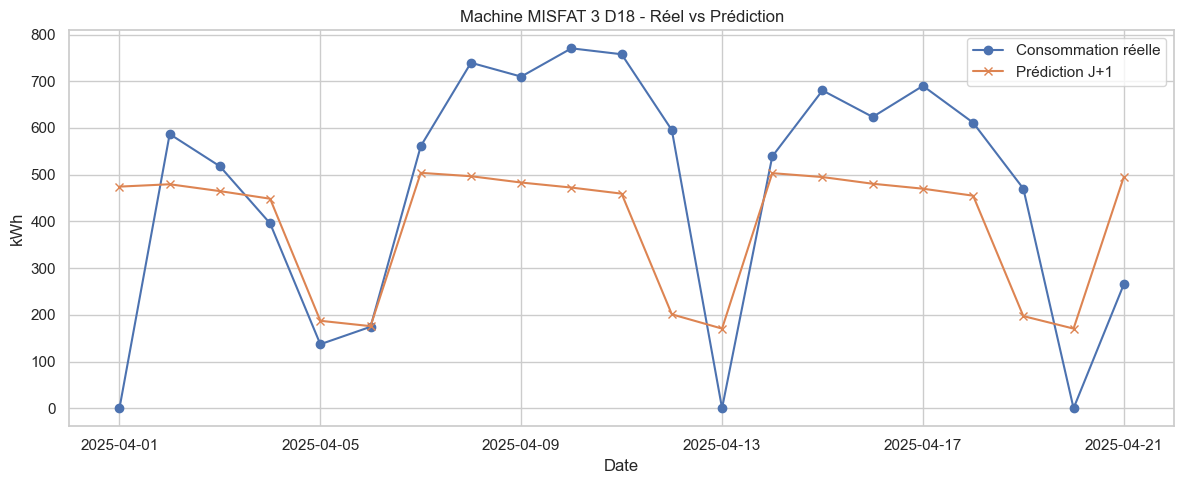

✅ MISFAT 3 D02.01 M43 | MAE test: 72.35 | RMSE: 88.46 | R²: -0.606 | Overfitting: False


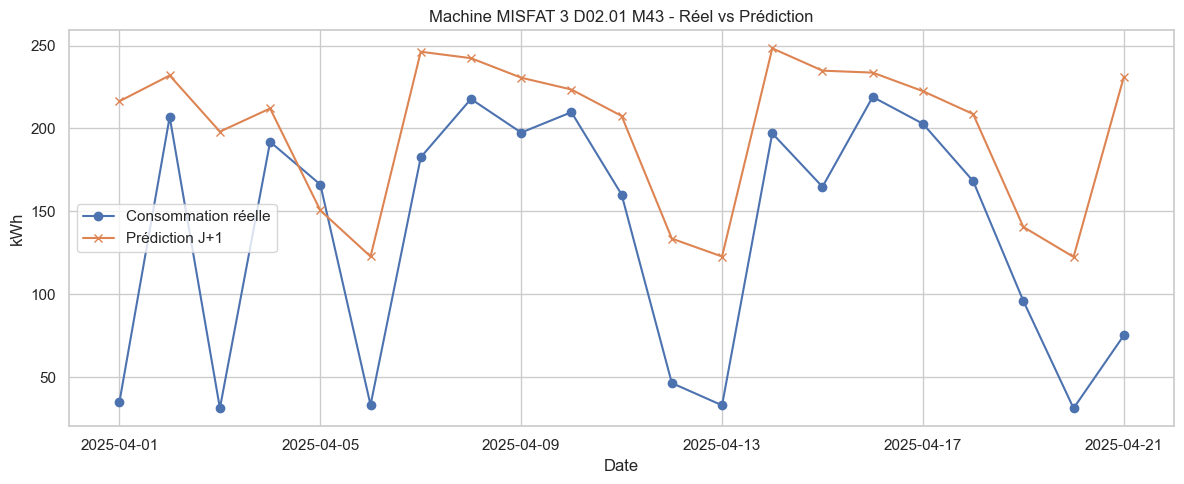

✅ MISFAT 3 Eclairage 3-2 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


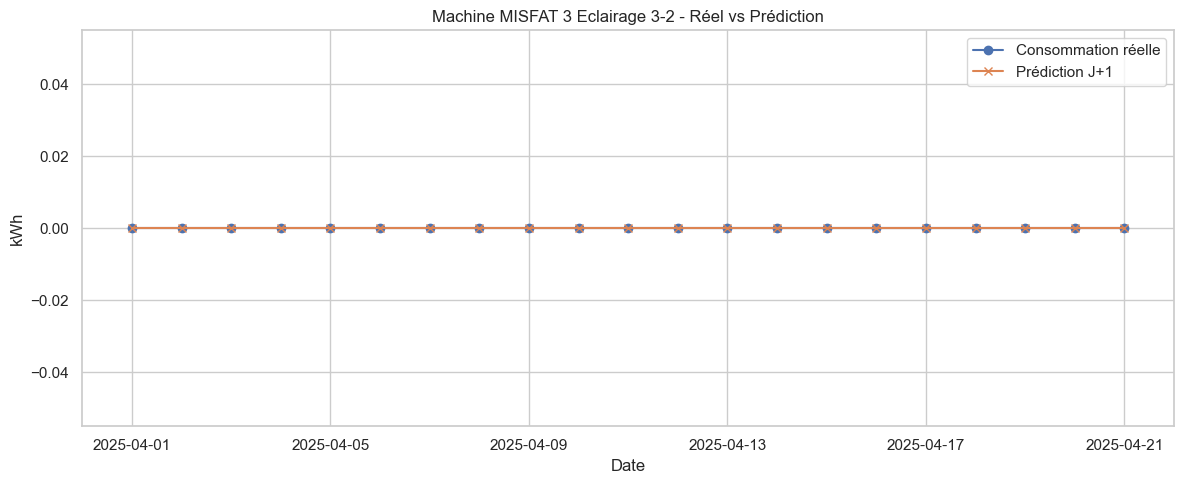

✅ MISFAT 3 G10 | MAE test: 26.22 | RMSE: 37.56 | R²: 0.015 | Overfitting: False


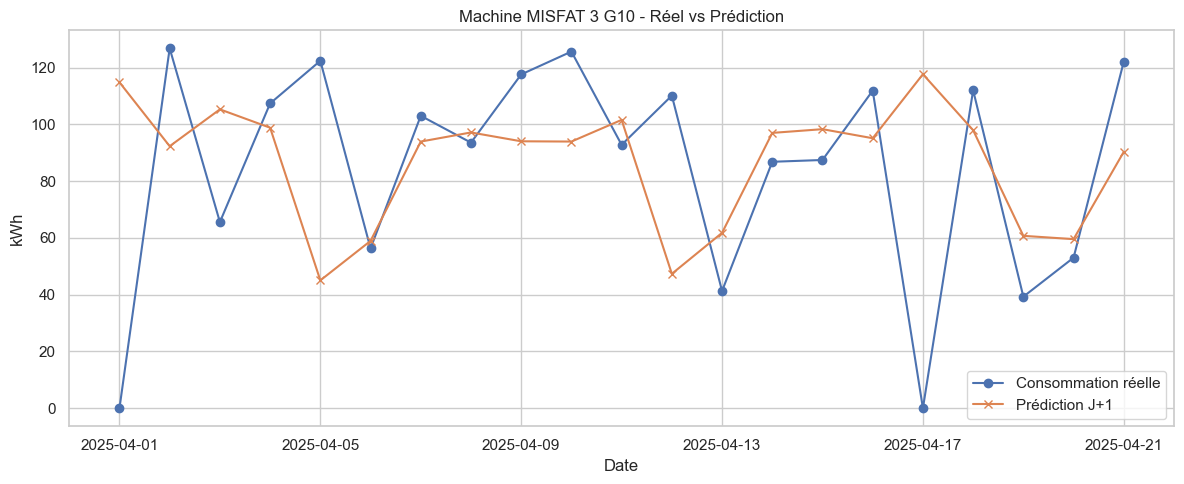

✅ MISFAT 3 G33 | MAE test: 250.28 | RMSE: 331.75 | R²: 0.045 | Overfitting: True


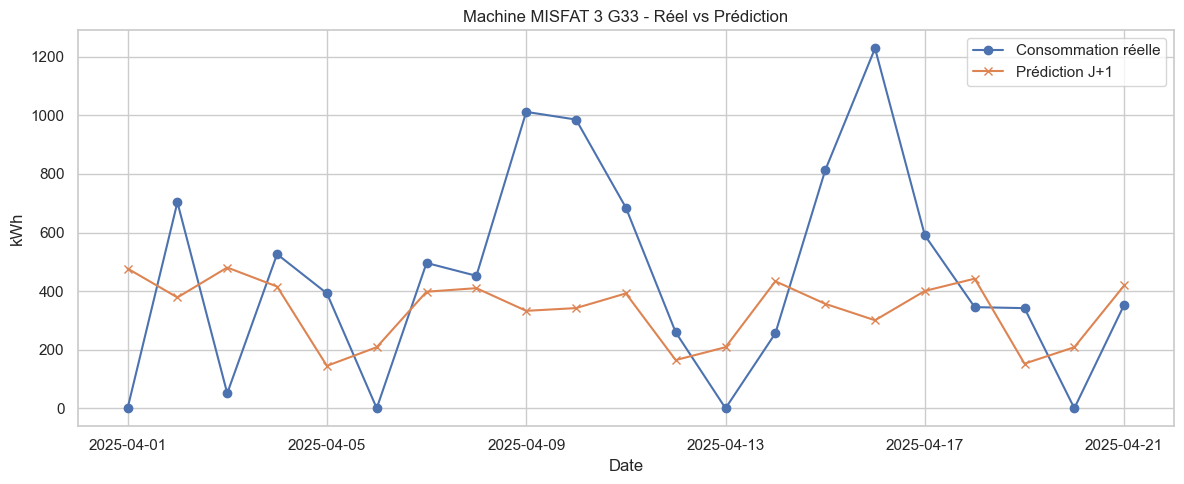

✅ MISFAT 3 G39 | MAE test: 264.59 | RMSE: 290.40 | R²: 0.057 | Overfitting: True


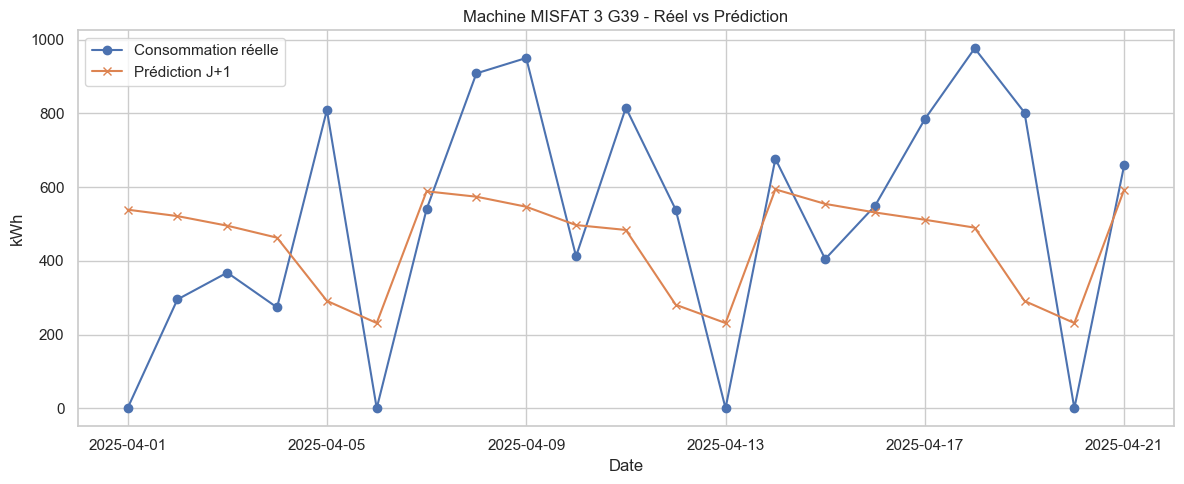

✅ MISFAT 3 H39 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


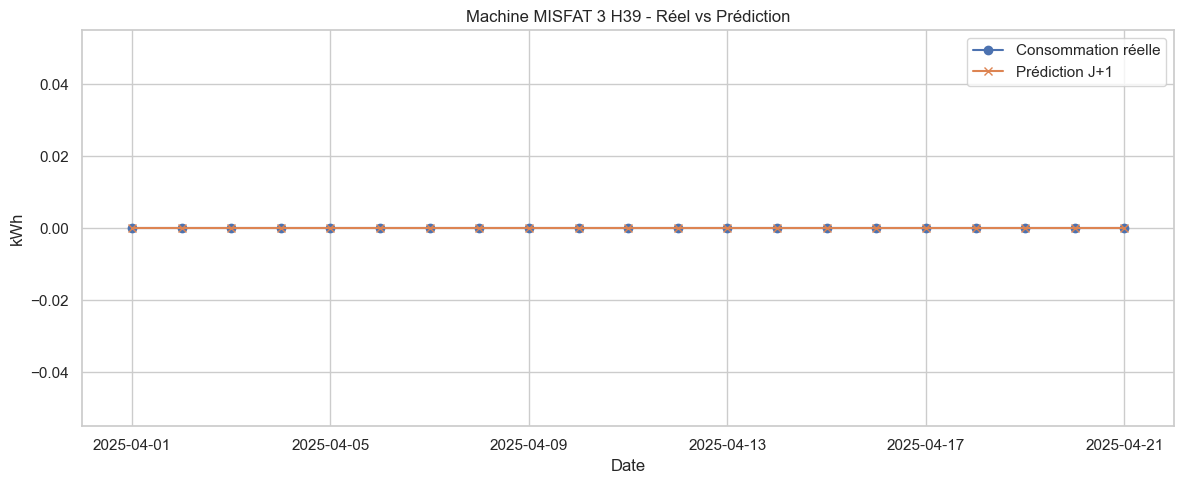

✅ MISFAT 3 H46 | MAE test: 126.91 | RMSE: 162.59 | R²: -1.087 | Overfitting: True


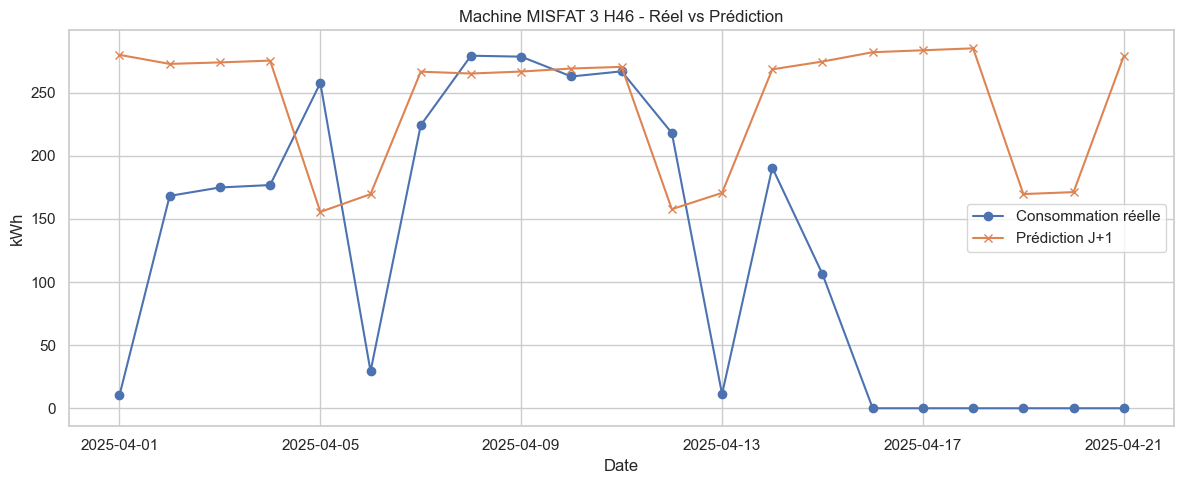

✅ MISFAT 3 H53 | MAE test: 49.01 | RMSE: 60.33 | R²: -0.991 | Overfitting: True


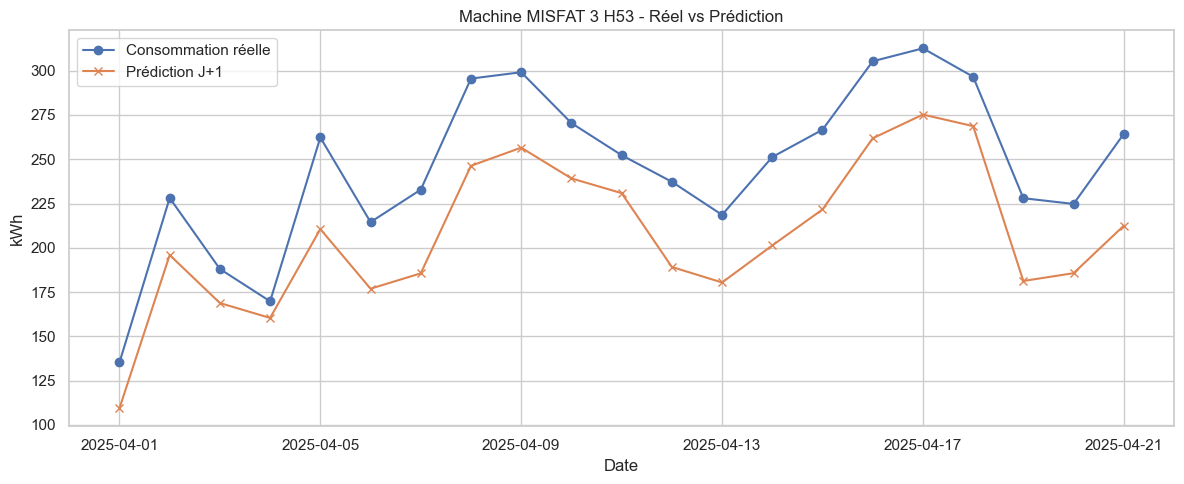

✅ MISFAT 3 N11 | MAE test: 35.08 | RMSE: 42.69 | R²: -1.218 | Overfitting: False


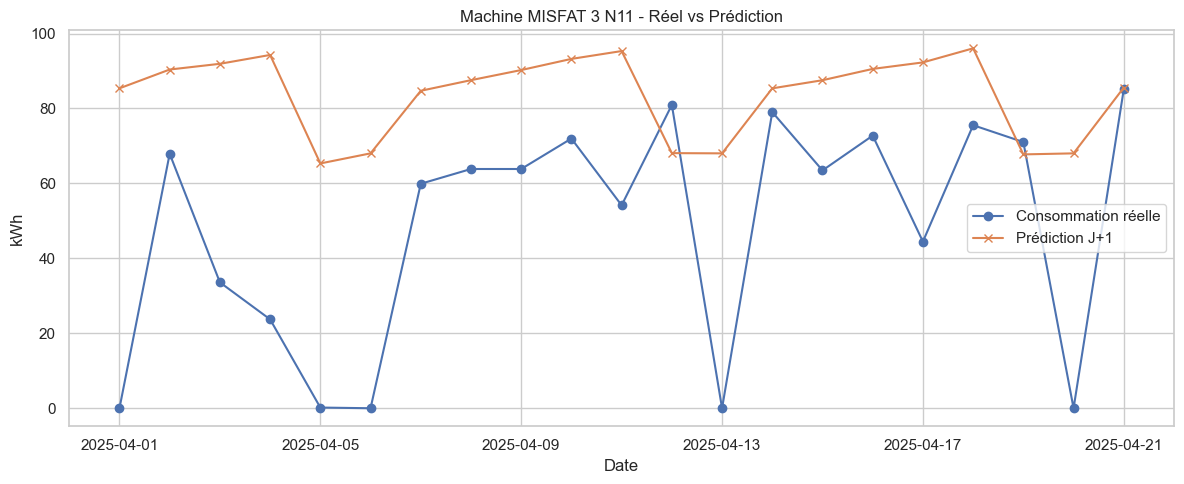

✅ total_consumption | MAE test: 1065.49 | RMSE: 1298.46 | R²: 0.421 | Overfitting: False


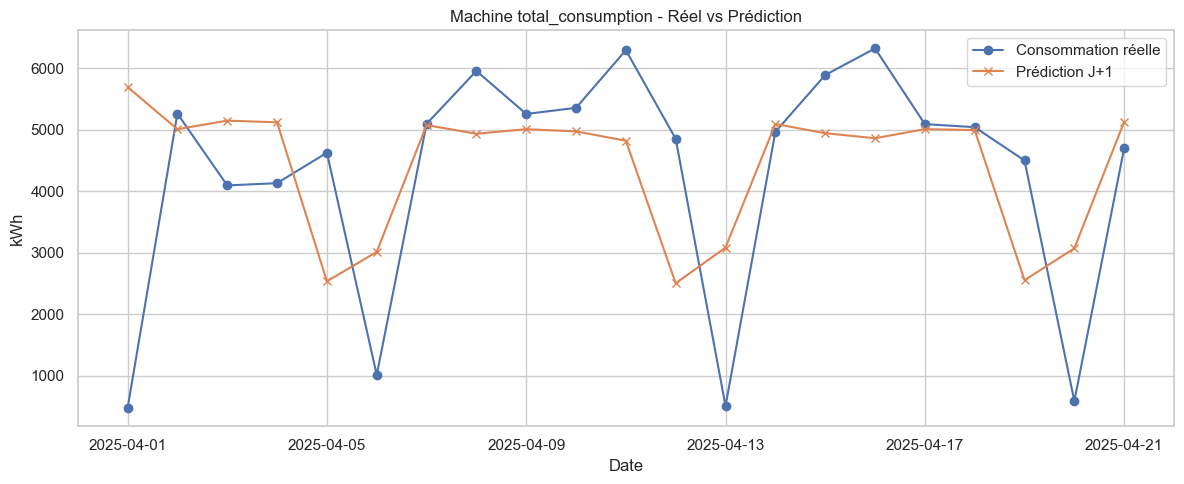


🌍 Scores globaux (régression linéaire + features temporelles) :
🔸 MAE  : 244.17
🔸 MSE  : 310483.54
🔸 RMSE : 557.21
🔸 R²   : 0.8029
🔍 Overfitting global ? Non (MAE train moy: 206.73, test moy: 222.19)

📈 Scores par machine :
                   Machine    MAE_train     MAE_test           MSE  \
0                      G19   327.309094   397.061215  2.202370e+05   
1                      G26   428.202239   413.602955  2.520545e+05   
2             MISFAT 3 D18   159.983370   187.853192  4.711307e+04   
3      MISFAT 3 D02.01 M43    89.081585    72.350811  7.824810e+03   
4   MISFAT 3 Eclairage 3-2     0.000000     0.000000  0.000000e+00   
5             MISFAT 3 G10    32.153597    26.224372  1.410499e+03   
6             MISFAT 3 G33   204.192243   250.275308  1.100611e+05   
7             MISFAT 3 G39   201.958508   264.586124  8.433060e+04   
8             MISFAT 3 H39     0.000000     0.000000  0.000000e+00   
9             MISFAT 3 H46    50.095627   126.912716  2.643577e+04   
10   

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration graphique
sns.set(style="whitegrid")

# Résultats stockés ici
all_results = []
scores = []

for machine in df.columns:
    try:
        # 1. Agrégation journalière
        df_machine = df[[machine]].copy().resample('D').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna().reset_index()

        # 2. Génération de y_next (consommation J+1)
        df_machine['y_next'] = df_machine['y'].shift(-1)

        # 3. Ajout de variables temporelles
        df_machine['day_of_week'] = df_machine['Timestamp'].dt.dayofweek  # 0 = lundi
        df_machine['is_weekend'] = df_machine['day_of_week'].isin([5, 6]).astype(int)
        df_machine['month'] = df_machine['Timestamp'].dt.month
        df_machine['season'] = df_machine['month'] % 12 // 3 + 1  # 1=Hiver, 2=Printemps, 3=Été, 4=Automne

        # 4. Suppression des lignes incomplètes
        df_machine = df_machine.dropna()

        # 5. Séparation train/test
        train = df_machine[df_machine['Timestamp'] < '2025-04-01'].copy()
        test = df_machine[df_machine['Timestamp'] >= '2025-04-01'].copy()

        if len(train) < 2 or len(test) < 2:
            print(f"⚠️ Machine {machine} ignorée (jeu de données trop petit)")
            continue

        # 6. Entraînement
        features = ['y', 'day_of_week', 'is_weekend', 'month', 'season']
        model = LinearRegression()
        model.fit(train[features], train['y_next'])

        # 7. Prédiction
        train['y_pred_train'] = model.predict(train[features])
        test['y_pred'] = model.predict(test[features])

        # 8. Évaluation
        mae_train = mean_absolute_error(train['y_next'], train['y_pred_train'])
        mae_test = mean_absolute_error(test['y_next'], test['y_pred'])
        rmse = np.sqrt(mean_squared_error(test['y_next'], test['y_pred']))
        r2 = r2_score(test['y_next'], test['y_pred'])
        mse = mean_squared_error(test['y_next'], test['y_pred'])

        overfitting = mae_test > 1.2 * mae_train

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Overfitting': overfitting
        })

        print(f"✅ {machine} | MAE test: {mae_test:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f} | Overfitting: {overfitting}")

        # 9. Préparation résultats
        result = pd.DataFrame({
            'Timestamp': test['Timestamp'],
            'Jour': test['Timestamp'].dt.day_name(),
            'Machine': machine,
            'Consommation_réelle_(kWh)': test['y'],
            'Consommation_prédite_jour_suivant_(kWh)': test['y_pred']
        })
        all_results.append(result)

        # 10. Visualisation
        plt.figure(figsize=(12, 5))
        plt.plot(result['Timestamp'], result['Consommation_réelle_(kWh)'], label='Consommation réelle', marker='o')
        plt.plot(result['Timestamp'], result['Consommation_prédite_jour_suivant_(kWh)'], label='Prédiction J+1', marker='x')
        plt.title(f'Machine {machine} - Réel vs Prédiction')
        plt.xlabel('Date')
        plt.ylabel('kWh')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} :", str(e))

# 11. Fusion des résultats
df_previsions = pd.concat(all_results, ignore_index=True)
df_scores = pd.DataFrame(scores)

# 12. Scores globaux
try:
    df_eval_global = df_previsions.dropna()
    y_true_global = df_eval_global['Consommation_réelle_(kWh)']
    y_pred_global = df_eval_global['Consommation_prédite_jour_suivant_(kWh)']

    mae_global_lr = mean_absolute_error(y_true_global, y_pred_global)
    mse_global_lr = mean_squared_error(y_true_global, y_pred_global)
    rmse_global_lr = np.sqrt(mse_global_lr)
    r2_global_lr = r2_score(y_true_global, y_pred_global)

    print("\n🌍 Scores globaux (régression linéaire + features temporelles) :")
    print(f"🔸 MAE  : {mae_global_lr:.2f}")
    print(f"🔸 MSE  : {mse_global_lr:.2f}")
    print(f"🔸 RMSE : {rmse_global_lr:.2f}")
    print(f"🔸 R²   : {r2_global_lr:.4f}")

    # Détection overfitting global
    mae_train_moy = df_scores['MAE_train'].mean()
    mae_test_moy = df_scores['MAE_test'].mean()
    overfitting_global = mae_test_moy > 1.2 * mae_train_moy
    print(f"🔍 Overfitting global ? {'Oui' if overfitting_global else 'Non'} (MAE train moy: {mae_train_moy:.2f}, test moy: {mae_test_moy:.2f})")

except Exception as e:
    print("❌ Erreur score global :", str(e))

# 13. Résumés
print("\n📈 Scores par machine :")
print(df_scores)

print("\n🔍 Exemple de prévisions :")
print(df_previsions.head())


In [85]:
df_previsions.head()

Timestamp       Jour Machine  Consommation_réelle_(kWh)  \
0 2025-04-01    Tuesday     G19                  106.71875   
1 2025-04-02  Wednesday     G19                 1355.93750   
2 2025-04-03   Thursday     G19                 1096.56250   
3 2025-04-04     Friday     G19                 1314.03125   
4 2025-04-05   Saturday     G19                 1295.65625   

   Consommation_prédite_jour_suivant_(kWh)  
0                              1208.828018  
1                              1152.115478  
2                              1184.868389  
3                              1189.342619  
4                               709.017746

✅ G19 | MAE test: 1513.05 | RMSE: 2470.44 | R²: -0.688 | Overfitting: True


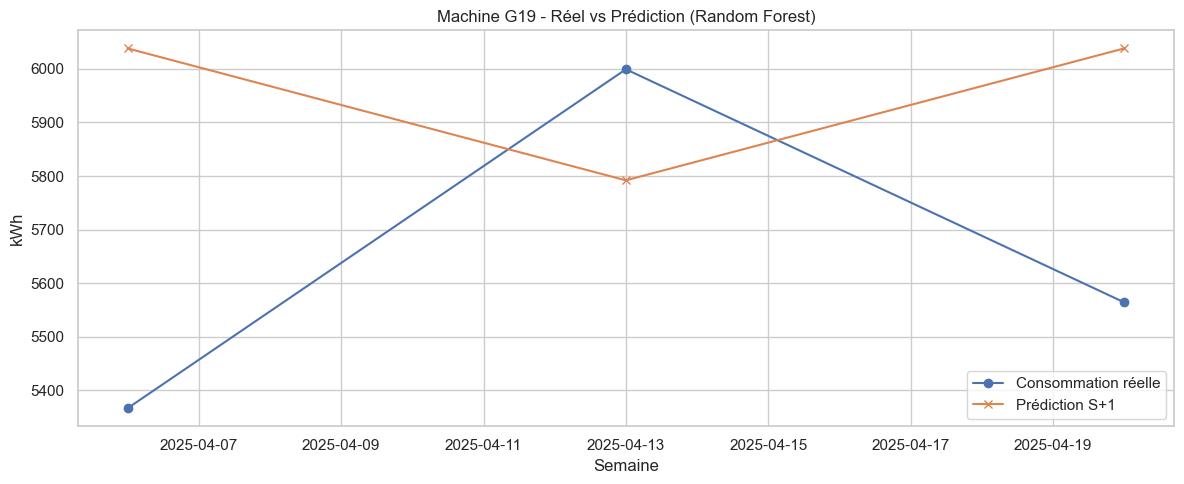

✅ G26 | MAE test: 3101.94 | RMSE: 3391.86 | R²: 0.222 | Overfitting: True


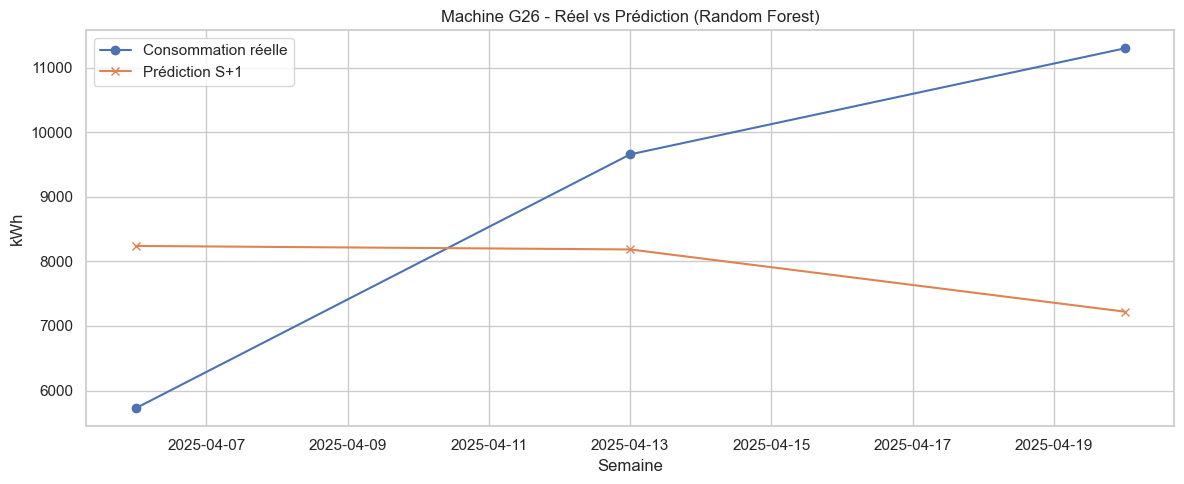

✅ MISFAT 3 D18 | MAE test: 1615.38 | RMSE: 1643.93 | R²: -0.011 | Overfitting: True


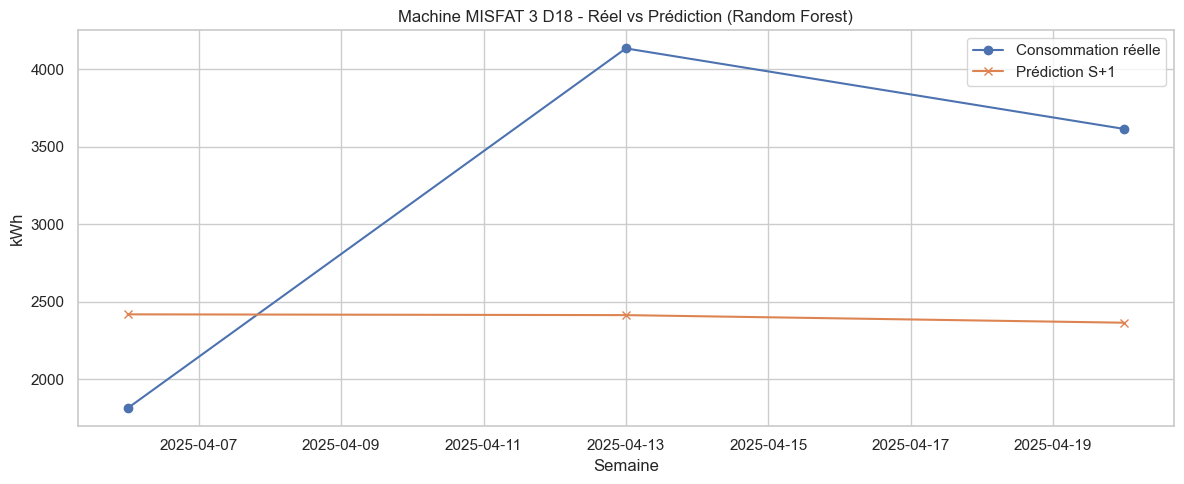

✅ MISFAT 3 D02.01 M43 | MAE test: 367.58 | RMSE: 496.66 | R²: -0.402 | Overfitting: True


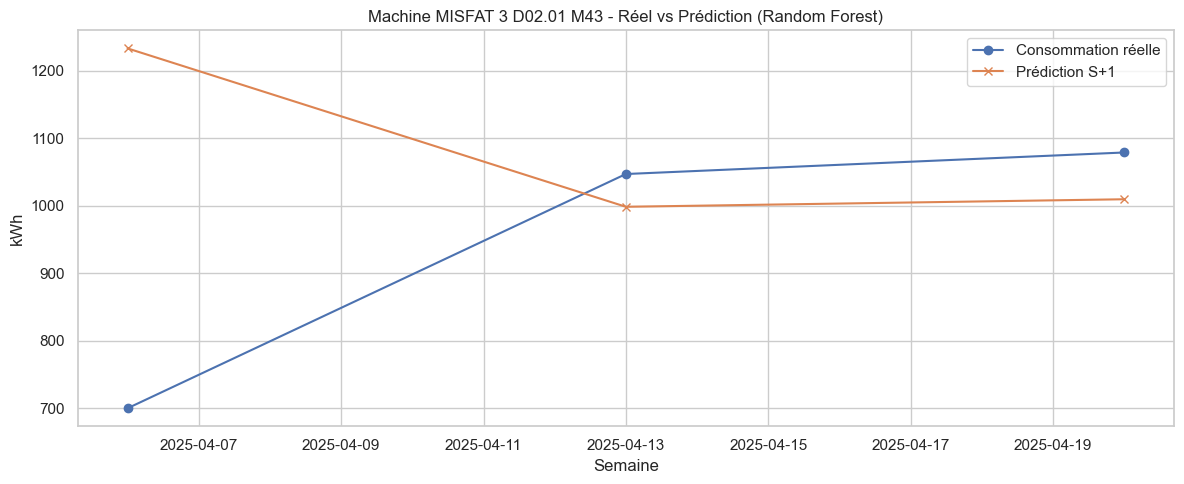

✅ MISFAT 3 Eclairage 3-2 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


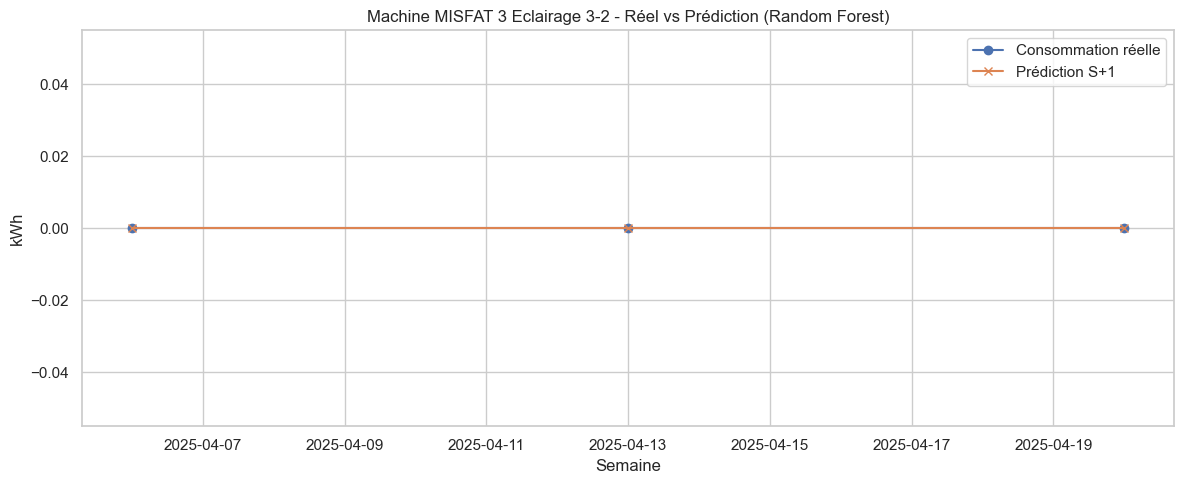

✅ MISFAT 3 G10 | MAE test: 202.36 | RMSE: 261.92 | R²: -0.289 | Overfitting: True


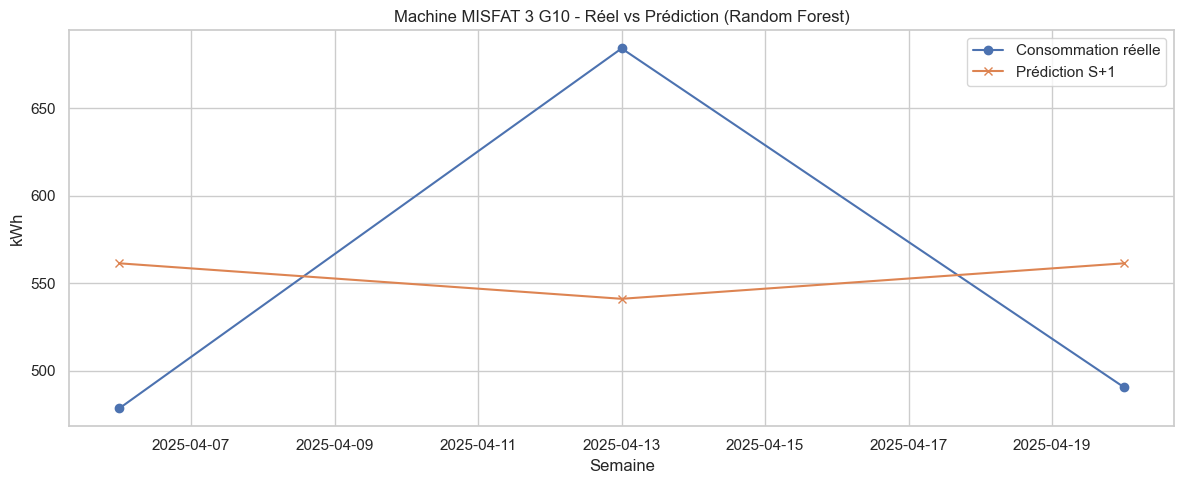

✅ MISFAT 3 G33 | MAE test: 1553.84 | RMSE: 1556.85 | R²: -0.077 | Overfitting: True


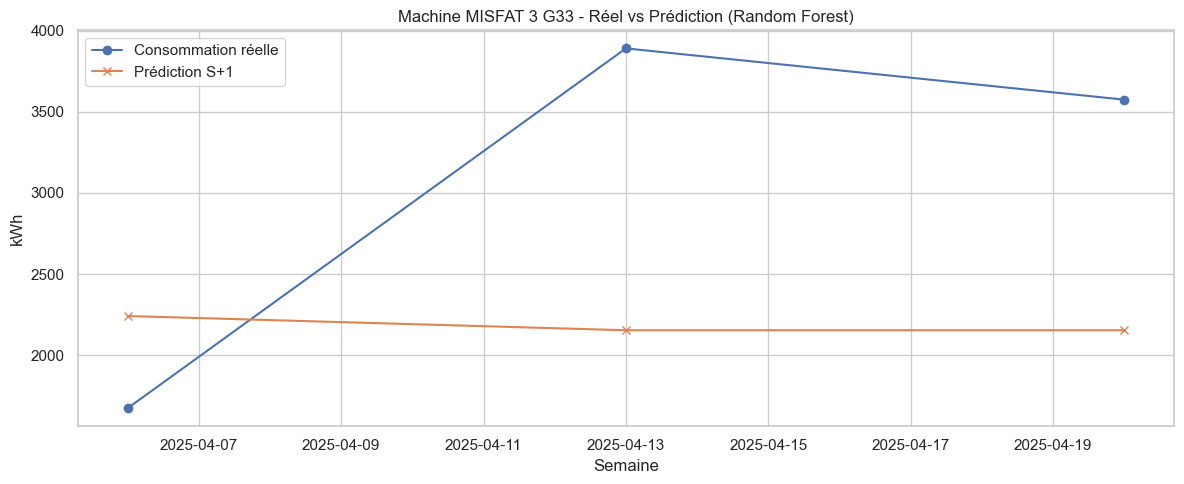

✅ MISFAT 3 G39 | MAE test: 1743.33 | RMSE: 1766.36 | R²: -0.515 | Overfitting: True


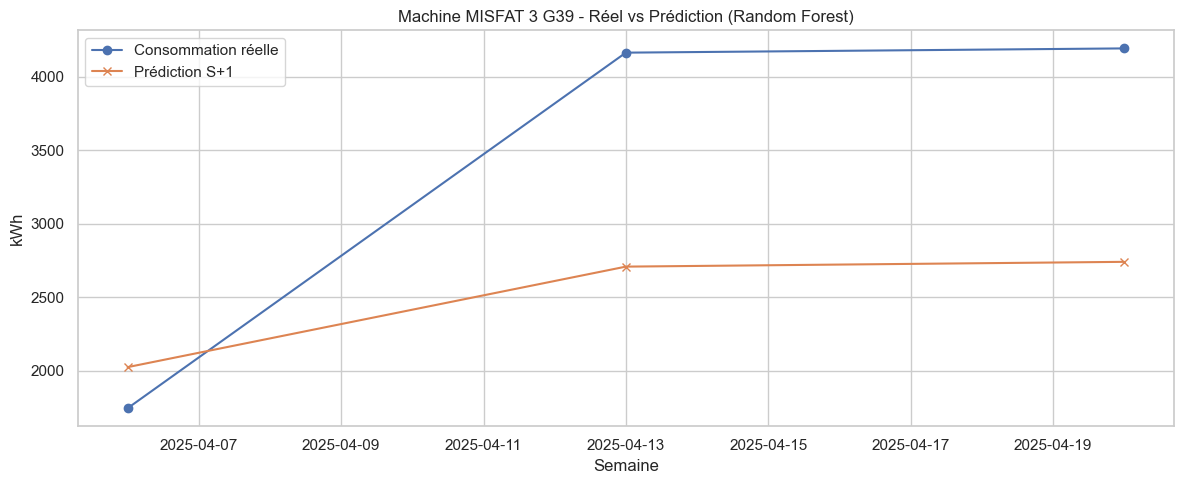

✅ MISFAT 3 H39 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


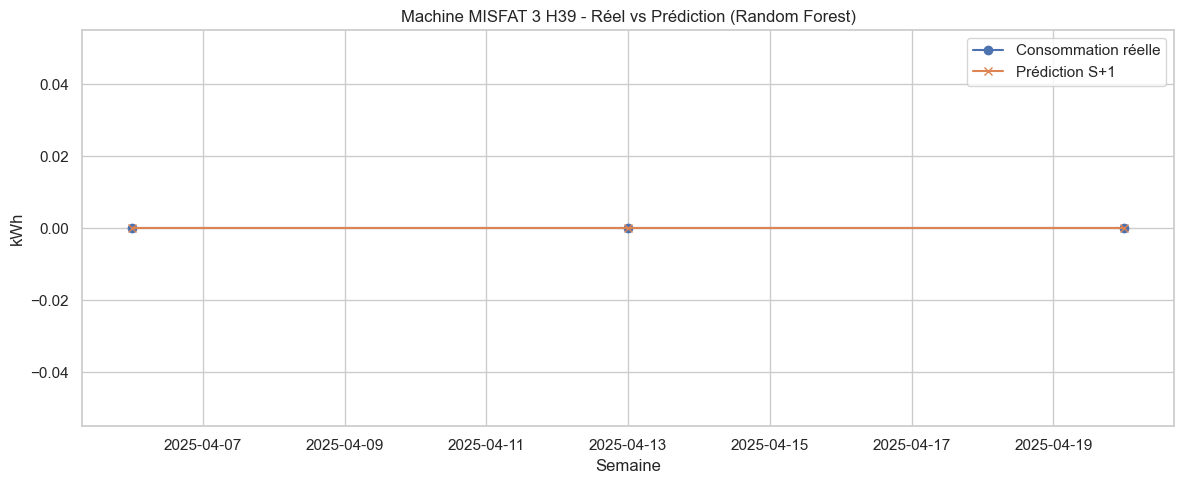

✅ MISFAT 3 H46 | MAE test: 768.79 | RMSE: 795.65 | R²: -0.419 | Overfitting: True


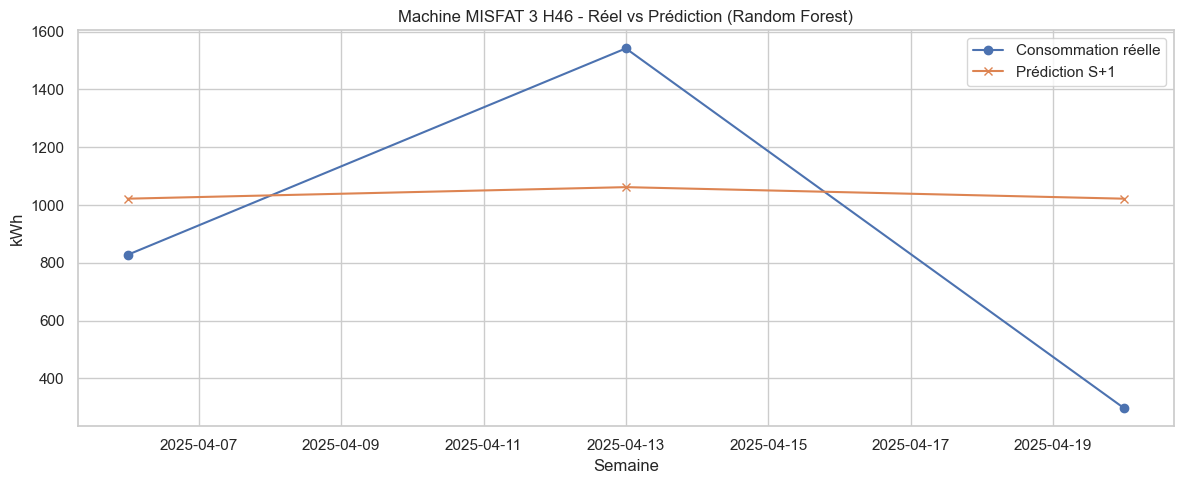

✅ MISFAT 3 H53 | MAE test: 650.41 | RMSE: 694.06 | R²: -0.060 | Overfitting: True


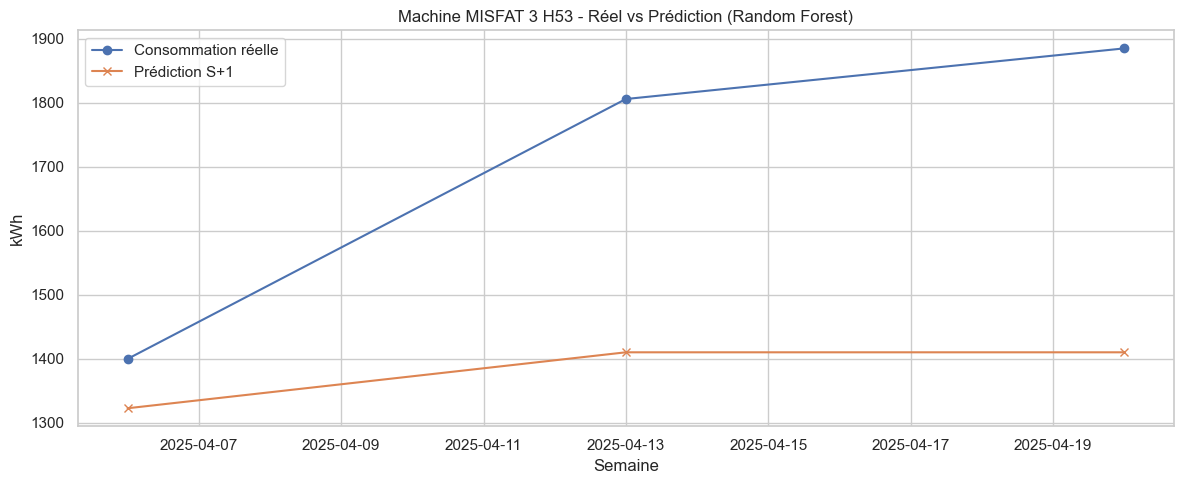

✅ MISFAT 3 N11 | MAE test: 125.83 | RMSE: 126.34 | R²: -0.131 | Overfitting: True


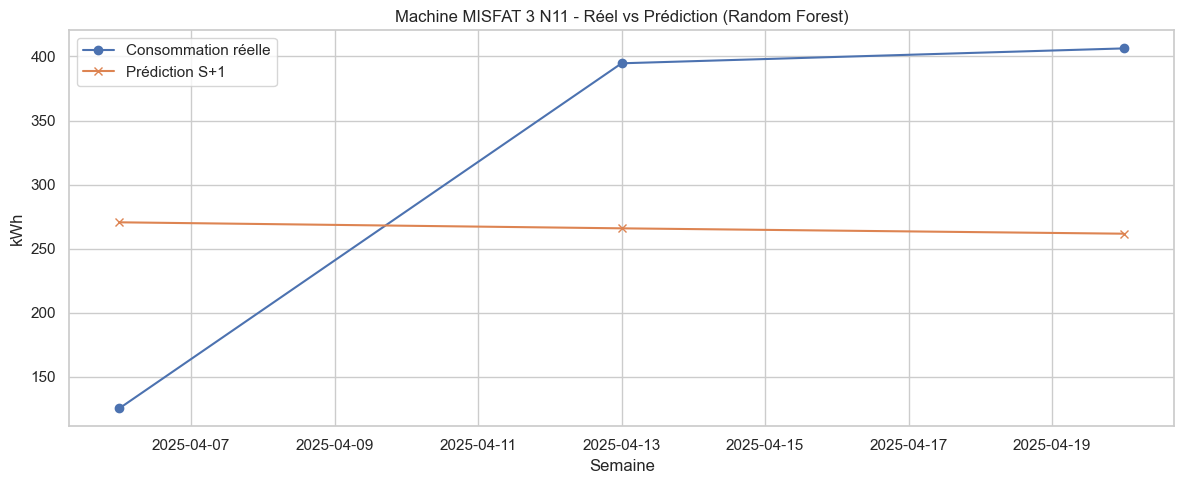

✅ total_consumption | MAE test: 11684.65 | RMSE: 12315.40 | R²: -0.036 | Overfitting: True


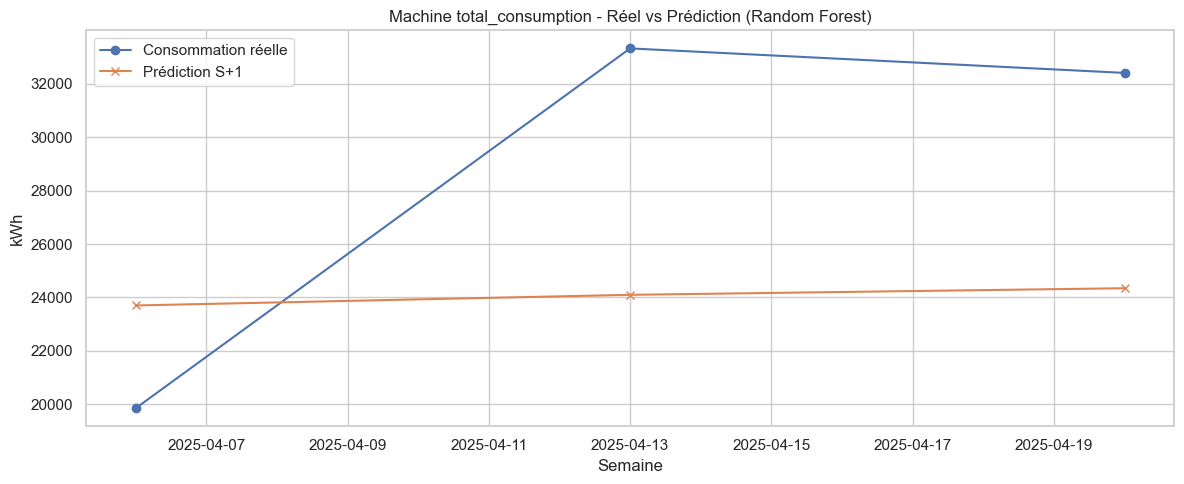


🌍 Scores globaux (Random Forest hebdo) :
🔸 MAE  : 1147.04
🔸 MSE  : 5297010.90
🔸 RMSE : 2301.52
🔸 R²   : 0.9090
🔍 Overfitting global ? Oui (MAE train moy: 273.52, test moy: 1794.40)

📈 Scores par machine :
                   Machine    MAE_train      MAE_test           MSE  \
0                      G19   409.682428   1513.054010  6.103095e+06   
1                      G26   577.373269   3101.942917  1.150469e+07   
2             MISFAT 3 D18   196.468413   1615.376250  2.702490e+06   
3      MISFAT 3 D02.01 M43   137.532236    367.576745  2.466697e+05   
4   MISFAT 3 Eclairage 3-2     0.000000      0.000000  0.000000e+00   
5             MISFAT 3 G10    28.036719    202.358040  6.860177e+04   
6             MISFAT 3 G33   246.427353   1553.844505  2.423780e+06   
7             MISFAT 3 G39   278.637163   1743.332083  3.120039e+06   
8             MISFAT 3 H39     0.000000      0.000000  0.000000e+00   
9             MISFAT 3 H46    61.803645    768.785911  6.330543e+05   
10           

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration graphique
sns.set(style="whitegrid")

# Résultats stockés ici
all_results = []
scores = []

for machine in df.columns:
    try:
        # 1. Agrégation hebdomadaire
        df_machine = df[[machine]].copy().resample('W').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna().reset_index()

        # 2. Génération de y_next (consommation S+1)
        df_machine['y_next'] = df_machine['y'].shift(-1)

        # 3. Ajout de variables temporelles
        df_machine['week'] = df_machine['Timestamp'].dt.isocalendar().week
        df_machine['month'] = df_machine['Timestamp'].dt.month
        df_machine['season'] = df_machine['month'] % 12 // 3 + 1  # 1=Hiver, 2=Printemps, etc.

        # 4. Suppression des lignes incomplètes
        df_machine = df_machine.dropna()

        # 5. Séparation train/test
        train = df_machine[df_machine['Timestamp'] < '2025-04-01'].copy()
        test = df_machine[df_machine['Timestamp'] >= '2025-04-01'].copy()

        if len(train) < 5 or len(test) < 2:
            print(f"⚠️ Machine {machine} ignorée (jeu de données hebdomadaire trop petit)")
            continue

        # 6. Entraînement avec RandomForest
        features = ['y', 'week', 'month', 'season']
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(train[features], train['y_next'])

        # 7. Prédictions
        train['y_pred_train'] = model.predict(train[features])
        test['y_pred'] = model.predict(test[features])

        # 8. Évaluation
        mae_train = mean_absolute_error(train['y_next'], train['y_pred_train'])
        mae_test = mean_absolute_error(test['y_next'], test['y_pred'])
        rmse = np.sqrt(mean_squared_error(test['y_next'], test['y_pred']))
        r2 = r2_score(test['y_next'], test['y_pred'])
        mse = mean_squared_error(test['y_next'], test['y_pred'])

        overfitting = mae_test > 1.2 * mae_train

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Overfitting': overfitting
        })

        print(f"✅ {machine} | MAE test: {mae_test:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f} | Overfitting: {overfitting}")

        # 9. Résultats
        result = pd.DataFrame({
            'Timestamp': test['Timestamp'],
            'Semaine': test['Timestamp'].dt.strftime('Semaine %U'),
            'Machine': machine,
            'Consommation_réelle_(kWh)': test['y'],
            'Consommation_prédite_semaine_suivante_(kWh)': test['y_pred']
        })
        all_results.append(result)

        # 10. Visualisation
        plt.figure(figsize=(12, 5))
        plt.plot(result['Timestamp'], result['Consommation_réelle_(kWh)'], label='Consommation réelle', marker='o')
        plt.plot(result['Timestamp'], result['Consommation_prédite_semaine_suivante_(kWh)'], label='Prédiction S+1', marker='x')
        plt.title(f'Machine {machine} - Réel vs Prédiction (Random Forest)')
        plt.xlabel('Semaine')
        plt.ylabel('kWh')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} :", str(e))

# 11. Fusion résultats
df_previsions = pd.concat(all_results, ignore_index=True)
df_scores = pd.DataFrame(scores)

# 12. Scores globaux
try:
    df_eval_global = df_previsions.dropna()
    y_true_global = df_eval_global['Consommation_réelle_(kWh)']
    y_pred_global = df_eval_global['Consommation_prédite_semaine_suivante_(kWh)']

    mae_global_rf = mean_absolute_error(y_true_global, y_pred_global)
    mse_global_rf = mean_squared_error(y_true_global, y_pred_global)
    rmse_global_rf = np.sqrt(mse_global_rf)
    r2_global_rf = r2_score(y_true_global, y_pred_global)

    print("\n🌍 Scores globaux (Random Forest hebdo) :")
    print(f"🔸 MAE  : {mae_global_rf:.2f}")
    print(f"🔸 MSE  : {mse_global_rf:.2f}")
    print(f"🔸 RMSE : {rmse_global_rf:.2f}")
    print(f"🔸 R²   : {r2_global_rf:.4f}")

    # Overfitting global
    mae_train_moy = df_scores['MAE_train'].mean()
    mae_test_moy = df_scores['MAE_test'].mean()
    overfitting_global = mae_test_moy > 1.2 * mae_train_moy
    print(f"🔍 Overfitting global ? {'Oui' if overfitting_global else 'Non'} (MAE train moy: {mae_train_moy:.2f}, test moy: {mae_test_moy:.2f})")

except Exception as e:
    print("❌ Erreur score global :", str(e))

# 13. Résumés
print("\n📈 Scores par machine :")
print(df_scores)

print("\n🔍 Exemple de prévisions :")
print(df_previsions.head())


✅ G19 | MAE test: 1685.94 | RMSE: 2644.75 | R²: -0.934 | Overfitting: True


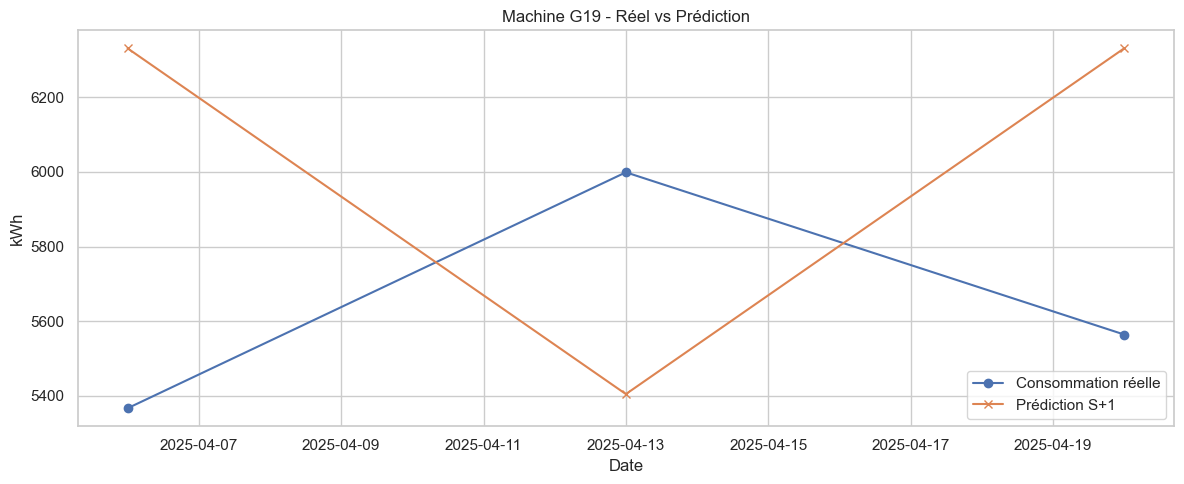

✅ G26 | MAE test: 3714.40 | RMSE: 3774.56 | R²: 0.036 | Overfitting: True


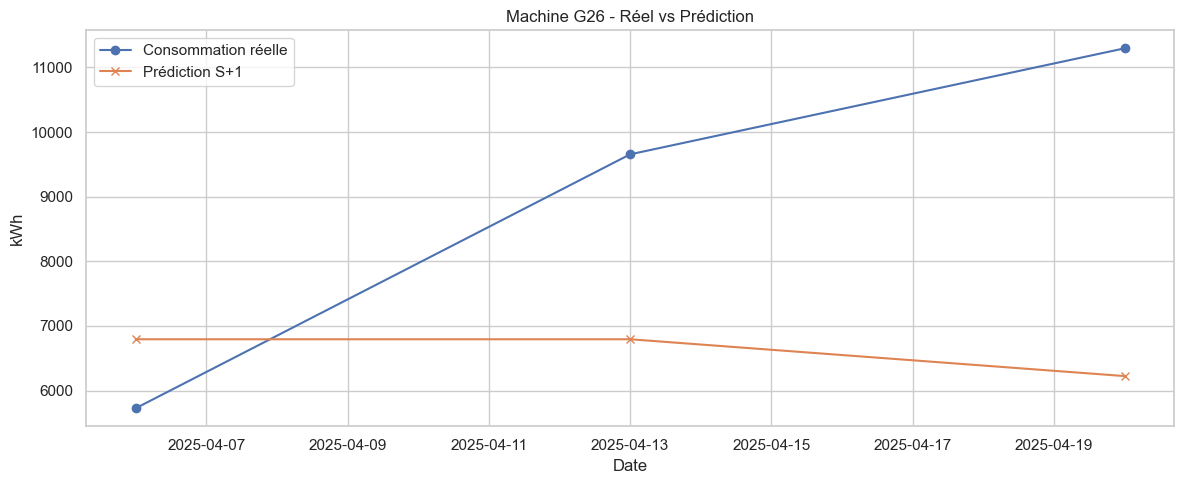

✅ MISFAT 3 D18 | MAE test: 1826.15 | RMSE: 1863.33 | R²: -0.299 | Overfitting: True


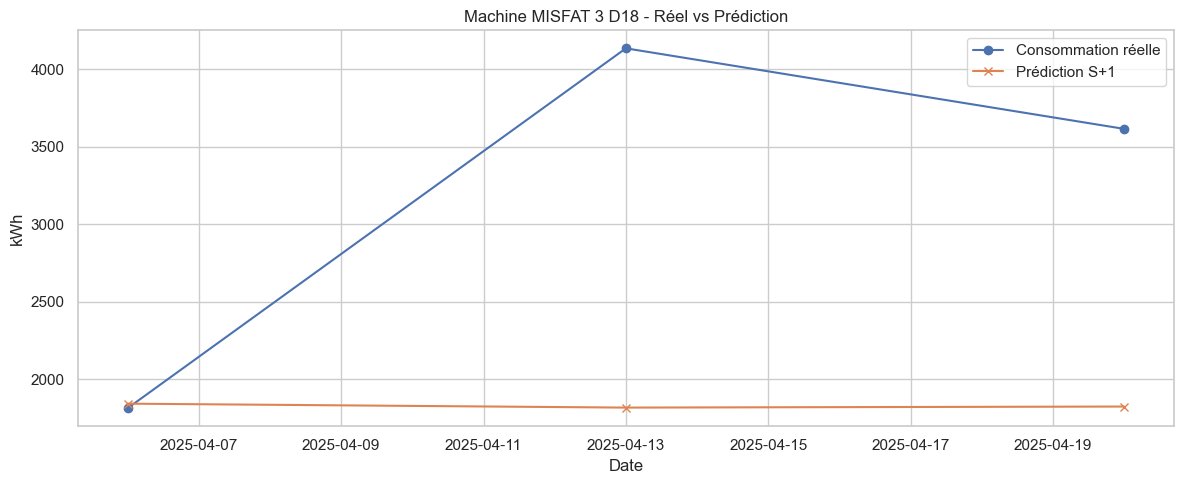

✅ MISFAT 3 D02.01 M43 | MAE test: 323.27 | RMSE: 375.71 | R²: 0.198 | Overfitting: True


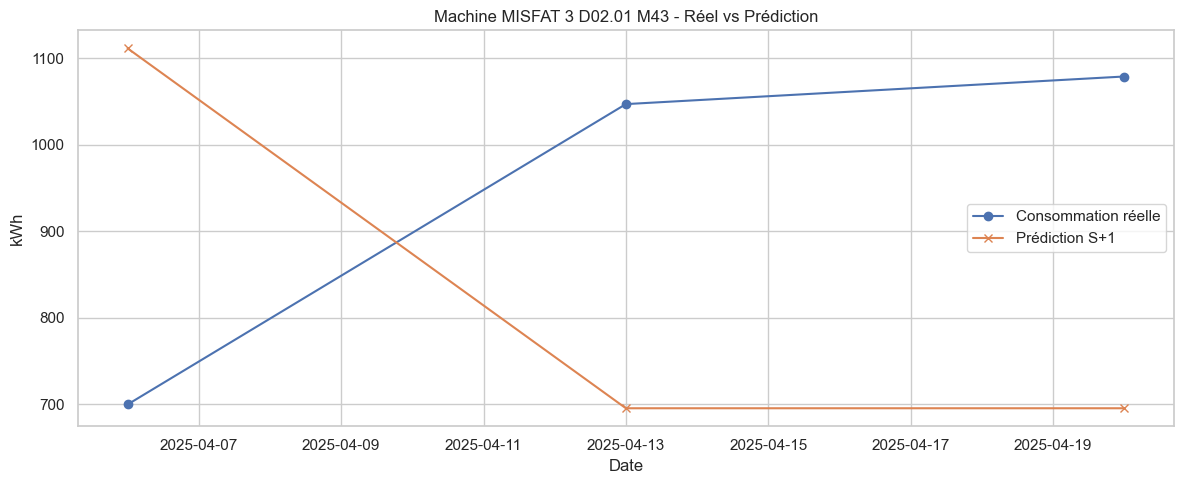

✅ MISFAT 3 Eclairage 3-2 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


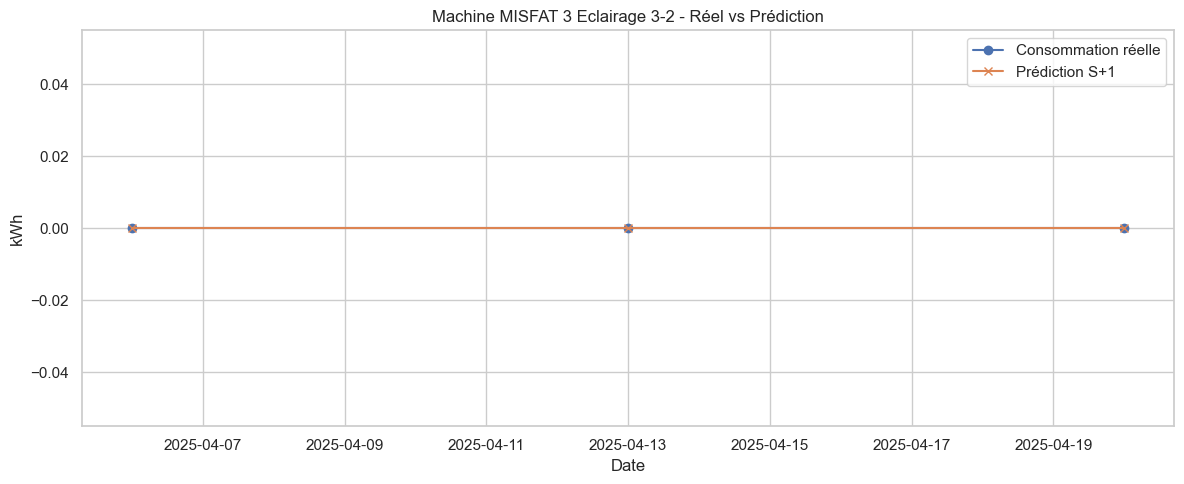

✅ MISFAT 3 G10 | MAE test: 252.64 | RMSE: 277.97 | R²: -0.452 | Overfitting: True


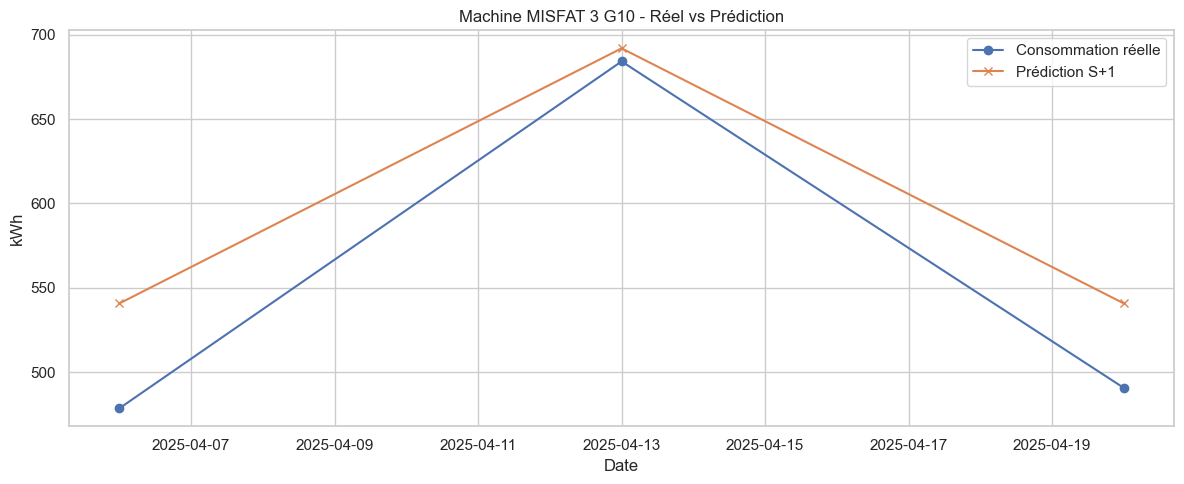

✅ MISFAT 3 G33 | MAE test: 1536.62 | RMSE: 1542.67 | R²: -0.058 | Overfitting: True


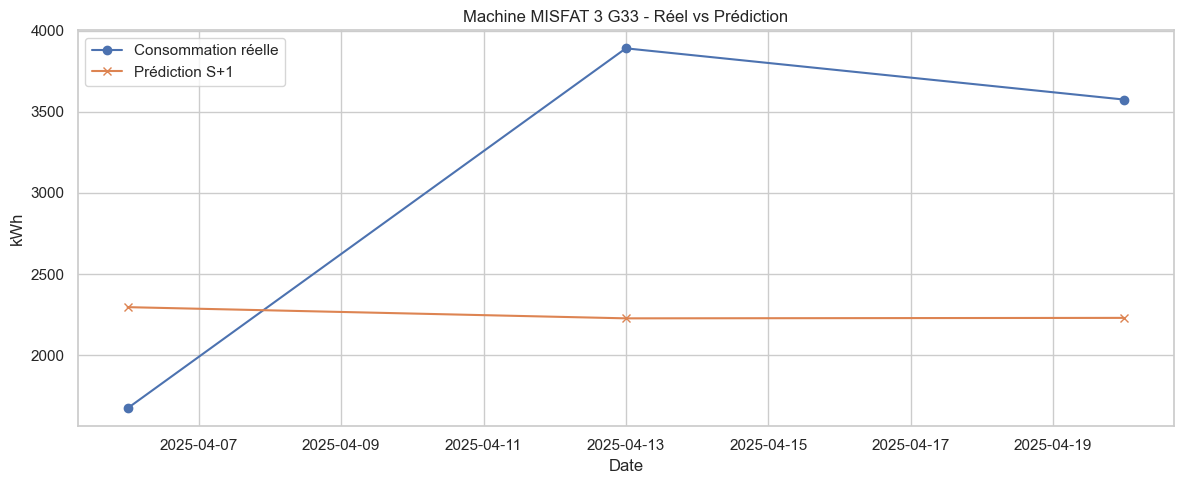

✅ MISFAT 3 G39 | MAE test: 1821.92 | RMSE: 1869.88 | R²: -0.698 | Overfitting: True


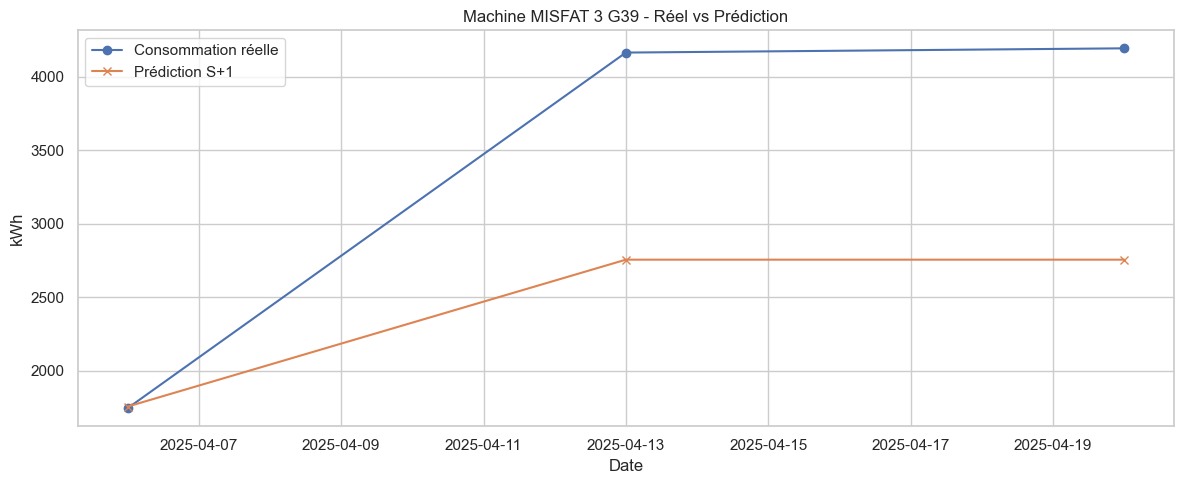

✅ MISFAT 3 H39 | MAE test: 0.00 | RMSE: 0.00 | R²: 1.000 | Overfitting: False


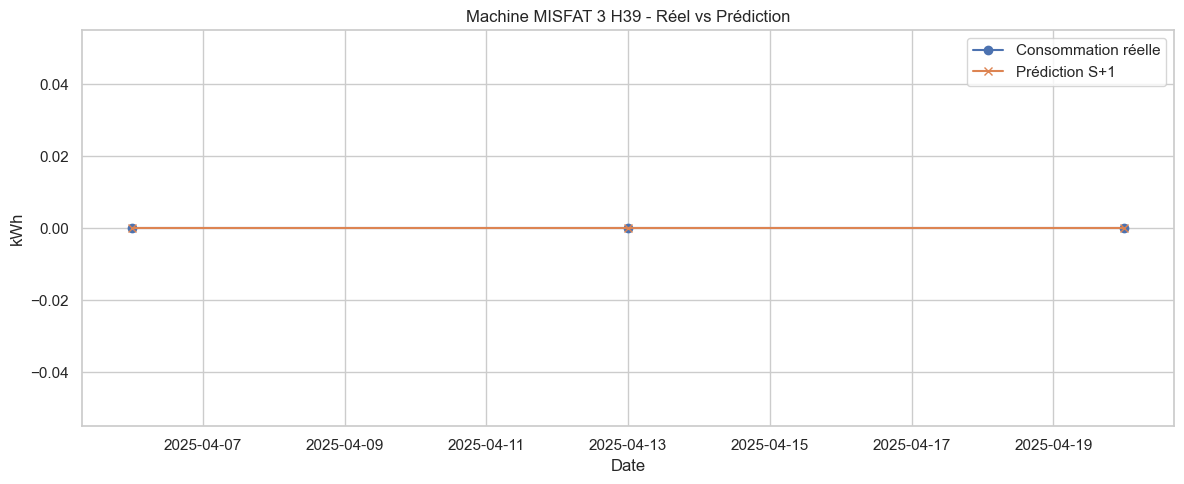

✅ MISFAT 3 H46 | MAE test: 692.13 | RMSE: 703.63 | R²: -0.110 | Overfitting: True


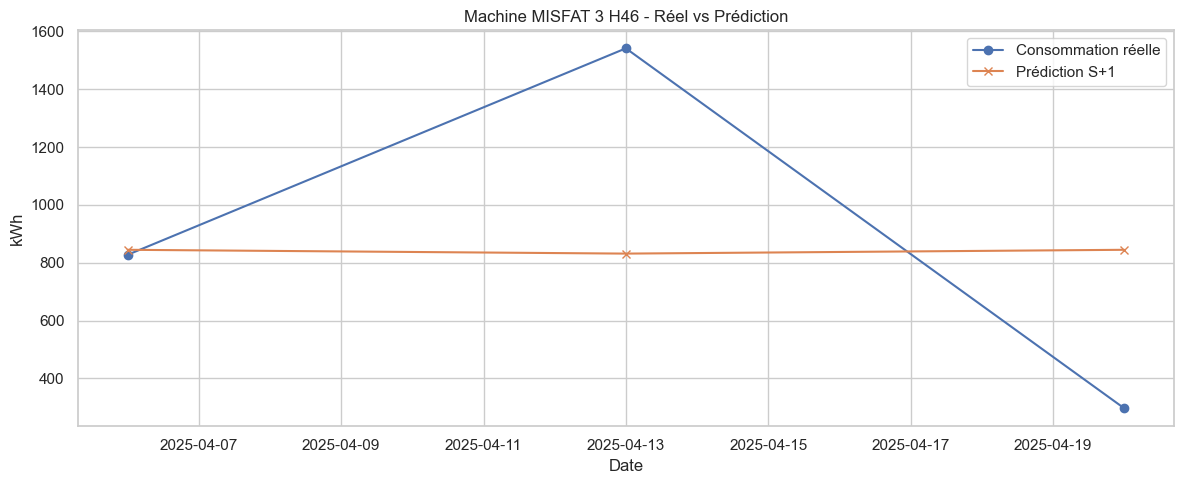

✅ MISFAT 3 H53 | MAE test: 821.33 | RMSE: 855.24 | R²: -0.610 | Overfitting: True


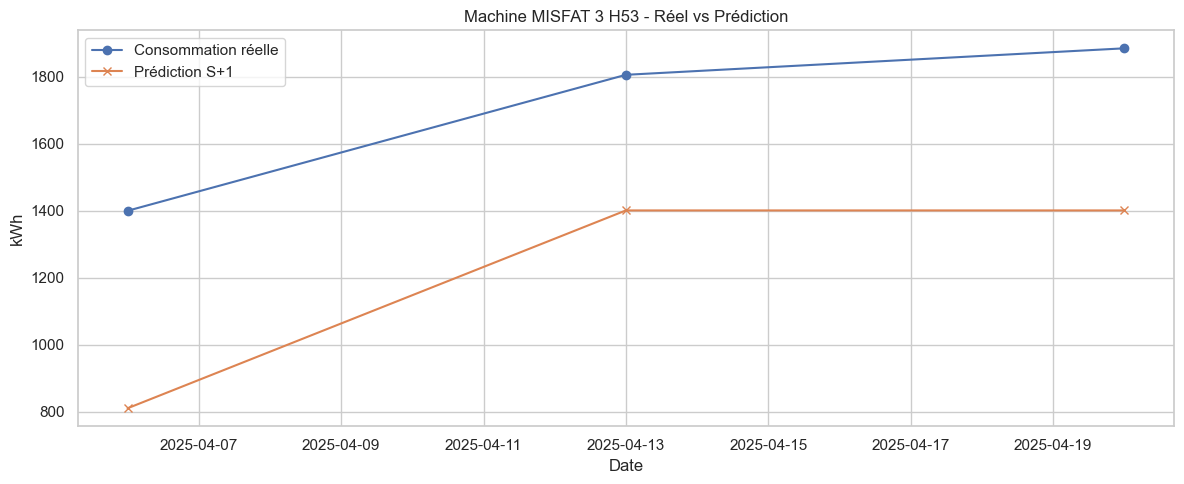

✅ MISFAT 3 N11 | MAE test: 165.92 | RMSE: 177.59 | R²: -1.236 | Overfitting: True


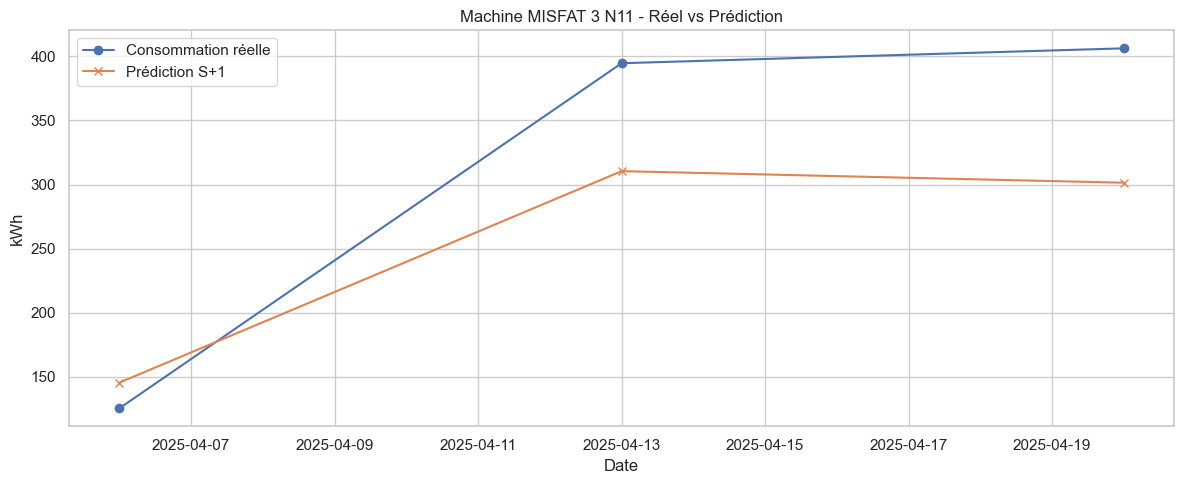

✅ total_consumption | MAE test: 12662.35 | RMSE: 12663.11 | R²: -0.096 | Overfitting: True


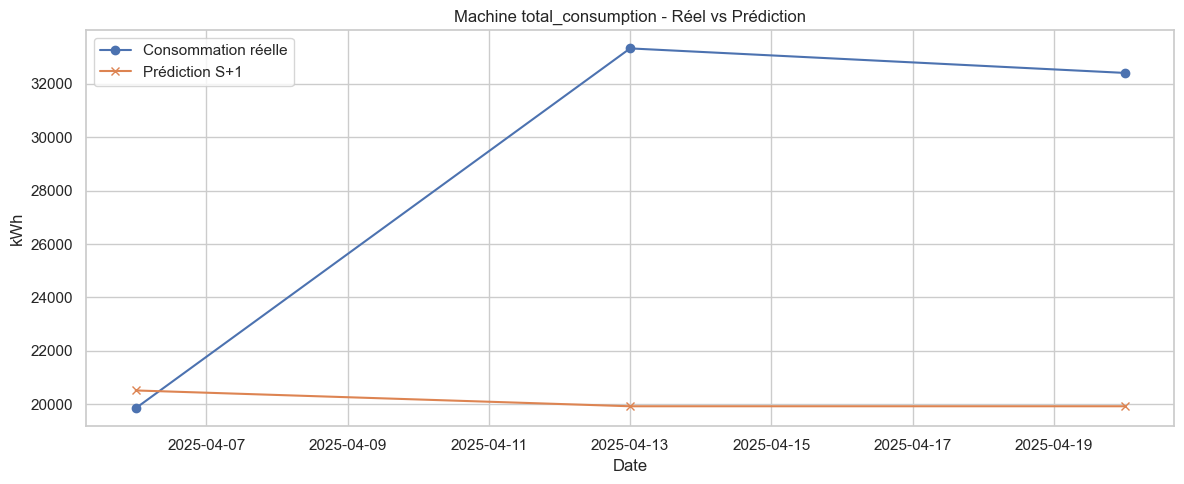


🌍 Scores globaux (XGBoost - Hebdomadaire) :
🔸 MAE  : 1351.56
🔸 MSE  : 10044920.99
🔸 RMSE : 3169.37
🔸 R²   : 0.8275
🔍 Overfitting global ? Oui (MAE train moy: 6.42, test moy: 1961.74)

📈 Scores par machine :
                   Machine  MAE_train      MAE_test           MSE  \
0                      G19   4.342961   1685.938314  6.994716e+06   
1                      G26  14.313364   3714.397786  1.424731e+07   
2             MISFAT 3 D18   8.615892   1826.153646  3.472007e+06   
3      MISFAT 3 D02.01 M43   2.139803    323.267171  1.411609e+05   
4   MISFAT 3 Eclairage 3-2   0.000000      0.000000  0.000000e+00   
5             MISFAT 3 G10   0.384845    252.642761  7.726557e+04   
6             MISFAT 3 G33   5.737267   1536.620361  2.379820e+06   
7             MISFAT 3 G39   6.876136   1821.919149  3.496463e+06   
8             MISFAT 3 H39   0.000000      0.000000  0.000000e+00   
9             MISFAT 3 H46   1.184927    692.127848  4.950920e+05   
10            MISFAT 3 H53   1.32

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration graphique
sns.set(style="whitegrid")

# Résultats stockés ici
all_results = []
scores = []

for machine in df.columns:
    try:
        # 1. Agrégation hebdomadaire
        df_machine = df[[machine]].copy().resample('W').sum()
        df_machine.columns = ['y']
        df_machine = df_machine.dropna().reset_index()

        # 2. Génération de y_next (consommation S+1)
        df_machine['y_next'] = df_machine['y'].shift(-1)

        # 3. Variables temporelles
        df_machine['week'] = df_machine['Timestamp'].dt.isocalendar().week
        df_machine['month'] = df_machine['Timestamp'].dt.month
        df_machine['season'] = df_machine['month'] % 12 // 3 + 1  # 1 = hiver, ...

        # 4. Suppression des lignes incomplètes
        df_machine = df_machine.dropna()

        # 5. Séparation train/test
        train = df_machine[df_machine['Timestamp'] < '2025-04-01'].copy()
        test = df_machine[df_machine['Timestamp'] >= '2025-04-01'].copy()

        if len(train) < 2 or len(test) < 2:
            print(f"⚠️ Machine {machine} ignorée (jeu de données trop petit)")
            continue

        # 6. Entraînement avec XGBoost
        features = ['y', 'week', 'month', 'season']
        model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
        model.fit(train[features], train['y_next'])

        # 7. Prédiction
        train['y_pred_train'] = model.predict(train[features])
        test['y_pred'] = model.predict(test[features])

        # 8. Évaluation
        mae_train = mean_absolute_error(train['y_next'], train['y_pred_train'])
        mae_test = mean_absolute_error(test['y_next'], test['y_pred'])
        rmse = np.sqrt(mean_squared_error(test['y_next'], test['y_pred']))
        r2 = r2_score(test['y_next'], test['y_pred'])
        mse = mean_squared_error(test['y_next'], test['y_pred'])

        overfitting = mae_test > 1.2 * mae_train

        scores.append({
            'Machine': machine,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Overfitting': overfitting
        })

        print(f"✅ {machine} | MAE test: {mae_test:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f} | Overfitting: {overfitting}")

        # 9. Résultats
        result = pd.DataFrame({
            'Timestamp': test['Timestamp'],
            'Semaine': test['Timestamp'].dt.isocalendar().week,
            'Machine': machine,
            'Consommation_réelle_(kWh)': test['y'],
            'Consommation_prédite_semaine_suivante_(kWh)': test['y_pred']
        })
        all_results.append(result)

        # 10. Visualisation
        plt.figure(figsize=(12, 5))
        plt.plot(result['Timestamp'], result['Consommation_réelle_(kWh)'], label='Consommation réelle', marker='o')
        plt.plot(result['Timestamp'], result['Consommation_prédite_semaine_suivante_(kWh)'], label='Prédiction S+1', marker='x')
        plt.title(f'Machine {machine} - Réel vs Prédiction')
        plt.xlabel('Date')
        plt.ylabel('kWh')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"❌ Erreur pour la machine {machine} :", str(e))

# 11. Fusion des résultats
df_previsions = pd.concat(all_results, ignore_index=True)
df_scores = pd.DataFrame(scores)

# 12. Évaluation globale
try:
    df_eval_global = df_previsions.dropna()
    y_true_global = df_eval_global['Consommation_réelle_(kWh)']
    y_pred_global = df_eval_global['Consommation_prédite_semaine_suivante_(kWh)']

    mae_global = mean_absolute_error(y_true_global, y_pred_global)
    mse_global = mean_squared_error(y_true_global, y_pred_global)
    rmse_global = np.sqrt(mse_global)
    r2_global = r2_score(y_true_global, y_pred_global)

    print("\n🌍 Scores globaux (XGBoost - Hebdomadaire) :")
    print(f"🔸 MAE  : {mae_global:.2f}")
    print(f"🔸 MSE  : {mse_global:.2f}")
    print(f"🔸 RMSE : {rmse_global:.2f}")
    print(f"🔸 R²   : {r2_global:.4f}")

    # Détection overfitting global
    mae_train_moy = df_scores['MAE_train'].mean()
    mae_test_moy = df_scores['MAE_test'].mean()
    overfitting_global = mae_test_moy > 1.2 * mae_train_moy
    print(f"🔍 Overfitting global ? {'Oui' if overfitting_global else 'Non'} (MAE train moy: {mae_train_moy:.2f}, test moy: {mae_test_moy:.2f})")

except Exception as e:
    print("❌ Erreur score global :", str(e))

# 13. Résumés
print("\n📈 Scores par machine :")
print(df_scores)

print("\n🔍 Exemple de prévisions :")
print(df_previsions.head())


In [95]:
df_previsions.head()

Timestamp  Semaine Machine  Consommation_réelle_(kWh)  \
0 2025-04-06       14     G19                 5366.84375   
1 2025-04-13       15     G19                 5999.09375   
2 2025-04-20       16     G19                 5564.40625   
3 2025-04-06       14     G26                 5726.50000   
4 2025-04-13       15     G26                 9655.37500   

   Consommation_prédite_semaine_suivante_(kWh)  
0                                  6331.307129  
1                                  5404.799316  
2                                  6331.307129  
3                                  6793.969238  
4                                  6793.969238